In [75]:
%matplotlib inline
import torch
import torch.nn as nn
# import pandas as pd
import numpy as np
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

(1080, 1920, 4)

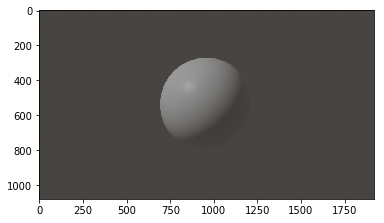

In [76]:
img = mpimg.imread('./dataset/sphere/-6.000000_6.000000.png')
# img_cropped = img[77:141, 57:121, :]
imgplot = plt.imshow(img)
# imgplot = plt.imshow(img_cropped)
img.shape

(1080, 1920)


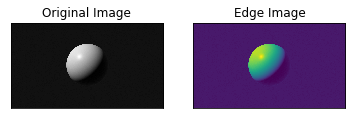

In [77]:
import cv2
img = cv2.imread('./dataset/sphere/-6.000000_6.000000.png',0)
edges = cv2.Canny(img,60,180)

print(edges.shape)

plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.imshow(img)

plt.show()

In [78]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cuda')

In [79]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, ), std=(0.5, )),
])

In [80]:
def imshow(img):
    # npimg in (channel, height, width)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [81]:
# Add file name to the label, can be iterated as follow:
# for i, data in enumerate(train_loader):
#     images,labels,paths = data
#     paths = [path.split('/')[-1] for path in paths]
#     print(paths)
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        return super(ImageFolderWithPaths, self).__getitem__(index) + (self.imgs[index][0],)

In [82]:
train_dataset = ImageFolderWithPaths(
    root='./dataset/',
    transform=transform
)
train_loader = DataLoader(
    train_dataset,
    batch_size=20,
    num_workers=5,
    shuffle=True,
    drop_last=True
)
print(train_dataset.classes)

['sphere']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([20, 1, 224, 224])


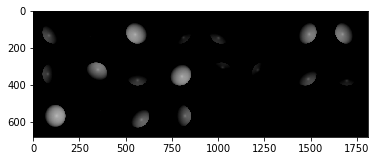

In [83]:
# get some random training images
dataiter = iter(train_loader)
quick_images, quick_labels, quick_paths = dataiter.next()

print(quick_images.shape)

# print(quick_images[0].max())
# print(quick_images[0].min())

# show images
imshow(torchvision.utils.make_grid(quick_images))

# Not sure if normalization is good or not as it darkens the image

In [84]:
img_shape = (1, 224, 224)
cuda = True if torch.cuda.is_available() else False

In [85]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.model = nn.Sequential(
            # Pixel Coord + Light Coord + Average Pixel Color
            nn.Linear(2 + 2 + 1, 16),
            nn.Linear(16, 16),
            nn.Linear(16, 16),
            # TODO: ADD DROPOUT
            nn.Linear(16, 1),
            nn.Tanh()
        )
    def forward(self, pixel_coord, light_coord, average_rgb):
        d_in = torch.cat((pixel_coord, light_coord, average_rgb), -1)
        rgb = self.model(d_in)
        return rgb

In [86]:
# Loss functions
loss = torch.nn.MSELoss()

# Initialize generator and discriminator
DNN = NN()

if cuda:
    DNN.cuda()
    loss.cuda()

In [87]:
# Optimizers
optimizer = torch.optim.Adam(DNN.parameters(), lr=0.002, betas=(0.9, 0.999))

In [88]:
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor
CharTensor = torch.cuda.CharTensor if cuda else torch.CharTensor

In [69]:
# Compute Average Color of All Pixels of All Images
# dic = dict()
# total_image = 0
# for i, data in enumerate(train_loader):
#     imgs,labels,paths = data
#     # x, y positions of the light
#     batch_size = imgs.shape[0]
#     num_channel = imgs.shape[1]
#     width = imgs.shape[2]
#     height = imgs.shape[3]
#     total_image += batch_size
#     # print(batch_size, num_channel, width, height)
#     for k in range(batch_size):
#         for i in range(width):
#             for j in range(height):
#                 key_name = str(i) + '-' + str(j)
#                 if key_name in dic:
#                     dic[key_name] = imgs[k, 0, i, j] + dic[key_name]
#                 else:
#                     dic[key_name] = imgs[k, 0, i, j]

In [70]:
# avg_img = []
# for j in range(height):
#     for i in range(width):
#         key_name = str(i) + '-' + str(j)
#         avg_img += [dic[key_name] / total_image]
# total_image

In [71]:
# avg_img = np.array(avg_img)
# print(avg_img)
# np.save('avg_img', avg_img)

In [89]:
loaded_avg_img = np.load('avg_img.npy')

In [73]:
# def sample_image(n_row, batches_done):
#     """Saves a grid of generated digits ranging from 0 to n_classes"""
#     # Sample noise
#     z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, opt.latent_dim))))
#     # Get labels ranging from 0 to n_classes for n rows
#     labels = np.array([num for _ in range(n_row) for num in range(n_row)])
#     labels = Variable(LongTensor(labels))
#     gen_imgs = generator(z, labels)
#     save_image(gen_imgs.data, "images/%d.png" % batches_done, nrow=n_row, normalize=True)

In [74]:
epochs = 1
for epoch in range(epochs):
    for i, data in enumerate(train_loader):
        # we are using paths here instead of labels
        imgs,labels,paths = data
        paths = np.array([path.split('/')[-1][:-4].split('_') for path in paths]).astype(float)
        positions = torch.from_numpy(paths).to(device)
        avg_img = torch.from_numpy(loaded_avg_img).to(device)
        imgs = imgs.to(device)
        batch_size = imgs.shape[0]
        width = imgs.shape[2]
        height = imgs.shape[3]

        # Configure input
        # Pixel Coord + Light Coord + Average Pixel Color
        avg_img = Variable(avg_img.type(FloatTensor))
        light_coord = Variable(positions.type(FloatTensor))
#         print(avg_img.shape) 
#         print(light_coord.shape)
        total_losses = 0
        for k in range(height):
            for j in range(width):
                optimizer.zero_grad()
                # Process the batch at this pixel coord
                pixel_value = Variable(imgs[:, 0, j, k].view(20, 1).type(FloatTensor))
                avg_value = Variable(avg_img[j + k * width].repeat(1, 20).view(20, 1).type(FloatTensor))
                pixel_coord = Variable(torch.FloatTensor([j, k])).repeat(1, 20).view(20, 2).to(device)
                generate_pixel = DNN(pixel_coord, light_coord, avg_value)
                # Image with all lighting conditions
                total_loss = loss(generate_pixel, pixel_value)
                total_losses += total_loss.item()
                if j == width/2 or k == width/2:
                print(
                    "[Epoch %d/%d] [Batch %d/%d] [Pixel %d-%d] [Loss: %f]"
                    % (epoch + 1, epochs, i + 1, len(train_loader), j, k, total_loss)
                )
                total_loss.backward()
        optimizer.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [Total loss: %f]"
            % (epoch + 1, epochs, i + 1, len(train_loader), total_losses)
        )

#         batches_done = epoch * len(dataloader) + i
#         if batches_done % opt.sample_interval == 0:
#             sample_image(n_row=10, batches_done=batches_done)

[Epoch 1/1] [Batch 1/6] [Pixel 0-0] [Loss: 0.501922]
[Epoch 1/1] [Batch 1/6] [Pixel 1-0] [Loss: 0.425566]
[Epoch 1/1] [Batch 1/6] [Pixel 2-0] [Loss: 0.353089]
[Epoch 1/1] [Batch 1/6] [Pixel 3-0] [Loss: 0.285184]
[Epoch 1/1] [Batch 1/6] [Pixel 4-0] [Loss: 0.223628]
[Epoch 1/1] [Batch 1/6] [Pixel 5-0] [Loss: 0.167359]
[Epoch 1/1] [Batch 1/6] [Pixel 6-0] [Loss: 0.115342]
[Epoch 1/1] [Batch 1/6] [Pixel 7-0] [Loss: 0.072400]
[Epoch 1/1] [Batch 1/6] [Pixel 8-0] [Loss: 0.047599]
[Epoch 1/1] [Batch 1/6] [Pixel 9-0] [Loss: 0.046748]
[Epoch 1/1] [Batch 1/6] [Pixel 10-0] [Loss: 0.065902]
[Epoch 1/1] [Batch 1/6] [Pixel 11-0] [Loss: 0.093484]
[Epoch 1/1] [Batch 1/6] [Pixel 12-0] [Loss: 0.119228]
[Epoch 1/1] [Batch 1/6] [Pixel 13-0] [Loss: 0.138406]
[Epoch 1/1] [Batch 1/6] [Pixel 14-0] [Loss: 0.150019]
[Epoch 1/1] [Batch 1/6] [Pixel 15-0] [Loss: 0.154282]
[Epoch 1/1] [Batch 1/6] [Pixel 16-0] [Loss: 0.151299]
[Epoch 1/1] [Batch 1/6] [Pixel 17-0] [Loss: 0.140582]
[Epoch 1/1] [Batch 1/6] [Pixel 18-0] [

[Epoch 1/1] [Batch 1/6] [Pixel 165-0] [Loss: 0.001126]
[Epoch 1/1] [Batch 1/6] [Pixel 166-0] [Loss: 0.000125]
[Epoch 1/1] [Batch 1/6] [Pixel 167-0] [Loss: 0.001097]
[Epoch 1/1] [Batch 1/6] [Pixel 168-0] [Loss: 0.000002]
[Epoch 1/1] [Batch 1/6] [Pixel 169-0] [Loss: 0.000852]
[Epoch 1/1] [Batch 1/6] [Pixel 170-0] [Loss: 0.000018]
[Epoch 1/1] [Batch 1/6] [Pixel 171-0] [Loss: 0.000684]
[Epoch 1/1] [Batch 1/6] [Pixel 172-0] [Loss: 0.000208]
[Epoch 1/1] [Batch 1/6] [Pixel 173-0] [Loss: 0.000374]
[Epoch 1/1] [Batch 1/6] [Pixel 174-0] [Loss: 0.000361]
[Epoch 1/1] [Batch 1/6] [Pixel 175-0] [Loss: 0.000076]
[Epoch 1/1] [Batch 1/6] [Pixel 176-0] [Loss: 0.000445]
[Epoch 1/1] [Batch 1/6] [Pixel 177-0] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 178-0] [Loss: 0.000385]
[Epoch 1/1] [Batch 1/6] [Pixel 179-0] [Loss: 0.000142]
[Epoch 1/1] [Batch 1/6] [Pixel 180-0] [Loss: 0.000136]
[Epoch 1/1] [Batch 1/6] [Pixel 181-0] [Loss: 0.000301]
[Epoch 1/1] [Batch 1/6] [Pixel 182-0] [Loss: 0.000003]
[Epoch 1/1

[Epoch 1/1] [Batch 1/6] [Pixel 114-1] [Loss: 0.000004]
[Epoch 1/1] [Batch 1/6] [Pixel 115-1] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 116-1] [Loss: 0.000003]
[Epoch 1/1] [Batch 1/6] [Pixel 117-1] [Loss: 0.000002]
[Epoch 1/1] [Batch 1/6] [Pixel 118-1] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 119-1] [Loss: 0.000002]
[Epoch 1/1] [Batch 1/6] [Pixel 120-1] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 121-1] [Loss: 0.000003]
[Epoch 1/1] [Batch 1/6] [Pixel 122-1] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 123-1] [Loss: 0.000002]
[Epoch 1/1] [Batch 1/6] [Pixel 124-1] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 125-1] [Loss: 0.000002]
[Epoch 1/1] [Batch 1/6] [Pixel 126-1] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 127-1] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 128-1] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 129-1] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 130-1] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 131-1] [Loss: 0.000001]
[Epoch 1/1

[Epoch 1/1] [Batch 1/6] [Pixel 68-2] [Loss: 0.000219]
[Epoch 1/1] [Batch 1/6] [Pixel 69-2] [Loss: 0.000414]
[Epoch 1/1] [Batch 1/6] [Pixel 70-2] [Loss: 0.000165]
[Epoch 1/1] [Batch 1/6] [Pixel 71-2] [Loss: 0.000291]
[Epoch 1/1] [Batch 1/6] [Pixel 72-2] [Loss: 0.000248]
[Epoch 1/1] [Batch 1/6] [Pixel 73-2] [Loss: 0.000177]
[Epoch 1/1] [Batch 1/6] [Pixel 74-2] [Loss: 0.000311]
[Epoch 1/1] [Batch 1/6] [Pixel 75-2] [Loss: 0.000023]
[Epoch 1/1] [Batch 1/6] [Pixel 76-2] [Loss: 0.000332]
[Epoch 1/1] [Batch 1/6] [Pixel 77-2] [Loss: 0.000007]
[Epoch 1/1] [Batch 1/6] [Pixel 78-2] [Loss: 0.000240]
[Epoch 1/1] [Batch 1/6] [Pixel 79-2] [Loss: 0.000171]
[Epoch 1/1] [Batch 1/6] [Pixel 80-2] [Loss: 0.000041]
[Epoch 1/1] [Batch 1/6] [Pixel 81-2] [Loss: 0.000278]
[Epoch 1/1] [Batch 1/6] [Pixel 82-2] [Loss: 0.000086]
[Epoch 1/1] [Batch 1/6] [Pixel 83-2] [Loss: 0.000059]
[Epoch 1/1] [Batch 1/6] [Pixel 84-2] [Loss: 0.000242]
[Epoch 1/1] [Batch 1/6] [Pixel 85-2] [Loss: 0.000109]
[Epoch 1/1] [Batch 1/6] [Pix

[Epoch 1/1] [Batch 1/6] [Pixel 26-3] [Loss: 0.019641]
[Epoch 1/1] [Batch 1/6] [Pixel 27-3] [Loss: 0.014032]
[Epoch 1/1] [Batch 1/6] [Pixel 28-3] [Loss: 0.005753]
[Epoch 1/1] [Batch 1/6] [Pixel 29-3] [Loss: 0.000577]
[Epoch 1/1] [Batch 1/6] [Pixel 30-3] [Loss: 0.000860]
[Epoch 1/1] [Batch 1/6] [Pixel 31-3] [Loss: 0.004933]
[Epoch 1/1] [Batch 1/6] [Pixel 32-3] [Loss: 0.009551]
[Epoch 1/1] [Batch 1/6] [Pixel 33-3] [Loss: 0.012067]
[Epoch 1/1] [Batch 1/6] [Pixel 34-3] [Loss: 0.011268]
[Epoch 1/1] [Batch 1/6] [Pixel 35-3] [Loss: 0.007529]
[Epoch 1/1] [Batch 1/6] [Pixel 36-3] [Loss: 0.002797]
[Epoch 1/1] [Batch 1/6] [Pixel 37-3] [Loss: 0.000072]
[Epoch 1/1] [Batch 1/6] [Pixel 38-3] [Loss: 0.001443]
[Epoch 1/1] [Batch 1/6] [Pixel 39-3] [Loss: 0.005252]
[Epoch 1/1] [Batch 1/6] [Pixel 40-3] [Loss: 0.006725]
[Epoch 1/1] [Batch 1/6] [Pixel 41-3] [Loss: 0.003952]
[Epoch 1/1] [Batch 1/6] [Pixel 42-3] [Loss: 0.000591]
[Epoch 1/1] [Batch 1/6] [Pixel 43-3] [Loss: 0.000367]
[Epoch 1/1] [Batch 1/6] [Pix

[Epoch 1/1] [Batch 1/6] [Pixel 203-3] [Loss: 0.284444]
[Epoch 1/1] [Batch 1/6] [Pixel 204-3] [Loss: 0.284444]
[Epoch 1/1] [Batch 1/6] [Pixel 205-3] [Loss: 0.284444]
[Epoch 1/1] [Batch 1/6] [Pixel 206-3] [Loss: 0.284444]
[Epoch 1/1] [Batch 1/6] [Pixel 207-3] [Loss: 0.284444]
[Epoch 1/1] [Batch 1/6] [Pixel 208-3] [Loss: 0.284444]
[Epoch 1/1] [Batch 1/6] [Pixel 209-3] [Loss: 0.284444]
[Epoch 1/1] [Batch 1/6] [Pixel 210-3] [Loss: 0.284444]
[Epoch 1/1] [Batch 1/6] [Pixel 211-3] [Loss: 0.284444]
[Epoch 1/1] [Batch 1/6] [Pixel 212-3] [Loss: 0.284444]
[Epoch 1/1] [Batch 1/6] [Pixel 213-3] [Loss: 0.284444]
[Epoch 1/1] [Batch 1/6] [Pixel 214-3] [Loss: 0.284444]
[Epoch 1/1] [Batch 1/6] [Pixel 215-3] [Loss: 0.284444]
[Epoch 1/1] [Batch 1/6] [Pixel 216-3] [Loss: 0.284444]
[Epoch 1/1] [Batch 1/6] [Pixel 217-3] [Loss: 0.284444]
[Epoch 1/1] [Batch 1/6] [Pixel 218-3] [Loss: 0.284444]
[Epoch 1/1] [Batch 1/6] [Pixel 219-3] [Loss: 0.284444]
[Epoch 1/1] [Batch 1/6] [Pixel 220-3] [Loss: 0.284444]
[Epoch 1/1

[Epoch 1/1] [Batch 1/6] [Pixel 136-4] [Loss: 0.000002]
[Epoch 1/1] [Batch 1/6] [Pixel 137-4] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 138-4] [Loss: 0.000002]
[Epoch 1/1] [Batch 1/6] [Pixel 139-4] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 140-4] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 141-4] [Loss: 0.000002]
[Epoch 1/1] [Batch 1/6] [Pixel 142-4] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 143-4] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 144-4] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 145-4] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 146-4] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 147-4] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 148-4] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 149-4] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 150-4] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 151-4] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 152-4] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 153-4] [Loss: 0.000001]
[Epoch 1/1

[Epoch 1/1] [Batch 1/6] [Pixel 78-5] [Loss: 0.000367]
[Epoch 1/1] [Batch 1/6] [Pixel 79-5] [Loss: 0.000722]
[Epoch 1/1] [Batch 1/6] [Pixel 80-5] [Loss: 0.000564]
[Epoch 1/1] [Batch 1/6] [Pixel 81-5] [Loss: 0.000131]
[Epoch 1/1] [Batch 1/6] [Pixel 82-5] [Loss: 0.000025]
[Epoch 1/1] [Batch 1/6] [Pixel 83-5] [Loss: 0.000313]
[Epoch 1/1] [Batch 1/6] [Pixel 84-5] [Loss: 0.000424]
[Epoch 1/1] [Batch 1/6] [Pixel 85-5] [Loss: 0.000158]
[Epoch 1/1] [Batch 1/6] [Pixel 86-5] [Loss: 0.000003]
[Epoch 1/1] [Batch 1/6] [Pixel 87-5] [Loss: 0.000186]
[Epoch 1/1] [Batch 1/6] [Pixel 88-5] [Loss: 0.000334]
[Epoch 1/1] [Batch 1/6] [Pixel 89-5] [Loss: 0.000184]
[Epoch 1/1] [Batch 1/6] [Pixel 90-5] [Loss: 0.000006]
[Epoch 1/1] [Batch 1/6] [Pixel 91-5] [Loss: 0.000087]
[Epoch 1/1] [Batch 1/6] [Pixel 92-5] [Loss: 0.000205]
[Epoch 1/1] [Batch 1/6] [Pixel 93-5] [Loss: 0.000101]
[Epoch 1/1] [Batch 1/6] [Pixel 94-5] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 95-5] [Loss: 0.000096]
[Epoch 1/1] [Batch 1/6] [Pix

[Epoch 1/1] [Batch 1/6] [Pixel 32-6] [Loss: 0.003943]
[Epoch 1/1] [Batch 1/6] [Pixel 33-6] [Loss: 0.003987]
[Epoch 1/1] [Batch 1/6] [Pixel 34-6] [Loss: 0.003532]
[Epoch 1/1] [Batch 1/6] [Pixel 35-6] [Loss: 0.002691]
[Epoch 1/1] [Batch 1/6] [Pixel 36-6] [Loss: 0.001751]
[Epoch 1/1] [Batch 1/6] [Pixel 37-6] [Loss: 0.001026]
[Epoch 1/1] [Batch 1/6] [Pixel 38-6] [Loss: 0.000705]
[Epoch 1/1] [Batch 1/6] [Pixel 39-6] [Loss: 0.000783]
[Epoch 1/1] [Batch 1/6] [Pixel 40-6] [Loss: 0.001086]
[Epoch 1/1] [Batch 1/6] [Pixel 41-6] [Loss: 0.001372]
[Epoch 1/1] [Batch 1/6] [Pixel 42-6] [Loss: 0.001444]
[Epoch 1/1] [Batch 1/6] [Pixel 43-6] [Loss: 0.001229]
[Epoch 1/1] [Batch 1/6] [Pixel 44-6] [Loss: 0.000804]
[Epoch 1/1] [Batch 1/6] [Pixel 45-6] [Loss: 0.000367]
[Epoch 1/1] [Batch 1/6] [Pixel 46-6] [Loss: 0.000129]
[Epoch 1/1] [Batch 1/6] [Pixel 47-6] [Loss: 0.000189]
[Epoch 1/1] [Batch 1/6] [Pixel 48-6] [Loss: 0.000450]
[Epoch 1/1] [Batch 1/6] [Pixel 49-6] [Loss: 0.000667]
[Epoch 1/1] [Batch 1/6] [Pix

[Epoch 1/1] [Batch 1/6] [Pixel 207-6] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 208-6] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 209-6] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 210-6] [Loss: 0.000002]
[Epoch 1/1] [Batch 1/6] [Pixel 211-6] [Loss: 0.000005]
[Epoch 1/1] [Batch 1/6] [Pixel 212-6] [Loss: 0.000019]
[Epoch 1/1] [Batch 1/6] [Pixel 213-6] [Loss: 0.000073]
[Epoch 1/1] [Batch 1/6] [Pixel 214-6] [Loss: 0.000280]
[Epoch 1/1] [Batch 1/6] [Pixel 215-6] [Loss: 0.001234]
[Epoch 1/1] [Batch 1/6] [Pixel 216-6] [Loss: 0.004593]
[Epoch 1/1] [Batch 1/6] [Pixel 217-6] [Loss: 0.021977]
[Epoch 1/1] [Batch 1/6] [Pixel 218-6] [Loss: 0.018745]
[Epoch 1/1] [Batch 1/6] [Pixel 219-6] [Loss: 0.046406]
[Epoch 1/1] [Batch 1/6] [Pixel 220-6] [Loss: 0.000703]
[Epoch 1/1] [Batch 1/6] [Pixel 221-6] [Loss: 0.105806]
[Epoch 1/1] [Batch 1/6] [Pixel 222-6] [Loss: 0.198489]
[Epoch 1/1] [Batch 1/6] [Pixel 223-6] [Loss: 0.265972]
[Epoch 1/1] [Batch 1/6] [Pixel 0-7] [Loss: 0.001535]
[Epoch 1/1] 

[Epoch 1/1] [Batch 1/6] [Pixel 156-7] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 157-7] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 158-7] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 159-7] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 160-7] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 161-7] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 162-7] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 163-7] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 164-7] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 165-7] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 166-7] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 167-7] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 168-7] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 169-7] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 170-7] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 171-7] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 172-7] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 173-7] [Loss: 0.000000]
[Epoch 1/1

[Epoch 1/1] [Batch 1/6] [Pixel 97-8] [Loss: 0.000006]
[Epoch 1/1] [Batch 1/6] [Pixel 98-8] [Loss: 0.000012]
[Epoch 1/1] [Batch 1/6] [Pixel 99-8] [Loss: 0.000011]
[Epoch 1/1] [Batch 1/6] [Pixel 100-8] [Loss: 0.000004]
[Epoch 1/1] [Batch 1/6] [Pixel 101-8] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 102-8] [Loss: 0.000003]
[Epoch 1/1] [Batch 1/6] [Pixel 103-8] [Loss: 0.000006]
[Epoch 1/1] [Batch 1/6] [Pixel 104-8] [Loss: 0.000004]
[Epoch 1/1] [Batch 1/6] [Pixel 105-8] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 106-8] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 107-8] [Loss: 0.000003]
[Epoch 1/1] [Batch 1/6] [Pixel 108-8] [Loss: 0.000005]
[Epoch 1/1] [Batch 1/6] [Pixel 109-8] [Loss: 0.000002]
[Epoch 1/1] [Batch 1/6] [Pixel 110-8] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 111-8] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 112-8] [Loss: 0.000002]
[Epoch 1/1] [Batch 1/6] [Pixel 113-8] [Loss: 0.000002]
[Epoch 1/1] [Batch 1/6] [Pixel 114-8] [Loss: 0.000000]
[Epoch 1/1] [

[Epoch 1/1] [Batch 1/6] [Pixel 48-9] [Loss: 0.000004]
[Epoch 1/1] [Batch 1/6] [Pixel 49-9] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 50-9] [Loss: 0.000007]
[Epoch 1/1] [Batch 1/6] [Pixel 51-9] [Loss: 0.000019]
[Epoch 1/1] [Batch 1/6] [Pixel 52-9] [Loss: 0.000028]
[Epoch 1/1] [Batch 1/6] [Pixel 53-9] [Loss: 0.000032]
[Epoch 1/1] [Batch 1/6] [Pixel 54-9] [Loss: 0.000028]
[Epoch 1/1] [Batch 1/6] [Pixel 55-9] [Loss: 0.000019]
[Epoch 1/1] [Batch 1/6] [Pixel 56-9] [Loss: 0.000009]
[Epoch 1/1] [Batch 1/6] [Pixel 57-9] [Loss: 0.000005]
[Epoch 1/1] [Batch 1/6] [Pixel 58-9] [Loss: 0.000006]
[Epoch 1/1] [Batch 1/6] [Pixel 59-9] [Loss: 0.000012]
[Epoch 1/1] [Batch 1/6] [Pixel 60-9] [Loss: 0.000017]
[Epoch 1/1] [Batch 1/6] [Pixel 61-9] [Loss: 0.000019]
[Epoch 1/1] [Batch 1/6] [Pixel 62-9] [Loss: 0.000016]
[Epoch 1/1] [Batch 1/6] [Pixel 63-9] [Loss: 0.000010]
[Epoch 1/1] [Batch 1/6] [Pixel 64-9] [Loss: 0.000005]
[Epoch 1/1] [Batch 1/6] [Pixel 65-9] [Loss: 0.000003]
[Epoch 1/1] [Batch 1/6] [Pix

[Epoch 1/1] [Batch 1/6] [Pixel 0-10] [Loss: 0.000007]
[Epoch 1/1] [Batch 1/6] [Pixel 1-10] [Loss: 0.000006]
[Epoch 1/1] [Batch 1/6] [Pixel 2-10] [Loss: 0.000006]
[Epoch 1/1] [Batch 1/6] [Pixel 3-10] [Loss: 0.000005]
[Epoch 1/1] [Batch 1/6] [Pixel 4-10] [Loss: 0.000004]
[Epoch 1/1] [Batch 1/6] [Pixel 5-10] [Loss: 0.000003]
[Epoch 1/1] [Batch 1/6] [Pixel 6-10] [Loss: 0.000002]
[Epoch 1/1] [Batch 1/6] [Pixel 7-10] [Loss: 0.000002]
[Epoch 1/1] [Batch 1/6] [Pixel 8-10] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 9-10] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 10-10] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 11-10] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 12-10] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 13-10] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 14-10] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 15-10] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 16-10] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 17-10] [Loss: 0.000001]
[Epoch 1/1] [Batch 1

[Epoch 1/1] [Batch 1/6] [Pixel 175-10] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 176-10] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 177-10] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 178-10] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 179-10] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 180-10] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 181-10] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 182-10] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 183-10] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 184-10] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 185-10] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 186-10] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 187-10] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 188-10] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 189-10] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 190-10] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 191-10] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 192-10] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 126-11] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 127-11] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 128-11] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 129-11] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 130-11] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 131-11] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 132-11] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 133-11] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 134-11] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 135-11] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 136-11] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 137-11] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 138-11] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 139-11] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 140-11] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 141-11] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 142-11] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 143-11] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 76-12] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 77-12] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 78-12] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 79-12] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 80-12] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 81-12] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 82-12] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 83-12] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 84-12] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 85-12] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 86-12] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 87-12] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 88-12] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 89-12] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 90-12] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 91-12] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 92-12] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 93-12] [Loss: 0.000000]
[Epoch 1/1

[Epoch 1/1] [Batch 1/6] [Pixel 27-13] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 28-13] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 29-13] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 30-13] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 31-13] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 32-13] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 33-13] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 34-13] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 35-13] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 36-13] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 37-13] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 38-13] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 39-13] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 40-13] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 41-13] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 42-13] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 43-13] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 44-13] [Loss: 0.000000]
[Epoch 1/1

[Epoch 1/1] [Batch 1/6] [Pixel 202-13] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 203-13] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 204-13] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 205-13] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 206-13] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 207-13] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 208-13] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 209-13] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 210-13] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 211-13] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 212-13] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 213-13] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 214-13] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 215-13] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 216-13] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 217-13] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 218-13] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 219-13] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 148-14] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 149-14] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 150-14] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 151-14] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 152-14] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 153-14] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 154-14] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 155-14] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 156-14] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 157-14] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 158-14] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 159-14] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 160-14] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 161-14] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 162-14] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 163-14] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 164-14] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 165-14] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 103-15] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 104-15] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 105-15] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 106-15] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 107-15] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 108-15] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 109-15] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 110-15] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 111-15] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 112-15] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 113-15] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 114-15] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 115-15] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 116-15] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 117-15] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 118-15] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 119-15] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 120-15] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 52-16] [Loss: 0.000012]
[Epoch 1/1] [Batch 1/6] [Pixel 53-16] [Loss: 0.000010]
[Epoch 1/1] [Batch 1/6] [Pixel 54-16] [Loss: 0.000010]
[Epoch 1/1] [Batch 1/6] [Pixel 55-16] [Loss: 0.000006]
[Epoch 1/1] [Batch 1/6] [Pixel 56-16] [Loss: 0.000004]
[Epoch 1/1] [Batch 1/6] [Pixel 57-16] [Loss: 0.000009]
[Epoch 1/1] [Batch 1/6] [Pixel 58-16] [Loss: 0.000015]
[Epoch 1/1] [Batch 1/6] [Pixel 59-16] [Loss: 0.000014]
[Epoch 1/1] [Batch 1/6] [Pixel 60-16] [Loss: 0.000006]
[Epoch 1/1] [Batch 1/6] [Pixel 61-16] [Loss: 0.000002]
[Epoch 1/1] [Batch 1/6] [Pixel 62-16] [Loss: 0.000003]
[Epoch 1/1] [Batch 1/6] [Pixel 63-16] [Loss: 0.000003]
[Epoch 1/1] [Batch 1/6] [Pixel 64-16] [Loss: 0.000002]
[Epoch 1/1] [Batch 1/6] [Pixel 65-16] [Loss: 0.000004]
[Epoch 1/1] [Batch 1/6] [Pixel 66-16] [Loss: 0.000008]
[Epoch 1/1] [Batch 1/6] [Pixel 67-16] [Loss: 0.000008]
[Epoch 1/1] [Batch 1/6] [Pixel 68-16] [Loss: 0.000004]
[Epoch 1/1] [Batch 1/6] [Pixel 69-16] [Loss: 0.000002]
[Epoch 1/1

[Epoch 1/1] [Batch 1/6] [Pixel 7-17] [Loss: 0.003470]
[Epoch 1/1] [Batch 1/6] [Pixel 8-17] [Loss: 0.004886]
[Epoch 1/1] [Batch 1/6] [Pixel 9-17] [Loss: 0.005533]
[Epoch 1/1] [Batch 1/6] [Pixel 10-17] [Loss: 0.005309]
[Epoch 1/1] [Batch 1/6] [Pixel 11-17] [Loss: 0.004384]
[Epoch 1/1] [Batch 1/6] [Pixel 12-17] [Loss: 0.003087]
[Epoch 1/1] [Batch 1/6] [Pixel 13-17] [Loss: 0.001787]
[Epoch 1/1] [Batch 1/6] [Pixel 14-17] [Loss: 0.000779]
[Epoch 1/1] [Batch 1/6] [Pixel 15-17] [Loss: 0.000219]
[Epoch 1/1] [Batch 1/6] [Pixel 16-17] [Loss: 0.000115]
[Epoch 1/1] [Batch 1/6] [Pixel 17-17] [Loss: 0.000350]
[Epoch 1/1] [Batch 1/6] [Pixel 18-17] [Loss: 0.000748]
[Epoch 1/1] [Batch 1/6] [Pixel 19-17] [Loss: 0.001133]
[Epoch 1/1] [Batch 1/6] [Pixel 20-17] [Loss: 0.001375]
[Epoch 1/1] [Batch 1/6] [Pixel 21-17] [Loss: 0.001415]
[Epoch 1/1] [Batch 1/6] [Pixel 22-17] [Loss: 0.001262]
[Epoch 1/1] [Batch 1/6] [Pixel 23-17] [Loss: 0.000977]
[Epoch 1/1] [Batch 1/6] [Pixel 24-17] [Loss: 0.000644]
[Epoch 1/1] [

[Epoch 1/1] [Batch 1/6] [Pixel 188-17] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 189-17] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 190-17] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 191-17] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 192-17] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 193-17] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 194-17] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 195-17] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 196-17] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 197-17] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 198-17] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 199-17] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 200-17] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 201-17] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 202-17] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 203-17] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 204-17] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 205-17] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 144-18] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 145-18] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 146-18] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 147-18] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 148-18] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 149-18] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 150-18] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 151-18] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 152-18] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 153-18] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 154-18] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 155-18] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 156-18] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 157-18] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 158-18] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 159-18] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 160-18] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 161-18] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 94-19] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 95-19] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 96-19] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 97-19] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 98-19] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 99-19] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 100-19] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 101-19] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 102-19] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 103-19] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 104-19] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 105-19] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 106-19] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 107-19] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 108-19] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 109-19] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 110-19] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 111-19] [Loss: 0.000000

[Epoch 1/1] [Batch 1/6] [Pixel 38-20] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 39-20] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 40-20] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 41-20] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 42-20] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 43-20] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 44-20] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 45-20] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 46-20] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 47-20] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 48-20] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 49-20] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 50-20] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 51-20] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 52-20] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 53-20] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 54-20] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 55-20] [Loss: 0.000000]
[Epoch 1/1

[Epoch 1/1] [Batch 1/6] [Pixel 206-20] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 207-20] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 208-20] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 209-20] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 210-20] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 211-20] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 212-20] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 213-20] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 214-20] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 215-20] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 216-20] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 217-20] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 218-20] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 219-20] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 220-20] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 221-20] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 222-20] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 223-20] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 153-21] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 154-21] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 155-21] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 156-21] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 157-21] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 158-21] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 159-21] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 160-21] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 161-21] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 162-21] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 163-21] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 164-21] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 165-21] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 166-21] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 167-21] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 168-21] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 169-21] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 170-21] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 100-22] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 101-22] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 102-22] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 103-22] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 104-22] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 105-22] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 106-22] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 107-22] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 108-22] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 109-22] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 110-22] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 111-22] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 112-22] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 113-22] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 114-22] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 115-22] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 116-22] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 117-22] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 46-23] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 47-23] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 48-23] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 49-23] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 50-23] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 51-23] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 52-23] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 53-23] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 54-23] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 55-23] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 56-23] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 57-23] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 58-23] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 59-23] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 60-23] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 61-23] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 62-23] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 63-23] [Loss: 0.000000]
[Epoch 1/1

[Epoch 1/1] [Batch 1/6] [Pixel 216-23] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 217-23] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 218-23] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 219-23] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 220-23] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 221-23] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 222-23] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 223-23] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 0-24] [Loss: 0.000007]
[Epoch 1/1] [Batch 1/6] [Pixel 1-24] [Loss: 0.000005]
[Epoch 1/1] [Batch 1/6] [Pixel 2-24] [Loss: 0.000002]
[Epoch 1/1] [Batch 1/6] [Pixel 3-24] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 4-24] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 5-24] [Loss: 0.000002]
[Epoch 1/1] [Batch 1/6] [Pixel 6-24] [Loss: 0.000003]
[Epoch 1/1] [Batch 1/6] [Pixel 7-24] [Loss: 0.000003]
[Epoch 1/1] [Batch 1/6] [Pixel 8-24] [Loss: 0.000003]
[Epoch 1/1] [Batch 1/6] [Pixel 9-24] [Loss: 0.000001]
[Epoch 1/1] 

[Epoch 1/1] [Batch 1/6] [Pixel 167-24] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 168-24] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 169-24] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 170-24] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 171-24] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 172-24] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 173-24] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 174-24] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 175-24] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 176-24] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 177-24] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 178-24] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 179-24] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 180-24] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 181-24] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 182-24] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 183-24] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 184-24] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 107-25] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 108-25] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 109-25] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 110-25] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 111-25] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 112-25] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 113-25] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 114-25] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 115-25] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 116-25] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 117-25] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 118-25] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 119-25] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 120-25] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 121-25] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 122-25] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 123-25] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 124-25] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 57-26] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 58-26] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 59-26] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 60-26] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 61-26] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 62-26] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 63-26] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 64-26] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 65-26] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 66-26] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 67-26] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 68-26] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 69-26] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 70-26] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 71-26] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 72-26] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 73-26] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 74-26] [Loss: 0.000000]
[Epoch 1/1

[Epoch 1/1] [Batch 1/6] [Pixel 221-26] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 222-26] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 223-26] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 0-27] [Loss: 0.000006]
[Epoch 1/1] [Batch 1/6] [Pixel 1-27] [Loss: 0.000003]
[Epoch 1/1] [Batch 1/6] [Pixel 2-27] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 3-27] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 4-27] [Loss: 0.000002]
[Epoch 1/1] [Batch 1/6] [Pixel 5-27] [Loss: 0.000003]
[Epoch 1/1] [Batch 1/6] [Pixel 6-27] [Loss: 0.000002]
[Epoch 1/1] [Batch 1/6] [Pixel 7-27] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 8-27] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 9-27] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 10-27] [Loss: 0.000002]
[Epoch 1/1] [Batch 1/6] [Pixel 11-27] [Loss: 0.000002]
[Epoch 1/1] [Batch 1/6] [Pixel 12-27] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 13-27] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 14-27] [Loss: 0.000000]
[Epoch 1/1] [Batc

[Epoch 1/1] [Batch 1/6] [Pixel 174-27] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 175-27] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 176-27] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 177-27] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 178-27] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 179-27] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 180-27] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 181-27] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 182-27] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 183-27] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 184-27] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 185-27] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 186-27] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 187-27] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 188-27] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 189-27] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 190-27] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 191-27] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 121-28] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 122-28] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 123-28] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 124-28] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 125-28] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 126-28] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 127-28] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 128-28] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 129-28] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 130-28] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 131-28] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 132-28] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 133-28] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 134-28] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 135-28] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 136-28] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 137-28] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 138-28] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 69-29] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 70-29] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 71-29] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 72-29] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 73-29] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 74-29] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 75-29] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 76-29] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 77-29] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 78-29] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 79-29] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 80-29] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 81-29] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 82-29] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 83-29] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 84-29] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 85-29] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 86-29] [Loss: 0.000000]
[Epoch 1/1

[Epoch 1/1] [Batch 1/6] [Pixel 26-30] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 27-30] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 28-30] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 29-30] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 30-30] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 31-30] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 32-30] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 33-30] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 34-30] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 35-30] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 36-30] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 37-30] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 38-30] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 39-30] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 40-30] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 41-30] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 42-30] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 43-30] [Loss: 0.000000]
[Epoch 1/1

[Epoch 1/1] [Batch 1/6] [Pixel 202-30] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 203-30] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 204-30] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 205-30] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 206-30] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 207-30] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 208-30] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 209-30] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 210-30] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 211-30] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 212-30] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 213-30] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 214-30] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 215-30] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 216-30] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 217-30] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 218-30] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 219-30] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 155-31] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 156-31] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 157-31] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 158-31] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 159-31] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 160-31] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 161-31] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 162-31] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 163-31] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 164-31] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 165-31] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 166-31] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 167-31] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 168-31] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 169-31] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 170-31] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 171-31] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 172-31] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 94-32] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 95-32] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 96-32] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 97-32] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 98-32] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 99-32] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 100-32] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 101-32] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 102-32] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 103-32] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 104-32] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 105-32] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 106-32] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 107-32] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 108-32] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 109-32] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 110-32] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 111-32] [Loss: 0.000000

[Epoch 1/1] [Batch 1/6] [Pixel 43-33] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 44-33] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 45-33] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 46-33] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 47-33] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 48-33] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 49-33] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 50-33] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 51-33] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 52-33] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 53-33] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 54-33] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 55-33] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 56-33] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 57-33] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 58-33] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 59-33] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 60-33] [Loss: 0.000000]
[Epoch 1/1

[Epoch 1/1] [Batch 1/6] [Pixel 220-33] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 221-33] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 222-33] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 223-33] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 0-34] [Loss: 0.000003]
[Epoch 1/1] [Batch 1/6] [Pixel 1-34] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 2-34] [Loss: 0.000002]
[Epoch 1/1] [Batch 1/6] [Pixel 3-34] [Loss: 0.000002]
[Epoch 1/1] [Batch 1/6] [Pixel 4-34] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 5-34] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 6-34] [Loss: 0.000002]
[Epoch 1/1] [Batch 1/6] [Pixel 7-34] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 8-34] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 9-34] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 10-34] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 11-34] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 12-34] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 13-34] [Loss: 0.000000]
[Epoch 1/1] [Bat

[Epoch 1/1] [Batch 1/6] [Pixel 172-34] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 173-34] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 174-34] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 175-34] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 176-34] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 177-34] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 178-34] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 179-34] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 180-34] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 181-34] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 182-34] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 183-34] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 184-34] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 185-34] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 186-34] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 187-34] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 188-34] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 189-34] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 115-35] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 116-35] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 117-35] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 118-35] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 119-35] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 120-35] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 121-35] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 122-35] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 123-35] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 124-35] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 125-35] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 126-35] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 127-35] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 128-35] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 129-35] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 130-35] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 131-35] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 132-35] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 65-36] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 66-36] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 67-36] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 68-36] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 69-36] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 70-36] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 71-36] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 72-36] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 73-36] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 74-36] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 75-36] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 76-36] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 77-36] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 78-36] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 79-36] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 80-36] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 81-36] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 82-36] [Loss: 0.000000]
[Epoch 1/1

[Epoch 1/1] [Batch 1/6] [Pixel 218-36] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 219-36] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 220-36] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 221-36] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 222-36] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 223-36] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 0-37] [Loss: 0.000002]
[Epoch 1/1] [Batch 1/6] [Pixel 1-37] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 2-37] [Loss: 0.000003]
[Epoch 1/1] [Batch 1/6] [Pixel 3-37] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 4-37] [Loss: 0.000002]
[Epoch 1/1] [Batch 1/6] [Pixel 5-37] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 6-37] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 7-37] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 8-37] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 9-37] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 10-37] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 11-37] [Loss: 0.000001]
[Epoch 1/1] [B

[Epoch 1/1] [Batch 1/6] [Pixel 162-37] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 163-37] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 164-37] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 165-37] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 166-37] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 167-37] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 168-37] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 169-37] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 170-37] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 171-37] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 172-37] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 173-37] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 174-37] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 175-37] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 176-37] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 177-37] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 178-37] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 179-37] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 107-38] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 108-38] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 109-38] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 110-38] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 111-38] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 112-38] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 113-38] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 114-38] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 115-38] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 116-38] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 117-38] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 118-38] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 119-38] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 120-38] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 121-38] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 122-38] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 123-38] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 124-38] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 50-39] [Loss: 0.000003]
[Epoch 1/1] [Batch 1/6] [Pixel 51-39] [Loss: 0.000023]
[Epoch 1/1] [Batch 1/6] [Pixel 52-39] [Loss: 0.000061]
[Epoch 1/1] [Batch 1/6] [Pixel 53-39] [Loss: 0.000037]
[Epoch 1/1] [Batch 1/6] [Pixel 54-39] [Loss: 0.000002]
[Epoch 1/1] [Batch 1/6] [Pixel 55-39] [Loss: 0.000023]
[Epoch 1/1] [Batch 1/6] [Pixel 56-39] [Loss: 0.000049]
[Epoch 1/1] [Batch 1/6] [Pixel 57-39] [Loss: 0.000025]
[Epoch 1/1] [Batch 1/6] [Pixel 58-39] [Loss: 0.000002]
[Epoch 1/1] [Batch 1/6] [Pixel 59-39] [Loss: 0.000022]
[Epoch 1/1] [Batch 1/6] [Pixel 60-39] [Loss: 0.000031]
[Epoch 1/1] [Batch 1/6] [Pixel 61-39] [Loss: 0.000007]
[Epoch 1/1] [Batch 1/6] [Pixel 62-39] [Loss: 0.000007]
[Epoch 1/1] [Batch 1/6] [Pixel 63-39] [Loss: 0.000025]
[Epoch 1/1] [Batch 1/6] [Pixel 64-39] [Loss: 0.000016]
[Epoch 1/1] [Batch 1/6] [Pixel 65-39] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 66-39] [Loss: 0.000013]
[Epoch 1/1] [Batch 1/6] [Pixel 67-39] [Loss: 0.000015]
[Epoch 1/1

[Epoch 1/1] [Batch 1/6] [Pixel 223-39] [Loss: 0.000004]
[Epoch 1/1] [Batch 1/6] [Pixel 0-40] [Loss: 0.002638]
[Epoch 1/1] [Batch 1/6] [Pixel 1-40] [Loss: 0.001512]
[Epoch 1/1] [Batch 1/6] [Pixel 2-40] [Loss: 0.000351]
[Epoch 1/1] [Batch 1/6] [Pixel 3-40] [Loss: 0.000036]
[Epoch 1/1] [Batch 1/6] [Pixel 4-40] [Loss: 0.000592]
[Epoch 1/1] [Batch 1/6] [Pixel 5-40] [Loss: 0.001196]
[Epoch 1/1] [Batch 1/6] [Pixel 6-40] [Loss: 0.001124]
[Epoch 1/1] [Batch 1/6] [Pixel 7-40] [Loss: 0.000551]
[Epoch 1/1] [Batch 1/6] [Pixel 8-40] [Loss: 0.000091]
[Epoch 1/1] [Batch 1/6] [Pixel 9-40] [Loss: 0.000018]
[Epoch 1/1] [Batch 1/6] [Pixel 10-40] [Loss: 0.000202]
[Epoch 1/1] [Batch 1/6] [Pixel 11-40] [Loss: 0.000412]
[Epoch 1/1] [Batch 1/6] [Pixel 12-40] [Loss: 0.000507]
[Epoch 1/1] [Batch 1/6] [Pixel 13-40] [Loss: 0.000455]
[Epoch 1/1] [Batch 1/6] [Pixel 14-40] [Loss: 0.000310]
[Epoch 1/1] [Batch 1/6] [Pixel 15-40] [Loss: 0.000154]
[Epoch 1/1] [Batch 1/6] [Pixel 16-40] [Loss: 0.000062]
[Epoch 1/1] [Batch 

[Epoch 1/1] [Batch 1/6] [Pixel 170-40] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 171-40] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 172-40] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 173-40] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 174-40] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 175-40] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 176-40] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 177-40] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 178-40] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 179-40] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 180-40] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 181-40] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 182-40] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 183-40] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 184-40] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 185-40] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 186-40] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 187-40] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 107-41] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 108-41] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 109-41] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 110-41] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 111-41] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 112-41] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 113-41] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 114-41] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 115-41] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 116-41] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 117-41] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 118-41] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 119-41] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 120-41] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 121-41] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 122-41] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 123-41] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 124-41] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 65-42] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 66-42] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 67-42] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 68-42] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 69-42] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 70-42] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 71-42] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 72-42] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 73-42] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 74-42] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 75-42] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 76-42] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 77-42] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 78-42] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 79-42] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 80-42] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 81-42] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 82-42] [Loss: 0.000000]
[Epoch 1/1

[Epoch 1/1] [Batch 1/6] [Pixel 19-43] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 20-43] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 21-43] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 22-43] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 23-43] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 24-43] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 25-43] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 26-43] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 27-43] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 28-43] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 29-43] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 30-43] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 31-43] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 32-43] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 33-43] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 34-43] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 35-43] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 36-43] [Loss: 0.000000]
[Epoch 1/1

[Epoch 1/1] [Batch 1/6] [Pixel 194-43] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 195-43] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 196-43] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 197-43] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 198-43] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 199-43] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 200-43] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 201-43] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 202-43] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 203-43] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 204-43] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 205-43] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 206-43] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 207-43] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 208-43] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 209-43] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 210-43] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 211-43] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 155-44] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 156-44] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 157-44] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 158-44] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 159-44] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 160-44] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 161-44] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 162-44] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 163-44] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 164-44] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 165-44] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 166-44] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 167-44] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 168-44] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 169-44] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 170-44] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 171-44] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 172-44] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 103-45] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 104-45] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 105-45] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 106-45] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 107-45] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 108-45] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 109-45] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 110-45] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 111-45] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 112-45] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 113-45] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 114-45] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 115-45] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 116-45] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 117-45] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 118-45] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 119-45] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 120-45] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 52-46] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 53-46] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 54-46] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 55-46] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 56-46] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 57-46] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 58-46] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 59-46] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 60-46] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 61-46] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 62-46] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 63-46] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 64-46] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 65-46] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 66-46] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 67-46] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 68-46] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 69-46] [Loss: 0.000000]
[Epoch 1/1

[Epoch 1/1] [Batch 1/6] [Pixel 3-47] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 4-47] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 5-47] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 6-47] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 7-47] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 8-47] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 9-47] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 10-47] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 11-47] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 12-47] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 13-47] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 14-47] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 15-47] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 16-47] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 17-47] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 18-47] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 19-47] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 20-47] [Loss: 0.000000]
[Epoch 1/1] [Batc

[Epoch 1/1] [Batch 1/6] [Pixel 176-47] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 177-47] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 178-47] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 179-47] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 180-47] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 181-47] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 182-47] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 183-47] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 184-47] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 185-47] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 186-47] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 187-47] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 188-47] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 189-47] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 190-47] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 191-47] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 192-47] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 193-47] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 125-48] [Loss: 0.003232]
[Epoch 1/1] [Batch 1/6] [Pixel 126-48] [Loss: 0.000373]
[Epoch 1/1] [Batch 1/6] [Pixel 127-48] [Loss: 0.002137]
[Epoch 1/1] [Batch 1/6] [Pixel 128-48] [Loss: 0.000952]
[Epoch 1/1] [Batch 1/6] [Pixel 129-48] [Loss: 0.001494]
[Epoch 1/1] [Batch 1/6] [Pixel 130-48] [Loss: 0.000981]
[Epoch 1/1] [Batch 1/6] [Pixel 131-48] [Loss: 0.001040]
[Epoch 1/1] [Batch 1/6] [Pixel 132-48] [Loss: 0.001013]
[Epoch 1/1] [Batch 1/6] [Pixel 133-48] [Loss: 0.000564]
[Epoch 1/1] [Batch 1/6] [Pixel 134-48] [Loss: 0.000968]
[Epoch 1/1] [Batch 1/6] [Pixel 135-48] [Loss: 0.000272]
[Epoch 1/1] [Batch 1/6] [Pixel 136-48] [Loss: 0.000940]
[Epoch 1/1] [Batch 1/6] [Pixel 137-48] [Loss: 0.000028]
[Epoch 1/1] [Batch 1/6] [Pixel 138-48] [Loss: 0.000849]
[Epoch 1/1] [Batch 1/6] [Pixel 139-48] [Loss: 0.000027]
[Epoch 1/1] [Batch 1/6] [Pixel 140-48] [Loss: 0.000583]
[Epoch 1/1] [Batch 1/6] [Pixel 141-48] [Loss: 0.000208]
[Epoch 1/1] [Batch 1/6] [Pixel 142-48] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 74-49] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 75-49] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 76-49] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 77-49] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 78-49] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 79-49] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 80-49] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 81-49] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 82-49] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 83-49] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 84-49] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 85-49] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 86-49] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 87-49] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 88-49] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 89-49] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 90-49] [Loss: 0.000000]
[Epoch 1/1] [Batch 1/6] [Pixel 91-49] [Loss: 0.000000]
[Epoch 1/1

[Epoch 1/1] [Batch 1/6] [Pixel 19-50] [Loss: 0.000762]
[Epoch 1/1] [Batch 1/6] [Pixel 20-50] [Loss: 0.000926]
[Epoch 1/1] [Batch 1/6] [Pixel 21-50] [Loss: 0.000753]
[Epoch 1/1] [Batch 1/6] [Pixel 22-50] [Loss: 0.000391]
[Epoch 1/1] [Batch 1/6] [Pixel 23-50] [Loss: 0.000095]
[Epoch 1/1] [Batch 1/6] [Pixel 24-50] [Loss: 0.000021]
[Epoch 1/1] [Batch 1/6] [Pixel 25-50] [Loss: 0.000149]
[Epoch 1/1] [Batch 1/6] [Pixel 26-50] [Loss: 0.000342]
[Epoch 1/1] [Batch 1/6] [Pixel 27-50] [Loss: 0.000453]
[Epoch 1/1] [Batch 1/6] [Pixel 28-50] [Loss: 0.000415]
[Epoch 1/1] [Batch 1/6] [Pixel 29-50] [Loss: 0.000261]
[Epoch 1/1] [Batch 1/6] [Pixel 30-50] [Loss: 0.000093]
[Epoch 1/1] [Batch 1/6] [Pixel 31-50] [Loss: 0.000008]
[Epoch 1/1] [Batch 1/6] [Pixel 32-50] [Loss: 0.000036]
[Epoch 1/1] [Batch 1/6] [Pixel 33-50] [Loss: 0.000128]
[Epoch 1/1] [Batch 1/6] [Pixel 34-50] [Loss: 0.000201]
[Epoch 1/1] [Batch 1/6] [Pixel 35-50] [Loss: 0.000197]
[Epoch 1/1] [Batch 1/6] [Pixel 36-50] [Loss: 0.000126]
[Epoch 1/1

[Epoch 1/1] [Batch 1/6] [Pixel 199-50] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 200-50] [Loss: 0.000010]
[Epoch 1/1] [Batch 1/6] [Pixel 201-50] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 202-50] [Loss: 0.000006]
[Epoch 1/1] [Batch 1/6] [Pixel 203-50] [Loss: 0.000006]
[Epoch 1/1] [Batch 1/6] [Pixel 204-50] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 205-50] [Loss: 0.000006]
[Epoch 1/1] [Batch 1/6] [Pixel 206-50] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 207-50] [Loss: 0.000004]
[Epoch 1/1] [Batch 1/6] [Pixel 208-50] [Loss: 0.000003]
[Epoch 1/1] [Batch 1/6] [Pixel 209-50] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 210-50] [Loss: 0.000004]
[Epoch 1/1] [Batch 1/6] [Pixel 211-50] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 212-50] [Loss: 0.000004]
[Epoch 1/1] [Batch 1/6] [Pixel 213-50] [Loss: 0.000001]
[Epoch 1/1] [Batch 1/6] [Pixel 214-50] [Loss: 0.000002]
[Epoch 1/1] [Batch 1/6] [Pixel 215-50] [Loss: 0.000002]
[Epoch 1/1] [Batch 1/6] [Pixel 216-50] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 145-51] [Loss: 0.001922]
[Epoch 1/1] [Batch 1/6] [Pixel 146-51] [Loss: 0.003333]
[Epoch 1/1] [Batch 1/6] [Pixel 147-51] [Loss: 0.001026]
[Epoch 1/1] [Batch 1/6] [Pixel 148-51] [Loss: 0.000870]
[Epoch 1/1] [Batch 1/6] [Pixel 149-51] [Loss: 0.002686]
[Epoch 1/1] [Batch 1/6] [Pixel 150-51] [Loss: 0.002127]
[Epoch 1/1] [Batch 1/6] [Pixel 151-51] [Loss: 0.000646]
[Epoch 1/1] [Batch 1/6] [Pixel 152-51] [Loss: 0.001540]
[Epoch 1/1] [Batch 1/6] [Pixel 153-51] [Loss: 0.002090]
[Epoch 1/1] [Batch 1/6] [Pixel 154-51] [Loss: 0.000769]
[Epoch 1/1] [Batch 1/6] [Pixel 155-51] [Loss: 0.000798]
[Epoch 1/1] [Batch 1/6] [Pixel 156-51] [Loss: 0.001545]
[Epoch 1/1] [Batch 1/6] [Pixel 157-51] [Loss: 0.000980]
[Epoch 1/1] [Batch 1/6] [Pixel 158-51] [Loss: 0.000315]
[Epoch 1/1] [Batch 1/6] [Pixel 159-51] [Loss: 0.000782]
[Epoch 1/1] [Batch 1/6] [Pixel 160-51] [Loss: 0.000862]
[Epoch 1/1] [Batch 1/6] [Pixel 161-51] [Loss: 0.000234]
[Epoch 1/1] [Batch 1/6] [Pixel 162-51] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 100-52] [Loss: 0.072566]
[Epoch 1/1] [Batch 1/6] [Pixel 101-52] [Loss: 0.048170]
[Epoch 1/1] [Batch 1/6] [Pixel 102-52] [Loss: 0.064038]
[Epoch 1/1] [Batch 1/6] [Pixel 103-52] [Loss: 0.056052]
[Epoch 1/1] [Batch 1/6] [Pixel 104-52] [Loss: 0.050810]
[Epoch 1/1] [Batch 1/6] [Pixel 105-52] [Loss: 0.062544]
[Epoch 1/1] [Batch 1/6] [Pixel 106-52] [Loss: 0.046706]
[Epoch 1/1] [Batch 1/6] [Pixel 107-52] [Loss: 0.058692]
[Epoch 1/1] [Batch 1/6] [Pixel 108-52] [Loss: 0.051361]
[Epoch 1/1] [Batch 1/6] [Pixel 109-52] [Loss: 0.051584]
[Epoch 1/1] [Batch 1/6] [Pixel 110-52] [Loss: 0.055458]
[Epoch 1/1] [Batch 1/6] [Pixel 111-52] [Loss: 0.047270]
[Epoch 1/1] [Batch 1/6] [Pixel 112-52] [Loss: 0.054500]
[Epoch 1/1] [Batch 1/6] [Pixel 113-52] [Loss: 0.048647]
[Epoch 1/1] [Batch 1/6] [Pixel 114-52] [Loss: 0.049558]
[Epoch 1/1] [Batch 1/6] [Pixel 115-52] [Loss: 0.051386]
[Epoch 1/1] [Batch 1/6] [Pixel 116-52] [Loss: 0.046316]
[Epoch 1/1] [Batch 1/6] [Pixel 117-52] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 50-53] [Loss: 0.000028]
[Epoch 1/1] [Batch 1/6] [Pixel 51-53] [Loss: 0.000005]
[Epoch 1/1] [Batch 1/6] [Pixel 52-53] [Loss: 0.000021]
[Epoch 1/1] [Batch 1/6] [Pixel 53-53] [Loss: 0.000048]
[Epoch 1/1] [Batch 1/6] [Pixel 54-53] [Loss: 0.000056]
[Epoch 1/1] [Batch 1/6] [Pixel 55-53] [Loss: 0.000040]
[Epoch 1/1] [Batch 1/6] [Pixel 56-53] [Loss: 0.000015]
[Epoch 1/1] [Batch 1/6] [Pixel 57-53] [Loss: 0.000003]
[Epoch 1/1] [Batch 1/6] [Pixel 58-53] [Loss: 0.000016]
[Epoch 1/1] [Batch 1/6] [Pixel 59-53] [Loss: 0.000044]
[Epoch 1/1] [Batch 1/6] [Pixel 60-53] [Loss: 0.000067]
[Epoch 1/1] [Batch 1/6] [Pixel 61-53] [Loss: 0.000067]
[Epoch 1/1] [Batch 1/6] [Pixel 62-53] [Loss: 0.000046]
[Epoch 1/1] [Batch 1/6] [Pixel 63-53] [Loss: 0.000019]
[Epoch 1/1] [Batch 1/6] [Pixel 64-53] [Loss: 0.000004]
[Epoch 1/1] [Batch 1/6] [Pixel 65-53] [Loss: 0.000004]
[Epoch 1/1] [Batch 1/6] [Pixel 66-53] [Loss: 0.000012]
[Epoch 1/1] [Batch 1/6] [Pixel 67-53] [Loss: 0.000015]
[Epoch 1/1

[Epoch 1/1] [Batch 1/6] [Pixel 0-54] [Loss: 0.039717]
[Epoch 1/1] [Batch 1/6] [Pixel 1-54] [Loss: 0.024012]
[Epoch 1/1] [Batch 1/6] [Pixel 2-54] [Loss: 0.008204]
[Epoch 1/1] [Batch 1/6] [Pixel 3-54] [Loss: 0.001067]
[Epoch 1/1] [Batch 1/6] [Pixel 4-54] [Loss: 0.002329]
[Epoch 1/1] [Batch 1/6] [Pixel 5-54] [Loss: 0.007448]
[Epoch 1/1] [Batch 1/6] [Pixel 6-54] [Loss: 0.011873]
[Epoch 1/1] [Batch 1/6] [Pixel 7-54] [Loss: 0.013181]
[Epoch 1/1] [Batch 1/6] [Pixel 8-54] [Loss: 0.011320]
[Epoch 1/1] [Batch 1/6] [Pixel 9-54] [Loss: 0.007744]
[Epoch 1/1] [Batch 1/6] [Pixel 10-54] [Loss: 0.004229]
[Epoch 1/1] [Batch 1/6] [Pixel 11-54] [Loss: 0.001955]
[Epoch 1/1] [Batch 1/6] [Pixel 12-54] [Loss: 0.001198]
[Epoch 1/1] [Batch 1/6] [Pixel 13-54] [Loss: 0.001591]
[Epoch 1/1] [Batch 1/6] [Pixel 14-54] [Loss: 0.002546]
[Epoch 1/1] [Batch 1/6] [Pixel 15-54] [Loss: 0.003551]
[Epoch 1/1] [Batch 1/6] [Pixel 16-54] [Loss: 0.004283]
[Epoch 1/1] [Batch 1/6] [Pixel 17-54] [Loss: 0.004599]
[Epoch 1/1] [Batch 1

[Epoch 1/1] [Batch 1/6] [Pixel 167-54] [Loss: 0.000108]
[Epoch 1/1] [Batch 1/6] [Pixel 168-54] [Loss: 0.000404]
[Epoch 1/1] [Batch 1/6] [Pixel 169-54] [Loss: 0.001245]
[Epoch 1/1] [Batch 1/6] [Pixel 170-54] [Loss: 0.000851]
[Epoch 1/1] [Batch 1/6] [Pixel 171-54] [Loss: 0.000081]
[Epoch 1/1] [Batch 1/6] [Pixel 172-54] [Loss: 0.000318]
[Epoch 1/1] [Batch 1/6] [Pixel 173-54] [Loss: 0.000857]
[Epoch 1/1] [Batch 1/6] [Pixel 174-54] [Loss: 0.000635]
[Epoch 1/1] [Batch 1/6] [Pixel 175-54] [Loss: 0.000103]
[Epoch 1/1] [Batch 1/6] [Pixel 176-54] [Loss: 0.000190]
[Epoch 1/1] [Batch 1/6] [Pixel 177-54] [Loss: 0.000568]
[Epoch 1/1] [Batch 1/6] [Pixel 178-54] [Loss: 0.000416]
[Epoch 1/1] [Batch 1/6] [Pixel 179-54] [Loss: 0.000068]
[Epoch 1/1] [Batch 1/6] [Pixel 180-54] [Loss: 0.000165]
[Epoch 1/1] [Batch 1/6] [Pixel 181-54] [Loss: 0.000404]
[Epoch 1/1] [Batch 1/6] [Pixel 182-54] [Loss: 0.000293]
[Epoch 1/1] [Batch 1/6] [Pixel 183-54] [Loss: 0.000058]
[Epoch 1/1] [Batch 1/6] [Pixel 184-54] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 117-55] [Loss: 0.057814]
[Epoch 1/1] [Batch 1/6] [Pixel 118-55] [Loss: 0.056988]
[Epoch 1/1] [Batch 1/6] [Pixel 119-55] [Loss: 0.053708]
[Epoch 1/1] [Batch 1/6] [Pixel 120-55] [Loss: 0.052988]
[Epoch 1/1] [Batch 1/6] [Pixel 121-55] [Loss: 0.054847]
[Epoch 1/1] [Batch 1/6] [Pixel 122-55] [Loss: 0.054450]
[Epoch 1/1] [Batch 1/6] [Pixel 123-55] [Loss: 0.051126]
[Epoch 1/1] [Batch 1/6] [Pixel 124-55] [Loss: 0.051326]
[Epoch 1/1] [Batch 1/6] [Pixel 125-55] [Loss: 0.052029]
[Epoch 1/1] [Batch 1/6] [Pixel 126-55] [Loss: 0.050248]
[Epoch 1/1] [Batch 1/6] [Pixel 127-55] [Loss: 0.048112]
[Epoch 1/1] [Batch 1/6] [Pixel 128-55] [Loss: 0.049550]
[Epoch 1/1] [Batch 1/6] [Pixel 129-55] [Loss: 0.048669]
[Epoch 1/1] [Batch 1/6] [Pixel 130-55] [Loss: 0.047061]
[Epoch 1/1] [Batch 1/6] [Pixel 131-55] [Loss: 0.047358]
[Epoch 1/1] [Batch 1/6] [Pixel 132-55] [Loss: 0.046982]
[Epoch 1/1] [Batch 1/6] [Pixel 133-55] [Loss: 0.046127]
[Epoch 1/1] [Batch 1/6] [Pixel 134-55] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 73-56] [Loss: 0.000036]
[Epoch 1/1] [Batch 1/6] [Pixel 74-56] [Loss: 0.000024]
[Epoch 1/1] [Batch 1/6] [Pixel 75-56] [Loss: 0.000014]
[Epoch 1/1] [Batch 1/6] [Pixel 76-56] [Loss: 0.000007]
[Epoch 1/1] [Batch 1/6] [Pixel 77-56] [Loss: 0.000007]
[Epoch 1/1] [Batch 1/6] [Pixel 78-56] [Loss: 0.000010]
[Epoch 1/1] [Batch 1/6] [Pixel 79-56] [Loss: 0.000314]
[Epoch 1/1] [Batch 1/6] [Pixel 80-56] [Loss: 0.014384]
[Epoch 1/1] [Batch 1/6] [Pixel 81-56] [Loss: 0.089498]
[Epoch 1/1] [Batch 1/6] [Pixel 82-56] [Loss: 0.154797]
[Epoch 1/1] [Batch 1/6] [Pixel 83-56] [Loss: 0.136394]
[Epoch 1/1] [Batch 1/6] [Pixel 84-56] [Loss: 0.100051]
[Epoch 1/1] [Batch 1/6] [Pixel 85-56] [Loss: 0.084844]
[Epoch 1/1] [Batch 1/6] [Pixel 86-56] [Loss: 0.088214]
[Epoch 1/1] [Batch 1/6] [Pixel 87-56] [Loss: 0.101122]
[Epoch 1/1] [Batch 1/6] [Pixel 88-56] [Loss: 0.107687]
[Epoch 1/1] [Batch 1/6] [Pixel 89-56] [Loss: 0.098253]
[Epoch 1/1] [Batch 1/6] [Pixel 90-56] [Loss: 0.086693]
[Epoch 1/1

[Epoch 1/1] [Batch 1/6] [Pixel 30-57] [Loss: 0.002326]
[Epoch 1/1] [Batch 1/6] [Pixel 31-57] [Loss: 0.001996]
[Epoch 1/1] [Batch 1/6] [Pixel 32-57] [Loss: 0.001563]
[Epoch 1/1] [Batch 1/6] [Pixel 33-57] [Loss: 0.001188]
[Epoch 1/1] [Batch 1/6] [Pixel 34-57] [Loss: 0.000980]
[Epoch 1/1] [Batch 1/6] [Pixel 35-57] [Loss: 0.000957]
[Epoch 1/1] [Batch 1/6] [Pixel 36-57] [Loss: 0.001058]
[Epoch 1/1] [Batch 1/6] [Pixel 37-57] [Loss: 0.001183]
[Epoch 1/1] [Batch 1/6] [Pixel 38-57] [Loss: 0.001243]
[Epoch 1/1] [Batch 1/6] [Pixel 39-57] [Loss: 0.001194]
[Epoch 1/1] [Batch 1/6] [Pixel 40-57] [Loss: 0.001048]
[Epoch 1/1] [Batch 1/6] [Pixel 41-57] [Loss: 0.000856]
[Epoch 1/1] [Batch 1/6] [Pixel 42-57] [Loss: 0.000678]
[Epoch 1/1] [Batch 1/6] [Pixel 43-57] [Loss: 0.000560]
[Epoch 1/1] [Batch 1/6] [Pixel 44-57] [Loss: 0.000515]
[Epoch 1/1] [Batch 1/6] [Pixel 45-57] [Loss: 0.000524]
[Epoch 1/1] [Batch 1/6] [Pixel 46-57] [Loss: 0.000552]
[Epoch 1/1] [Batch 1/6] [Pixel 47-57] [Loss: 0.000566]
[Epoch 1/1

[Epoch 1/1] [Batch 1/6] [Pixel 210-57] [Loss: 0.000150]
[Epoch 1/1] [Batch 1/6] [Pixel 211-57] [Loss: 0.000157]
[Epoch 1/1] [Batch 1/6] [Pixel 212-57] [Loss: 0.000162]
[Epoch 1/1] [Batch 1/6] [Pixel 213-57] [Loss: 0.000157]
[Epoch 1/1] [Batch 1/6] [Pixel 214-57] [Loss: 0.000145]
[Epoch 1/1] [Batch 1/6] [Pixel 215-57] [Loss: 0.000132]
[Epoch 1/1] [Batch 1/6] [Pixel 216-57] [Loss: 0.000126]
[Epoch 1/1] [Batch 1/6] [Pixel 217-57] [Loss: 0.000128]
[Epoch 1/1] [Batch 1/6] [Pixel 218-57] [Loss: 0.000132]
[Epoch 1/1] [Batch 1/6] [Pixel 219-57] [Loss: 0.000133]
[Epoch 1/1] [Batch 1/6] [Pixel 220-57] [Loss: 0.000127]
[Epoch 1/1] [Batch 1/6] [Pixel 221-57] [Loss: 0.000118]
[Epoch 1/1] [Batch 1/6] [Pixel 222-57] [Loss: 0.000109]
[Epoch 1/1] [Batch 1/6] [Pixel 223-57] [Loss: 0.000105]
[Epoch 1/1] [Batch 1/6] [Pixel 0-58] [Loss: 0.049328]
[Epoch 1/1] [Batch 1/6] [Pixel 1-58] [Loss: 0.042713]
[Epoch 1/1] [Batch 1/6] [Pixel 2-58] [Loss: 0.033223]
[Epoch 1/1] [Batch 1/6] [Pixel 3-58] [Loss: 0.023492]


[Epoch 1/1] [Batch 1/6] [Pixel 163-58] [Loss: 0.003810]
[Epoch 1/1] [Batch 1/6] [Pixel 164-58] [Loss: 0.002139]
[Epoch 1/1] [Batch 1/6] [Pixel 165-58] [Loss: 0.000868]
[Epoch 1/1] [Batch 1/6] [Pixel 166-58] [Loss: 0.000574]
[Epoch 1/1] [Batch 1/6] [Pixel 167-58] [Loss: 0.001163]
[Epoch 1/1] [Batch 1/6] [Pixel 168-58] [Loss: 0.002075]
[Epoch 1/1] [Batch 1/6] [Pixel 169-58] [Loss: 0.002688]
[Epoch 1/1] [Batch 1/6] [Pixel 170-58] [Loss: 0.002650]
[Epoch 1/1] [Batch 1/6] [Pixel 171-58] [Loss: 0.002015]
[Epoch 1/1] [Batch 1/6] [Pixel 172-58] [Loss: 0.001169]
[Epoch 1/1] [Batch 1/6] [Pixel 173-58] [Loss: 0.000584]
[Epoch 1/1] [Batch 1/6] [Pixel 174-58] [Loss: 0.000531]
[Epoch 1/1] [Batch 1/6] [Pixel 175-58] [Loss: 0.000924]
[Epoch 1/1] [Batch 1/6] [Pixel 176-58] [Loss: 0.001406]
[Epoch 1/1] [Batch 1/6] [Pixel 177-58] [Loss: 0.001610]
[Epoch 1/1] [Batch 1/6] [Pixel 178-58] [Loss: 0.001412]
[Epoch 1/1] [Batch 1/6] [Pixel 179-58] [Loss: 0.000972]
[Epoch 1/1] [Batch 1/6] [Pixel 180-58] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 114-59] [Loss: 0.054796]
[Epoch 1/1] [Batch 1/6] [Pixel 115-59] [Loss: 0.053456]
[Epoch 1/1] [Batch 1/6] [Pixel 116-59] [Loss: 0.054418]
[Epoch 1/1] [Batch 1/6] [Pixel 117-59] [Loss: 0.054758]
[Epoch 1/1] [Batch 1/6] [Pixel 118-59] [Loss: 0.053233]
[Epoch 1/1] [Batch 1/6] [Pixel 119-59] [Loss: 0.053215]
[Epoch 1/1] [Batch 1/6] [Pixel 120-59] [Loss: 0.054281]
[Epoch 1/1] [Batch 1/6] [Pixel 121-59] [Loss: 0.052916]
[Epoch 1/1] [Batch 1/6] [Pixel 122-59] [Loss: 0.052318]
[Epoch 1/1] [Batch 1/6] [Pixel 123-59] [Loss: 0.053060]
[Epoch 1/1] [Batch 1/6] [Pixel 124-59] [Loss: 0.053117]
[Epoch 1/1] [Batch 1/6] [Pixel 125-59] [Loss: 0.052535]
[Epoch 1/1] [Batch 1/6] [Pixel 126-59] [Loss: 0.052280]
[Epoch 1/1] [Batch 1/6] [Pixel 127-59] [Loss: 0.052487]
[Epoch 1/1] [Batch 1/6] [Pixel 128-59] [Loss: 0.051063]
[Epoch 1/1] [Batch 1/6] [Pixel 129-59] [Loss: 0.051356]
[Epoch 1/1] [Batch 1/6] [Pixel 130-59] [Loss: 0.050739]
[Epoch 1/1] [Batch 1/6] [Pixel 131-59] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 59-60] [Loss: 0.000236]
[Epoch 1/1] [Batch 1/6] [Pixel 60-60] [Loss: 0.000220]
[Epoch 1/1] [Batch 1/6] [Pixel 61-60] [Loss: 0.000208]
[Epoch 1/1] [Batch 1/6] [Pixel 62-60] [Loss: 0.000199]
[Epoch 1/1] [Batch 1/6] [Pixel 63-60] [Loss: 0.000192]
[Epoch 1/1] [Batch 1/6] [Pixel 64-60] [Loss: 0.000188]
[Epoch 1/1] [Batch 1/6] [Pixel 65-60] [Loss: 0.000185]
[Epoch 1/1] [Batch 1/6] [Pixel 66-60] [Loss: 0.000181]
[Epoch 1/1] [Batch 1/6] [Pixel 67-60] [Loss: 0.000178]
[Epoch 1/1] [Batch 1/6] [Pixel 68-60] [Loss: 0.000173]
[Epoch 1/1] [Batch 1/6] [Pixel 69-60] [Loss: 0.000168]
[Epoch 1/1] [Batch 1/6] [Pixel 70-60] [Loss: 0.000163]
[Epoch 1/1] [Batch 1/6] [Pixel 71-60] [Loss: 0.000157]
[Epoch 1/1] [Batch 1/6] [Pixel 72-60] [Loss: 0.000152]
[Epoch 1/1] [Batch 1/6] [Pixel 73-60] [Loss: 0.000726]
[Epoch 1/1] [Batch 1/6] [Pixel 74-60] [Loss: 0.044984]
[Epoch 1/1] [Batch 1/6] [Pixel 75-60] [Loss: 0.173936]
[Epoch 1/1] [Batch 1/6] [Pixel 76-60] [Loss: 0.195060]
[Epoch 1/1

[Epoch 1/1] [Batch 1/6] [Pixel 10-61] [Loss: 0.003934]
[Epoch 1/1] [Batch 1/6] [Pixel 11-61] [Loss: 0.001482]
[Epoch 1/1] [Batch 1/6] [Pixel 12-61] [Loss: 0.000299]
[Epoch 1/1] [Batch 1/6] [Pixel 13-61] [Loss: 0.000391]
[Epoch 1/1] [Batch 1/6] [Pixel 14-61] [Loss: 0.001440]
[Epoch 1/1] [Batch 1/6] [Pixel 15-61] [Loss: 0.002866]
[Epoch 1/1] [Batch 1/6] [Pixel 16-61] [Loss: 0.004035]
[Epoch 1/1] [Batch 1/6] [Pixel 17-61] [Loss: 0.004493]
[Epoch 1/1] [Batch 1/6] [Pixel 18-61] [Loss: 0.004114]
[Epoch 1/1] [Batch 1/6] [Pixel 19-61] [Loss: 0.003100]
[Epoch 1/1] [Batch 1/6] [Pixel 20-61] [Loss: 0.001850]
[Epoch 1/1] [Batch 1/6] [Pixel 21-61] [Loss: 0.000784]
[Epoch 1/1] [Batch 1/6] [Pixel 22-61] [Loss: 0.000188]
[Epoch 1/1] [Batch 1/6] [Pixel 23-61] [Loss: 0.000142]
[Epoch 1/1] [Batch 1/6] [Pixel 24-61] [Loss: 0.000527]
[Epoch 1/1] [Batch 1/6] [Pixel 25-61] [Loss: 0.001106]
[Epoch 1/1] [Batch 1/6] [Pixel 26-61] [Loss: 0.001619]
[Epoch 1/1] [Batch 1/6] [Pixel 27-61] [Loss: 0.001879]
[Epoch 1/1

[Epoch 1/1] [Batch 1/6] [Pixel 179-61] [Loss: 0.001731]
[Epoch 1/1] [Batch 1/6] [Pixel 180-61] [Loss: 0.002120]
[Epoch 1/1] [Batch 1/6] [Pixel 181-61] [Loss: 0.002501]
[Epoch 1/1] [Batch 1/6] [Pixel 182-61] [Loss: 0.002695]
[Epoch 1/1] [Batch 1/6] [Pixel 183-61] [Loss: 0.002632]
[Epoch 1/1] [Batch 1/6] [Pixel 184-61] [Loss: 0.002343]
[Epoch 1/1] [Batch 1/6] [Pixel 185-61] [Loss: 0.001925]
[Epoch 1/1] [Batch 1/6] [Pixel 186-61] [Loss: 0.001499]
[Epoch 1/1] [Batch 1/6] [Pixel 187-61] [Loss: 0.001168]
[Epoch 1/1] [Batch 1/6] [Pixel 188-61] [Loss: 0.000990]
[Epoch 1/1] [Batch 1/6] [Pixel 189-61] [Loss: 0.000964]
[Epoch 1/1] [Batch 1/6] [Pixel 190-61] [Loss: 0.001040]
[Epoch 1/1] [Batch 1/6] [Pixel 191-61] [Loss: 0.001144]
[Epoch 1/1] [Batch 1/6] [Pixel 192-61] [Loss: 0.001205]
[Epoch 1/1] [Batch 1/6] [Pixel 193-61] [Loss: 0.001183]
[Epoch 1/1] [Batch 1/6] [Pixel 194-61] [Loss: 0.001079]
[Epoch 1/1] [Batch 1/6] [Pixel 195-61] [Loss: 0.000922]
[Epoch 1/1] [Batch 1/6] [Pixel 196-61] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 122-62] [Loss: 0.056587]
[Epoch 1/1] [Batch 1/6] [Pixel 123-62] [Loss: 0.056578]
[Epoch 1/1] [Batch 1/6] [Pixel 124-62] [Loss: 0.055893]
[Epoch 1/1] [Batch 1/6] [Pixel 125-62] [Loss: 0.055886]
[Epoch 1/1] [Batch 1/6] [Pixel 126-62] [Loss: 0.056204]
[Epoch 1/1] [Batch 1/6] [Pixel 127-62] [Loss: 0.055063]
[Epoch 1/1] [Batch 1/6] [Pixel 128-62] [Loss: 0.054498]
[Epoch 1/1] [Batch 1/6] [Pixel 129-62] [Loss: 0.054304]
[Epoch 1/1] [Batch 1/6] [Pixel 130-62] [Loss: 0.053543]
[Epoch 1/1] [Batch 1/6] [Pixel 131-62] [Loss: 0.052693]
[Epoch 1/1] [Batch 1/6] [Pixel 132-62] [Loss: 0.052513]
[Epoch 1/1] [Batch 1/6] [Pixel 133-62] [Loss: 0.052440]
[Epoch 1/1] [Batch 1/6] [Pixel 134-62] [Loss: 0.051961]
[Epoch 1/1] [Batch 1/6] [Pixel 135-62] [Loss: 0.051585]
[Epoch 1/1] [Batch 1/6] [Pixel 136-62] [Loss: 0.051692]
[Epoch 1/1] [Batch 1/6] [Pixel 137-62] [Loss: 0.050590]
[Epoch 1/1] [Batch 1/6] [Pixel 138-62] [Loss: 0.050152]
[Epoch 1/1] [Batch 1/6] [Pixel 139-62] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 82-63] [Loss: 0.075700]
[Epoch 1/1] [Batch 1/6] [Pixel 83-63] [Loss: 0.080015]
[Epoch 1/1] [Batch 1/6] [Pixel 84-63] [Loss: 0.077477]
[Epoch 1/1] [Batch 1/6] [Pixel 85-63] [Loss: 0.068453]
[Epoch 1/1] [Batch 1/6] [Pixel 86-63] [Loss: 0.060062]
[Epoch 1/1] [Batch 1/6] [Pixel 87-63] [Loss: 0.057599]
[Epoch 1/1] [Batch 1/6] [Pixel 88-63] [Loss: 0.060600]
[Epoch 1/1] [Batch 1/6] [Pixel 89-63] [Loss: 0.064704]
[Epoch 1/1] [Batch 1/6] [Pixel 90-63] [Loss: 0.065460]
[Epoch 1/1] [Batch 1/6] [Pixel 91-63] [Loss: 0.061609]
[Epoch 1/1] [Batch 1/6] [Pixel 92-63] [Loss: 0.056545]
[Epoch 1/1] [Batch 1/6] [Pixel 93-63] [Loss: 0.053347]
[Epoch 1/1] [Batch 1/6] [Pixel 94-63] [Loss: 0.055296]
[Epoch 1/1] [Batch 1/6] [Pixel 95-63] [Loss: 0.059208]
[Epoch 1/1] [Batch 1/6] [Pixel 96-63] [Loss: 0.060461]
[Epoch 1/1] [Batch 1/6] [Pixel 97-63] [Loss: 0.057411]
[Epoch 1/1] [Batch 1/6] [Pixel 98-63] [Loss: 0.054264]
[Epoch 1/1] [Batch 1/6] [Pixel 99-63] [Loss: 0.054220]
[Epoch 1/1

[Epoch 1/1] [Batch 1/6] [Pixel 27-64] [Loss: 0.000469]
[Epoch 1/1] [Batch 1/6] [Pixel 28-64] [Loss: 0.000648]
[Epoch 1/1] [Batch 1/6] [Pixel 29-64] [Loss: 0.000809]
[Epoch 1/1] [Batch 1/6] [Pixel 30-64] [Loss: 0.000928]
[Epoch 1/1] [Batch 1/6] [Pixel 31-64] [Loss: 0.000991]
[Epoch 1/1] [Batch 1/6] [Pixel 32-64] [Loss: 0.000995]
[Epoch 1/1] [Batch 1/6] [Pixel 33-64] [Loss: 0.000944]
[Epoch 1/1] [Batch 1/6] [Pixel 34-64] [Loss: 0.000849]
[Epoch 1/1] [Batch 1/6] [Pixel 35-64] [Loss: 0.000724]
[Epoch 1/1] [Batch 1/6] [Pixel 36-64] [Loss: 0.000584]
[Epoch 1/1] [Batch 1/6] [Pixel 37-64] [Loss: 0.000444]
[Epoch 1/1] [Batch 1/6] [Pixel 38-64] [Loss: 0.000317]
[Epoch 1/1] [Batch 1/6] [Pixel 39-64] [Loss: 0.000212]
[Epoch 1/1] [Batch 1/6] [Pixel 40-64] [Loss: 0.000133]
[Epoch 1/1] [Batch 1/6] [Pixel 41-64] [Loss: 0.000083]
[Epoch 1/1] [Batch 1/6] [Pixel 42-64] [Loss: 0.000058]
[Epoch 1/1] [Batch 1/6] [Pixel 43-64] [Loss: 0.000051]
[Epoch 1/1] [Batch 1/6] [Pixel 44-64] [Loss: 0.000057]
[Epoch 1/1

[Epoch 1/1] [Batch 1/6] [Pixel 195-64] [Loss: 0.000675]
[Epoch 1/1] [Batch 1/6] [Pixel 196-64] [Loss: 0.000729]
[Epoch 1/1] [Batch 1/6] [Pixel 197-64] [Loss: 0.000816]
[Epoch 1/1] [Batch 1/6] [Pixel 198-64] [Loss: 0.000866]
[Epoch 1/1] [Batch 1/6] [Pixel 199-64] [Loss: 0.000843]
[Epoch 1/1] [Batch 1/6] [Pixel 200-64] [Loss: 0.000751]
[Epoch 1/1] [Batch 1/6] [Pixel 201-64] [Loss: 0.000634]
[Epoch 1/1] [Batch 1/6] [Pixel 202-64] [Loss: 0.000538]
[Epoch 1/1] [Batch 1/6] [Pixel 203-64] [Loss: 0.000490]
[Epoch 1/1] [Batch 1/6] [Pixel 204-64] [Loss: 0.000488]
[Epoch 1/1] [Batch 1/6] [Pixel 205-64] [Loss: 0.000509]
[Epoch 1/1] [Batch 1/6] [Pixel 206-64] [Loss: 0.000523]
[Epoch 1/1] [Batch 1/6] [Pixel 207-64] [Loss: 0.000510]
[Epoch 1/1] [Batch 1/6] [Pixel 208-64] [Loss: 0.000471]
[Epoch 1/1] [Batch 1/6] [Pixel 209-64] [Loss: 0.000419]
[Epoch 1/1] [Batch 1/6] [Pixel 210-64] [Loss: 0.000374]
[Epoch 1/1] [Batch 1/6] [Pixel 211-64] [Loss: 0.000350]
[Epoch 1/1] [Batch 1/6] [Pixel 212-64] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 153-65] [Loss: 0.044869]
[Epoch 1/1] [Batch 1/6] [Pixel 154-65] [Loss: 0.038497]
[Epoch 1/1] [Batch 1/6] [Pixel 155-65] [Loss: 0.045005]
[Epoch 1/1] [Batch 1/6] [Pixel 156-65] [Loss: 0.043641]
[Epoch 1/1] [Batch 1/6] [Pixel 157-65] [Loss: 0.037287]
[Epoch 1/1] [Batch 1/6] [Pixel 158-65] [Loss: 0.066378]
[Epoch 1/1] [Batch 1/6] [Pixel 159-65] [Loss: 0.072052]
[Epoch 1/1] [Batch 1/6] [Pixel 160-65] [Loss: 0.052090]
[Epoch 1/1] [Batch 1/6] [Pixel 161-65] [Loss: 0.023760]
[Epoch 1/1] [Batch 1/6] [Pixel 162-65] [Loss: 0.012380]
[Epoch 1/1] [Batch 1/6] [Pixel 163-65] [Loss: 0.022380]
[Epoch 1/1] [Batch 1/6] [Pixel 164-65] [Loss: 0.028971]
[Epoch 1/1] [Batch 1/6] [Pixel 165-65] [Loss: 0.021093]
[Epoch 1/1] [Batch 1/6] [Pixel 166-65] [Loss: 0.009574]
[Epoch 1/1] [Batch 1/6] [Pixel 167-65] [Loss: 0.003245]
[Epoch 1/1] [Batch 1/6] [Pixel 168-65] [Loss: 0.002357]
[Epoch 1/1] [Batch 1/6] [Pixel 169-65] [Loss: 0.003895]
[Epoch 1/1] [Batch 1/6] [Pixel 170-65] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 112-66] [Loss: 0.063554]
[Epoch 1/1] [Batch 1/6] [Pixel 113-66] [Loss: 0.063227]
[Epoch 1/1] [Batch 1/6] [Pixel 114-66] [Loss: 0.062772]
[Epoch 1/1] [Batch 1/6] [Pixel 115-66] [Loss: 0.063334]
[Epoch 1/1] [Batch 1/6] [Pixel 116-66] [Loss: 0.064968]
[Epoch 1/1] [Batch 1/6] [Pixel 117-66] [Loss: 0.065203]
[Epoch 1/1] [Batch 1/6] [Pixel 118-66] [Loss: 0.065226]
[Epoch 1/1] [Batch 1/6] [Pixel 119-66] [Loss: 0.065062]
[Epoch 1/1] [Batch 1/6] [Pixel 120-66] [Loss: 0.065710]
[Epoch 1/1] [Batch 1/6] [Pixel 121-66] [Loss: 0.065729]
[Epoch 1/1] [Batch 1/6] [Pixel 122-66] [Loss: 0.066008]
[Epoch 1/1] [Batch 1/6] [Pixel 123-66] [Loss: 0.064996]
[Epoch 1/1] [Batch 1/6] [Pixel 124-66] [Loss: 0.065036]
[Epoch 1/1] [Batch 1/6] [Pixel 125-66] [Loss: 0.064984]
[Epoch 1/1] [Batch 1/6] [Pixel 126-66] [Loss: 0.064939]
[Epoch 1/1] [Batch 1/6] [Pixel 127-66] [Loss: 0.064143]
[Epoch 1/1] [Batch 1/6] [Pixel 128-66] [Loss: 0.063858]
[Epoch 1/1] [Batch 1/6] [Pixel 129-66] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 67-67] [Loss: 0.189985]
[Epoch 1/1] [Batch 1/6] [Pixel 68-67] [Loss: 0.193259]
[Epoch 1/1] [Batch 1/6] [Pixel 69-67] [Loss: 0.178801]
[Epoch 1/1] [Batch 1/6] [Pixel 70-67] [Loss: 0.163695]
[Epoch 1/1] [Batch 1/6] [Pixel 71-67] [Loss: 0.148034]
[Epoch 1/1] [Batch 1/6] [Pixel 72-67] [Loss: 0.135432]
[Epoch 1/1] [Batch 1/6] [Pixel 73-67] [Loss: 0.120485]
[Epoch 1/1] [Batch 1/6] [Pixel 74-67] [Loss: 0.106107]
[Epoch 1/1] [Batch 1/6] [Pixel 75-67] [Loss: 0.091242]
[Epoch 1/1] [Batch 1/6] [Pixel 76-67] [Loss: 0.076481]
[Epoch 1/1] [Batch 1/6] [Pixel 77-67] [Loss: 0.063782]
[Epoch 1/1] [Batch 1/6] [Pixel 78-67] [Loss: 0.056166]
[Epoch 1/1] [Batch 1/6] [Pixel 79-67] [Loss: 0.057202]
[Epoch 1/1] [Batch 1/6] [Pixel 80-67] [Loss: 0.065552]
[Epoch 1/1] [Batch 1/6] [Pixel 81-67] [Loss: 0.073418]
[Epoch 1/1] [Batch 1/6] [Pixel 82-67] [Loss: 0.070600]
[Epoch 1/1] [Batch 1/6] [Pixel 83-67] [Loss: 0.060653]
[Epoch 1/1] [Batch 1/6] [Pixel 84-67] [Loss: 0.052572]
[Epoch 1/1

[Epoch 1/1] [Batch 1/6] [Pixel 26-68] [Loss: 0.002351]
[Epoch 1/1] [Batch 1/6] [Pixel 27-68] [Loss: 0.002428]
[Epoch 1/1] [Batch 1/6] [Pixel 28-68] [Loss: 0.002453]
[Epoch 1/1] [Batch 1/6] [Pixel 29-68] [Loss: 0.002418]
[Epoch 1/1] [Batch 1/6] [Pixel 30-68] [Loss: 0.002325]
[Epoch 1/1] [Batch 1/6] [Pixel 31-68] [Loss: 0.002185]
[Epoch 1/1] [Batch 1/6] [Pixel 32-68] [Loss: 0.002010]
[Epoch 1/1] [Batch 1/6] [Pixel 33-68] [Loss: 0.001819]
[Epoch 1/1] [Batch 1/6] [Pixel 34-68] [Loss: 0.001628]
[Epoch 1/1] [Batch 1/6] [Pixel 35-68] [Loss: 0.001449]
[Epoch 1/1] [Batch 1/6] [Pixel 36-68] [Loss: 0.001293]
[Epoch 1/1] [Batch 1/6] [Pixel 37-68] [Loss: 0.001167]
[Epoch 1/1] [Batch 1/6] [Pixel 38-68] [Loss: 0.001071]
[Epoch 1/1] [Batch 1/6] [Pixel 39-68] [Loss: 0.001003]
[Epoch 1/1] [Batch 1/6] [Pixel 40-68] [Loss: 0.000958]
[Epoch 1/1] [Batch 1/6] [Pixel 41-68] [Loss: 0.000928]
[Epoch 1/1] [Batch 1/6] [Pixel 42-68] [Loss: 0.000905]
[Epoch 1/1] [Batch 1/6] [Pixel 43-68] [Loss: 0.000884]
[Epoch 1/1

[Epoch 1/1] [Batch 1/6] [Pixel 203-68] [Loss: 0.001423]
[Epoch 1/1] [Batch 1/6] [Pixel 204-68] [Loss: 0.001312]
[Epoch 1/1] [Batch 1/6] [Pixel 205-68] [Loss: 0.001157]
[Epoch 1/1] [Batch 1/6] [Pixel 206-68] [Loss: 0.000997]
[Epoch 1/1] [Batch 1/6] [Pixel 207-68] [Loss: 0.000866]
[Epoch 1/1] [Batch 1/6] [Pixel 208-68] [Loss: 0.000784]
[Epoch 1/1] [Batch 1/6] [Pixel 209-68] [Loss: 0.000751]
[Epoch 1/1] [Batch 1/6] [Pixel 210-68] [Loss: 0.000752]
[Epoch 1/1] [Batch 1/6] [Pixel 211-68] [Loss: 0.000765]
[Epoch 1/1] [Batch 1/6] [Pixel 212-68] [Loss: 0.000772]
[Epoch 1/1] [Batch 1/6] [Pixel 213-68] [Loss: 0.000757]
[Epoch 1/1] [Batch 1/6] [Pixel 214-68] [Loss: 0.000719]
[Epoch 1/1] [Batch 1/6] [Pixel 215-68] [Loss: 0.000665]
[Epoch 1/1] [Batch 1/6] [Pixel 216-68] [Loss: 0.000606]
[Epoch 1/1] [Batch 1/6] [Pixel 217-68] [Loss: 0.000555]
[Epoch 1/1] [Batch 1/6] [Pixel 218-68] [Loss: 0.000522]
[Epoch 1/1] [Batch 1/6] [Pixel 219-68] [Loss: 0.000509]
[Epoch 1/1] [Batch 1/6] [Pixel 220-68] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 149-69] [Loss: 0.051597]
[Epoch 1/1] [Batch 1/6] [Pixel 150-69] [Loss: 0.051234]
[Epoch 1/1] [Batch 1/6] [Pixel 151-69] [Loss: 0.050651]
[Epoch 1/1] [Batch 1/6] [Pixel 152-69] [Loss: 0.051457]
[Epoch 1/1] [Batch 1/6] [Pixel 153-69] [Loss: 0.051297]
[Epoch 1/1] [Batch 1/6] [Pixel 154-69] [Loss: 0.049888]
[Epoch 1/1] [Batch 1/6] [Pixel 155-69] [Loss: 0.047825]
[Epoch 1/1] [Batch 1/6] [Pixel 156-69] [Loss: 0.047127]
[Epoch 1/1] [Batch 1/6] [Pixel 157-69] [Loss: 0.045356]
[Epoch 1/1] [Batch 1/6] [Pixel 158-69] [Loss: 0.039739]
[Epoch 1/1] [Batch 1/6] [Pixel 159-69] [Loss: 0.063391]
[Epoch 1/1] [Batch 1/6] [Pixel 160-69] [Loss: 0.067437]
[Epoch 1/1] [Batch 1/6] [Pixel 161-69] [Loss: 0.028700]
[Epoch 1/1] [Batch 1/6] [Pixel 162-69] [Loss: 0.046653]
[Epoch 1/1] [Batch 1/6] [Pixel 163-69] [Loss: 0.065498]
[Epoch 1/1] [Batch 1/6] [Pixel 164-69] [Loss: 0.065118]
[Epoch 1/1] [Batch 1/6] [Pixel 165-69] [Loss: 0.048770]
[Epoch 1/1] [Batch 1/6] [Pixel 166-69] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 102-70] [Loss: 0.061915]
[Epoch 1/1] [Batch 1/6] [Pixel 103-70] [Loss: 0.062078]
[Epoch 1/1] [Batch 1/6] [Pixel 104-70] [Loss: 0.061107]
[Epoch 1/1] [Batch 1/6] [Pixel 105-70] [Loss: 0.060746]
[Epoch 1/1] [Batch 1/6] [Pixel 106-70] [Loss: 0.059977]
[Epoch 1/1] [Batch 1/6] [Pixel 107-70] [Loss: 0.061528]
[Epoch 1/1] [Batch 1/6] [Pixel 108-70] [Loss: 0.062625]
[Epoch 1/1] [Batch 1/6] [Pixel 109-70] [Loss: 0.063963]
[Epoch 1/1] [Batch 1/6] [Pixel 110-70] [Loss: 0.064024]
[Epoch 1/1] [Batch 1/6] [Pixel 111-70] [Loss: 0.064282]
[Epoch 1/1] [Batch 1/6] [Pixel 112-70] [Loss: 0.063988]
[Epoch 1/1] [Batch 1/6] [Pixel 113-70] [Loss: 0.064492]
[Epoch 1/1] [Batch 1/6] [Pixel 114-70] [Loss: 0.064222]
[Epoch 1/1] [Batch 1/6] [Pixel 115-70] [Loss: 0.065290]
[Epoch 1/1] [Batch 1/6] [Pixel 116-70] [Loss: 0.065610]
[Epoch 1/1] [Batch 1/6] [Pixel 117-70] [Loss: 0.065977]
[Epoch 1/1] [Batch 1/6] [Pixel 118-70] [Loss: 0.065457]
[Epoch 1/1] [Batch 1/6] [Pixel 119-70] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 60-71] [Loss: 0.000391]
[Epoch 1/1] [Batch 1/6] [Pixel 61-71] [Loss: 0.000382]
[Epoch 1/1] [Batch 1/6] [Pixel 62-71] [Loss: 0.006262]
[Epoch 1/1] [Batch 1/6] [Pixel 63-71] [Loss: 0.124587]
[Epoch 1/1] [Batch 1/6] [Pixel 64-71] [Loss: 0.198218]
[Epoch 1/1] [Batch 1/6] [Pixel 65-71] [Loss: 0.193135]
[Epoch 1/1] [Batch 1/6] [Pixel 66-71] [Loss: 0.180222]
[Epoch 1/1] [Batch 1/6] [Pixel 67-71] [Loss: 0.167556]
[Epoch 1/1] [Batch 1/6] [Pixel 68-71] [Loss: 0.153475]
[Epoch 1/1] [Batch 1/6] [Pixel 69-71] [Loss: 0.141499]
[Epoch 1/1] [Batch 1/6] [Pixel 70-71] [Loss: 0.130504]
[Epoch 1/1] [Batch 1/6] [Pixel 71-71] [Loss: 0.121675]
[Epoch 1/1] [Batch 1/6] [Pixel 72-71] [Loss: 0.112589]
[Epoch 1/1] [Batch 1/6] [Pixel 73-71] [Loss: 0.101272]
[Epoch 1/1] [Batch 1/6] [Pixel 74-71] [Loss: 0.090710]
[Epoch 1/1] [Batch 1/6] [Pixel 75-71] [Loss: 0.079040]
[Epoch 1/1] [Batch 1/6] [Pixel 76-71] [Loss: 0.069731]
[Epoch 1/1] [Batch 1/6] [Pixel 77-71] [Loss: 0.065051]
[Epoch 1/1

[Epoch 1/1] [Batch 1/6] [Pixel 16-72] [Loss: 0.003909]
[Epoch 1/1] [Batch 1/6] [Pixel 17-72] [Loss: 0.004127]
[Epoch 1/1] [Batch 1/6] [Pixel 18-72] [Loss: 0.003998]
[Epoch 1/1] [Batch 1/6] [Pixel 19-72] [Loss: 0.003586]
[Epoch 1/1] [Batch 1/6] [Pixel 20-72] [Loss: 0.003009]
[Epoch 1/1] [Batch 1/6] [Pixel 21-72] [Loss: 0.002398]
[Epoch 1/1] [Batch 1/6] [Pixel 22-72] [Loss: 0.001863]
[Epoch 1/1] [Batch 1/6] [Pixel 23-72] [Loss: 0.001472]
[Epoch 1/1] [Batch 1/6] [Pixel 24-72] [Loss: 0.001245]
[Epoch 1/1] [Batch 1/6] [Pixel 25-72] [Loss: 0.001168]
[Epoch 1/1] [Batch 1/6] [Pixel 26-72] [Loss: 0.001202]
[Epoch 1/1] [Batch 1/6] [Pixel 27-72] [Loss: 0.001300]
[Epoch 1/1] [Batch 1/6] [Pixel 28-72] [Loss: 0.001416]
[Epoch 1/1] [Batch 1/6] [Pixel 29-72] [Loss: 0.001513]
[Epoch 1/1] [Batch 1/6] [Pixel 30-72] [Loss: 0.001568]
[Epoch 1/1] [Batch 1/6] [Pixel 31-72] [Loss: 0.001568]
[Epoch 1/1] [Batch 1/6] [Pixel 32-72] [Loss: 0.001514]
[Epoch 1/1] [Batch 1/6] [Pixel 33-72] [Loss: 0.001415]
[Epoch 1/1

[Epoch 1/1] [Batch 1/6] [Pixel 198-72] [Loss: 0.000157]
[Epoch 1/1] [Batch 1/6] [Pixel 199-72] [Loss: 0.000130]
[Epoch 1/1] [Batch 1/6] [Pixel 200-72] [Loss: 0.000276]
[Epoch 1/1] [Batch 1/6] [Pixel 201-72] [Loss: 0.000503]
[Epoch 1/1] [Batch 1/6] [Pixel 202-72] [Loss: 0.000707]
[Epoch 1/1] [Batch 1/6] [Pixel 203-72] [Loss: 0.000809]
[Epoch 1/1] [Batch 1/6] [Pixel 204-72] [Loss: 0.000780]
[Epoch 1/1] [Batch 1/6] [Pixel 205-72] [Loss: 0.000642]
[Epoch 1/1] [Batch 1/6] [Pixel 206-72] [Loss: 0.000451]
[Epoch 1/1] [Batch 1/6] [Pixel 207-72] [Loss: 0.000268]
[Epoch 1/1] [Batch 1/6] [Pixel 208-72] [Loss: 0.000140]
[Epoch 1/1] [Batch 1/6] [Pixel 209-72] [Loss: 0.000085]
[Epoch 1/1] [Batch 1/6] [Pixel 210-72] [Loss: 0.000095]
[Epoch 1/1] [Batch 1/6] [Pixel 211-72] [Loss: 0.000145]
[Epoch 1/1] [Batch 1/6] [Pixel 212-72] [Loss: 0.000206]
[Epoch 1/1] [Batch 1/6] [Pixel 213-72] [Loss: 0.000251]
[Epoch 1/1] [Batch 1/6] [Pixel 214-72] [Loss: 0.000267]
[Epoch 1/1] [Batch 1/6] [Pixel 215-72] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 163-73] [Loss: 0.099152]
[Epoch 1/1] [Batch 1/6] [Pixel 164-73] [Loss: 0.052403]
[Epoch 1/1] [Batch 1/6] [Pixel 165-73] [Loss: 0.030066]
[Epoch 1/1] [Batch 1/6] [Pixel 166-73] [Loss: 0.032171]
[Epoch 1/1] [Batch 1/6] [Pixel 167-73] [Loss: 0.036810]
[Epoch 1/1] [Batch 1/6] [Pixel 168-73] [Loss: 0.034526]
[Epoch 1/1] [Batch 1/6] [Pixel 169-73] [Loss: 0.025339]
[Epoch 1/1] [Batch 1/6] [Pixel 170-73] [Loss: 0.013686]
[Epoch 1/1] [Batch 1/6] [Pixel 171-73] [Loss: 0.004807]
[Epoch 1/1] [Batch 1/6] [Pixel 172-73] [Loss: 0.001736]
[Epoch 1/1] [Batch 1/6] [Pixel 173-73] [Loss: 0.004100]
[Epoch 1/1] [Batch 1/6] [Pixel 174-73] [Loss: 0.009243]
[Epoch 1/1] [Batch 1/6] [Pixel 175-73] [Loss: 0.014117]
[Epoch 1/1] [Batch 1/6] [Pixel 176-73] [Loss: 0.016593]
[Epoch 1/1] [Batch 1/6] [Pixel 177-73] [Loss: 0.015970]
[Epoch 1/1] [Batch 1/6] [Pixel 178-73] [Loss: 0.012814]
[Epoch 1/1] [Batch 1/6] [Pixel 179-73] [Loss: 0.008428]
[Epoch 1/1] [Batch 1/6] [Pixel 180-73] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 110-74] [Loss: 0.072052]
[Epoch 1/1] [Batch 1/6] [Pixel 111-74] [Loss: 0.072514]
[Epoch 1/1] [Batch 1/6] [Pixel 112-74] [Loss: 0.071584]
[Epoch 1/1] [Batch 1/6] [Pixel 113-74] [Loss: 0.071216]
[Epoch 1/1] [Batch 1/6] [Pixel 114-74] [Loss: 0.070091]
[Epoch 1/1] [Batch 1/6] [Pixel 115-74] [Loss: 0.068776]
[Epoch 1/1] [Batch 1/6] [Pixel 116-74] [Loss: 0.068692]
[Epoch 1/1] [Batch 1/6] [Pixel 117-74] [Loss: 0.068621]
[Epoch 1/1] [Batch 1/6] [Pixel 118-74] [Loss: 0.067455]
[Epoch 1/1] [Batch 1/6] [Pixel 119-74] [Loss: 0.066693]
[Epoch 1/1] [Batch 1/6] [Pixel 120-74] [Loss: 0.067165]
[Epoch 1/1] [Batch 1/6] [Pixel 121-74] [Loss: 0.067576]
[Epoch 1/1] [Batch 1/6] [Pixel 122-74] [Loss: 0.067371]
[Epoch 1/1] [Batch 1/6] [Pixel 123-74] [Loss: 0.067381]
[Epoch 1/1] [Batch 1/6] [Pixel 124-74] [Loss: 0.067410]
[Epoch 1/1] [Batch 1/6] [Pixel 125-74] [Loss: 0.066883]
[Epoch 1/1] [Batch 1/6] [Pixel 126-74] [Loss: 0.067221]
[Epoch 1/1] [Batch 1/6] [Pixel 127-74] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 59-75] [Loss: 0.021077]
[Epoch 1/1] [Batch 1/6] [Pixel 60-75] [Loss: 0.158153]
[Epoch 1/1] [Batch 1/6] [Pixel 61-75] [Loss: 0.179483]
[Epoch 1/1] [Batch 1/6] [Pixel 62-75] [Loss: 0.158384]
[Epoch 1/1] [Batch 1/6] [Pixel 63-75] [Loss: 0.136631]
[Epoch 1/1] [Batch 1/6] [Pixel 64-75] [Loss: 0.117873]
[Epoch 1/1] [Batch 1/6] [Pixel 65-75] [Loss: 0.103607]
[Epoch 1/1] [Batch 1/6] [Pixel 66-75] [Loss: 0.094412]
[Epoch 1/1] [Batch 1/6] [Pixel 67-75] [Loss: 0.086337]
[Epoch 1/1] [Batch 1/6] [Pixel 68-75] [Loss: 0.080023]
[Epoch 1/1] [Batch 1/6] [Pixel 69-75] [Loss: 0.074206]
[Epoch 1/1] [Batch 1/6] [Pixel 70-75] [Loss: 0.071478]
[Epoch 1/1] [Batch 1/6] [Pixel 71-75] [Loss: 0.069968]
[Epoch 1/1] [Batch 1/6] [Pixel 72-75] [Loss: 0.071891]
[Epoch 1/1] [Batch 1/6] [Pixel 73-75] [Loss: 0.073931]
[Epoch 1/1] [Batch 1/6] [Pixel 74-75] [Loss: 0.074269]
[Epoch 1/1] [Batch 1/6] [Pixel 75-75] [Loss: 0.073659]
[Epoch 1/1] [Batch 1/6] [Pixel 76-75] [Loss: 0.071137]
[Epoch 1/1

[Epoch 1/1] [Batch 1/6] [Pixel 2-76] [Loss: 0.011261]
[Epoch 1/1] [Batch 1/6] [Pixel 3-76] [Loss: 0.006498]
[Epoch 1/1] [Batch 1/6] [Pixel 4-76] [Loss: 0.002722]
[Epoch 1/1] [Batch 1/6] [Pixel 5-76] [Loss: 0.000817]
[Epoch 1/1] [Batch 1/6] [Pixel 6-76] [Loss: 0.000979]
[Epoch 1/1] [Batch 1/6] [Pixel 7-76] [Loss: 0.002622]
[Epoch 1/1] [Batch 1/6] [Pixel 8-76] [Loss: 0.004651]
[Epoch 1/1] [Batch 1/6] [Pixel 9-76] [Loss: 0.006009]
[Epoch 1/1] [Batch 1/6] [Pixel 10-76] [Loss: 0.006138]
[Epoch 1/1] [Batch 1/6] [Pixel 11-76] [Loss: 0.005131]
[Epoch 1/1] [Batch 1/6] [Pixel 12-76] [Loss: 0.003531]
[Epoch 1/1] [Batch 1/6] [Pixel 13-76] [Loss: 0.001990]
[Epoch 1/1] [Batch 1/6] [Pixel 14-76] [Loss: 0.000963]
[Epoch 1/1] [Batch 1/6] [Pixel 15-76] [Loss: 0.000589]
[Epoch 1/1] [Batch 1/6] [Pixel 16-76] [Loss: 0.000749]
[Epoch 1/1] [Batch 1/6] [Pixel 17-76] [Loss: 0.001203]
[Epoch 1/1] [Batch 1/6] [Pixel 18-76] [Loss: 0.001708]
[Epoch 1/1] [Batch 1/6] [Pixel 19-76] [Loss: 0.002087]
[Epoch 1/1] [Batch

[Epoch 1/1] [Batch 1/6] [Pixel 178-76] [Loss: 0.023368]
[Epoch 1/1] [Batch 1/6] [Pixel 179-76] [Loss: 0.023577]
[Epoch 1/1] [Batch 1/6] [Pixel 180-76] [Loss: 0.021572]
[Epoch 1/1] [Batch 1/6] [Pixel 181-76] [Loss: 0.017763]
[Epoch 1/1] [Batch 1/6] [Pixel 182-76] [Loss: 0.012846]
[Epoch 1/1] [Batch 1/6] [Pixel 183-76] [Loss: 0.007844]
[Epoch 1/1] [Batch 1/6] [Pixel 184-76] [Loss: 0.004018]
[Epoch 1/1] [Batch 1/6] [Pixel 185-76] [Loss: 0.002462]
[Epoch 1/1] [Batch 1/6] [Pixel 186-76] [Loss: 0.003447]
[Epoch 1/1] [Batch 1/6] [Pixel 187-76] [Loss: 0.006025]
[Epoch 1/1] [Batch 1/6] [Pixel 188-76] [Loss: 0.008455]
[Epoch 1/1] [Batch 1/6] [Pixel 189-76] [Loss: 0.009271]
[Epoch 1/1] [Batch 1/6] [Pixel 190-76] [Loss: 0.008111]
[Epoch 1/1] [Batch 1/6] [Pixel 191-76] [Loss: 0.005733]
[Epoch 1/1] [Batch 1/6] [Pixel 192-76] [Loss: 0.003367]
[Epoch 1/1] [Batch 1/6] [Pixel 193-76] [Loss: 0.001939]
[Epoch 1/1] [Batch 1/6] [Pixel 194-76] [Loss: 0.001683]
[Epoch 1/1] [Batch 1/6] [Pixel 195-76] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 138-77] [Loss: 0.060971]
[Epoch 1/1] [Batch 1/6] [Pixel 139-77] [Loss: 0.059960]
[Epoch 1/1] [Batch 1/6] [Pixel 140-77] [Loss: 0.059945]
[Epoch 1/1] [Batch 1/6] [Pixel 141-77] [Loss: 0.059644]
[Epoch 1/1] [Batch 1/6] [Pixel 142-77] [Loss: 0.059984]
[Epoch 1/1] [Batch 1/6] [Pixel 143-77] [Loss: 0.059744]
[Epoch 1/1] [Batch 1/6] [Pixel 144-77] [Loss: 0.059349]
[Epoch 1/1] [Batch 1/6] [Pixel 145-77] [Loss: 0.058964]
[Epoch 1/1] [Batch 1/6] [Pixel 146-77] [Loss: 0.058269]
[Epoch 1/1] [Batch 1/6] [Pixel 147-77] [Loss: 0.057941]
[Epoch 1/1] [Batch 1/6] [Pixel 148-77] [Loss: 0.057863]
[Epoch 1/1] [Batch 1/6] [Pixel 149-77] [Loss: 0.057341]
[Epoch 1/1] [Batch 1/6] [Pixel 150-77] [Loss: 0.056801]
[Epoch 1/1] [Batch 1/6] [Pixel 151-77] [Loss: 0.055963]
[Epoch 1/1] [Batch 1/6] [Pixel 152-77] [Loss: 0.054941]
[Epoch 1/1] [Batch 1/6] [Pixel 153-77] [Loss: 0.053348]
[Epoch 1/1] [Batch 1/6] [Pixel 154-77] [Loss: 0.052677]
[Epoch 1/1] [Batch 1/6] [Pixel 155-77] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 87-78] [Loss: 0.071029]
[Epoch 1/1] [Batch 1/6] [Pixel 88-78] [Loss: 0.070991]
[Epoch 1/1] [Batch 1/6] [Pixel 89-78] [Loss: 0.071646]
[Epoch 1/1] [Batch 1/6] [Pixel 90-78] [Loss: 0.072097]
[Epoch 1/1] [Batch 1/6] [Pixel 91-78] [Loss: 0.071748]
[Epoch 1/1] [Batch 1/6] [Pixel 92-78] [Loss: 0.071616]
[Epoch 1/1] [Batch 1/6] [Pixel 93-78] [Loss: 0.071800]
[Epoch 1/1] [Batch 1/6] [Pixel 94-78] [Loss: 0.072822]
[Epoch 1/1] [Batch 1/6] [Pixel 95-78] [Loss: 0.074153]
[Epoch 1/1] [Batch 1/6] [Pixel 96-78] [Loss: 0.075287]
[Epoch 1/1] [Batch 1/6] [Pixel 97-78] [Loss: 0.076018]
[Epoch 1/1] [Batch 1/6] [Pixel 98-78] [Loss: 0.077405]
[Epoch 1/1] [Batch 1/6] [Pixel 99-78] [Loss: 0.078058]
[Epoch 1/1] [Batch 1/6] [Pixel 100-78] [Loss: 0.080022]
[Epoch 1/1] [Batch 1/6] [Pixel 101-78] [Loss: 0.080936]
[Epoch 1/1] [Batch 1/6] [Pixel 102-78] [Loss: 0.082245]
[Epoch 1/1] [Batch 1/6] [Pixel 103-78] [Loss: 0.083570]
[Epoch 1/1] [Batch 1/6] [Pixel 104-78] [Loss: 0.084584]
[Epoc

[Epoch 1/1] [Batch 1/6] [Pixel 34-79] [Loss: 0.001466]
[Epoch 1/1] [Batch 1/6] [Pixel 35-79] [Loss: 0.001614]
[Epoch 1/1] [Batch 1/6] [Pixel 36-79] [Loss: 0.001752]
[Epoch 1/1] [Batch 1/6] [Pixel 37-79] [Loss: 0.001808]
[Epoch 1/1] [Batch 1/6] [Pixel 38-79] [Loss: 0.001757]
[Epoch 1/1] [Batch 1/6] [Pixel 39-79] [Loss: 0.001620]
[Epoch 1/1] [Batch 1/6] [Pixel 40-79] [Loss: 0.001445]
[Epoch 1/1] [Batch 1/6] [Pixel 41-79] [Loss: 0.001290]
[Epoch 1/1] [Batch 1/6] [Pixel 42-79] [Loss: 0.001196]
[Epoch 1/1] [Batch 1/6] [Pixel 43-79] [Loss: 0.001175]
[Epoch 1/1] [Batch 1/6] [Pixel 44-79] [Loss: 0.001210]
[Epoch 1/1] [Batch 1/6] [Pixel 45-79] [Loss: 0.001263]
[Epoch 1/1] [Batch 1/6] [Pixel 46-79] [Loss: 0.001297]
[Epoch 1/1] [Batch 1/6] [Pixel 47-79] [Loss: 0.001289]
[Epoch 1/1] [Batch 1/6] [Pixel 48-79] [Loss: 0.001238]
[Epoch 1/1] [Batch 1/6] [Pixel 49-79] [Loss: 0.001161]
[Epoch 1/1] [Batch 1/6] [Pixel 50-79] [Loss: 0.001084]
[Epoch 1/1] [Batch 1/6] [Pixel 51-79] [Loss: 0.001027]
[Epoch 1/1

[Epoch 1/1] [Batch 1/6] [Pixel 201-79] [Loss: 0.001478]
[Epoch 1/1] [Batch 1/6] [Pixel 202-79] [Loss: 0.001327]
[Epoch 1/1] [Batch 1/6] [Pixel 203-79] [Loss: 0.000974]
[Epoch 1/1] [Batch 1/6] [Pixel 204-79] [Loss: 0.000623]
[Epoch 1/1] [Batch 1/6] [Pixel 205-79] [Loss: 0.000441]
[Epoch 1/1] [Batch 1/6] [Pixel 206-79] [Loss: 0.000468]
[Epoch 1/1] [Batch 1/6] [Pixel 207-79] [Loss: 0.000620]
[Epoch 1/1] [Batch 1/6] [Pixel 208-79] [Loss: 0.000764]
[Epoch 1/1] [Batch 1/6] [Pixel 209-79] [Loss: 0.000798]
[Epoch 1/1] [Batch 1/6] [Pixel 210-79] [Loss: 0.000704]
[Epoch 1/1] [Batch 1/6] [Pixel 211-79] [Loss: 0.000542]
[Epoch 1/1] [Batch 1/6] [Pixel 212-79] [Loss: 0.000401]
[Epoch 1/1] [Batch 1/6] [Pixel 213-79] [Loss: 0.000347]
[Epoch 1/1] [Batch 1/6] [Pixel 214-79] [Loss: 0.000386]
[Epoch 1/1] [Batch 1/6] [Pixel 215-79] [Loss: 0.000467]
[Epoch 1/1] [Batch 1/6] [Pixel 216-79] [Loss: 0.000524]
[Epoch 1/1] [Batch 1/6] [Pixel 217-79] [Loss: 0.000516]
[Epoch 1/1] [Batch 1/6] [Pixel 218-79] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 148-80] [Loss: 0.059758]
[Epoch 1/1] [Batch 1/6] [Pixel 149-80] [Loss: 0.059650]
[Epoch 1/1] [Batch 1/6] [Pixel 150-80] [Loss: 0.058996]
[Epoch 1/1] [Batch 1/6] [Pixel 151-80] [Loss: 0.059017]
[Epoch 1/1] [Batch 1/6] [Pixel 152-80] [Loss: 0.058823]
[Epoch 1/1] [Batch 1/6] [Pixel 153-80] [Loss: 0.057855]
[Epoch 1/1] [Batch 1/6] [Pixel 154-80] [Loss: 0.056382]
[Epoch 1/1] [Batch 1/6] [Pixel 155-80] [Loss: 0.055588]
[Epoch 1/1] [Batch 1/6] [Pixel 156-80] [Loss: 0.053988]
[Epoch 1/1] [Batch 1/6] [Pixel 157-80] [Loss: 0.052764]
[Epoch 1/1] [Batch 1/6] [Pixel 158-80] [Loss: 0.050601]
[Epoch 1/1] [Batch 1/6] [Pixel 159-80] [Loss: 0.049123]
[Epoch 1/1] [Batch 1/6] [Pixel 160-80] [Loss: 0.047020]
[Epoch 1/1] [Batch 1/6] [Pixel 161-80] [Loss: 0.045226]
[Epoch 1/1] [Batch 1/6] [Pixel 162-80] [Loss: 0.044785]
[Epoch 1/1] [Batch 1/6] [Pixel 163-80] [Loss: 0.044381]
[Epoch 1/1] [Batch 1/6] [Pixel 164-80] [Loss: 0.043340]
[Epoch 1/1] [Batch 1/6] [Pixel 165-80] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 107-81] [Loss: 0.077747]
[Epoch 1/1] [Batch 1/6] [Pixel 108-81] [Loss: 0.078505]
[Epoch 1/1] [Batch 1/6] [Pixel 109-81] [Loss: 0.078589]
[Epoch 1/1] [Batch 1/6] [Pixel 110-81] [Loss: 0.079096]
[Epoch 1/1] [Batch 1/6] [Pixel 111-81] [Loss: 0.080700]
[Epoch 1/1] [Batch 1/6] [Pixel 112-81] [Loss: 0.080476]
[Epoch 1/1] [Batch 1/6] [Pixel 113-81] [Loss: 0.080527]
[Epoch 1/1] [Batch 1/6] [Pixel 114-81] [Loss: 0.081052]
[Epoch 1/1] [Batch 1/6] [Pixel 115-81] [Loss: 0.081357]
[Epoch 1/1] [Batch 1/6] [Pixel 116-81] [Loss: 0.081183]
[Epoch 1/1] [Batch 1/6] [Pixel 117-81] [Loss: 0.081044]
[Epoch 1/1] [Batch 1/6] [Pixel 118-81] [Loss: 0.080550]
[Epoch 1/1] [Batch 1/6] [Pixel 119-81] [Loss: 0.080990]
[Epoch 1/1] [Batch 1/6] [Pixel 120-81] [Loss: 0.081375]
[Epoch 1/1] [Batch 1/6] [Pixel 121-81] [Loss: 0.080982]
[Epoch 1/1] [Batch 1/6] [Pixel 122-81] [Loss: 0.081296]
[Epoch 1/1] [Batch 1/6] [Pixel 123-81] [Loss: 0.080795]
[Epoch 1/1] [Batch 1/6] [Pixel 124-81] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 60-82] [Loss: 0.107408]
[Epoch 1/1] [Batch 1/6] [Pixel 61-82] [Loss: 0.094149]
[Epoch 1/1] [Batch 1/6] [Pixel 62-82] [Loss: 0.086865]
[Epoch 1/1] [Batch 1/6] [Pixel 63-82] [Loss: 0.080400]
[Epoch 1/1] [Batch 1/6] [Pixel 64-82] [Loss: 0.077128]
[Epoch 1/1] [Batch 1/6] [Pixel 65-82] [Loss: 0.075340]
[Epoch 1/1] [Batch 1/6] [Pixel 66-82] [Loss: 0.073055]
[Epoch 1/1] [Batch 1/6] [Pixel 67-82] [Loss: 0.071919]
[Epoch 1/1] [Batch 1/6] [Pixel 68-82] [Loss: 0.073454]
[Epoch 1/1] [Batch 1/6] [Pixel 69-82] [Loss: 0.074022]
[Epoch 1/1] [Batch 1/6] [Pixel 70-82] [Loss: 0.074007]
[Epoch 1/1] [Batch 1/6] [Pixel 71-82] [Loss: 0.073167]
[Epoch 1/1] [Batch 1/6] [Pixel 72-82] [Loss: 0.071688]
[Epoch 1/1] [Batch 1/6] [Pixel 73-82] [Loss: 0.070911]
[Epoch 1/1] [Batch 1/6] [Pixel 74-82] [Loss: 0.069918]
[Epoch 1/1] [Batch 1/6] [Pixel 75-82] [Loss: 0.070405]
[Epoch 1/1] [Batch 1/6] [Pixel 76-82] [Loss: 0.070437]
[Epoch 1/1] [Batch 1/6] [Pixel 77-82] [Loss: 0.070243]
[Epoch 1/1

[Epoch 1/1] [Batch 1/6] [Pixel 21-83] [Loss: 0.003256]
[Epoch 1/1] [Batch 1/6] [Pixel 22-83] [Loss: 0.003390]
[Epoch 1/1] [Batch 1/6] [Pixel 23-83] [Loss: 0.003232]
[Epoch 1/1] [Batch 1/6] [Pixel 24-83] [Loss: 0.002838]
[Epoch 1/1] [Batch 1/6] [Pixel 25-83] [Loss: 0.002309]
[Epoch 1/1] [Batch 1/6] [Pixel 26-83] [Loss: 0.001762]
[Epoch 1/1] [Batch 1/6] [Pixel 27-83] [Loss: 0.001306]
[Epoch 1/1] [Batch 1/6] [Pixel 28-83] [Loss: 0.001020]
[Epoch 1/1] [Batch 1/6] [Pixel 29-83] [Loss: 0.000931]
[Epoch 1/1] [Batch 1/6] [Pixel 30-83] [Loss: 0.001011]
[Epoch 1/1] [Batch 1/6] [Pixel 31-83] [Loss: 0.001189]
[Epoch 1/1] [Batch 1/6] [Pixel 32-83] [Loss: 0.001377]
[Epoch 1/1] [Batch 1/6] [Pixel 33-83] [Loss: 0.001497]
[Epoch 1/1] [Batch 1/6] [Pixel 34-83] [Loss: 0.001507]
[Epoch 1/1] [Batch 1/6] [Pixel 35-83] [Loss: 0.001409]
[Epoch 1/1] [Batch 1/6] [Pixel 36-83] [Loss: 0.001240]
[Epoch 1/1] [Batch 1/6] [Pixel 37-83] [Loss: 0.001051]
[Epoch 1/1] [Batch 1/6] [Pixel 38-83] [Loss: 0.000890]
[Epoch 1/1

[Epoch 1/1] [Batch 1/6] [Pixel 197-83] [Loss: 0.003491]
[Epoch 1/1] [Batch 1/6] [Pixel 198-83] [Loss: 0.003397]
[Epoch 1/1] [Batch 1/6] [Pixel 199-83] [Loss: 0.002820]
[Epoch 1/1] [Batch 1/6] [Pixel 200-83] [Loss: 0.002084]
[Epoch 1/1] [Batch 1/6] [Pixel 201-83] [Loss: 0.001556]
[Epoch 1/1] [Batch 1/6] [Pixel 202-83] [Loss: 0.001441]
[Epoch 1/1] [Batch 1/6] [Pixel 203-83] [Loss: 0.001676]
[Epoch 1/1] [Batch 1/6] [Pixel 204-83] [Loss: 0.002005]
[Epoch 1/1] [Batch 1/6] [Pixel 205-83] [Loss: 0.002157]
[Epoch 1/1] [Batch 1/6] [Pixel 206-83] [Loss: 0.002017]
[Epoch 1/1] [Batch 1/6] [Pixel 207-83] [Loss: 0.001667]
[Epoch 1/1] [Batch 1/6] [Pixel 208-83] [Loss: 0.001303]
[Epoch 1/1] [Batch 1/6] [Pixel 209-83] [Loss: 0.001090]
[Epoch 1/1] [Batch 1/6] [Pixel 210-83] [Loss: 0.001075]
[Epoch 1/1] [Batch 1/6] [Pixel 211-83] [Loss: 0.001181]
[Epoch 1/1] [Batch 1/6] [Pixel 212-83] [Loss: 0.001283]
[Epoch 1/1] [Batch 1/6] [Pixel 213-83] [Loss: 0.001286]
[Epoch 1/1] [Batch 1/6] [Pixel 214-83] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 141-84] [Loss: 0.070259]
[Epoch 1/1] [Batch 1/6] [Pixel 142-84] [Loss: 0.068709]
[Epoch 1/1] [Batch 1/6] [Pixel 143-84] [Loss: 0.067110]
[Epoch 1/1] [Batch 1/6] [Pixel 144-84] [Loss: 0.065837]
[Epoch 1/1] [Batch 1/6] [Pixel 145-84] [Loss: 0.064994]
[Epoch 1/1] [Batch 1/6] [Pixel 146-84] [Loss: 0.064614]
[Epoch 1/1] [Batch 1/6] [Pixel 147-84] [Loss: 0.063557]
[Epoch 1/1] [Batch 1/6] [Pixel 148-84] [Loss: 0.063313]
[Epoch 1/1] [Batch 1/6] [Pixel 149-84] [Loss: 0.062506]
[Epoch 1/1] [Batch 1/6] [Pixel 150-84] [Loss: 0.062369]
[Epoch 1/1] [Batch 1/6] [Pixel 151-84] [Loss: 0.061016]
[Epoch 1/1] [Batch 1/6] [Pixel 152-84] [Loss: 0.060505]
[Epoch 1/1] [Batch 1/6] [Pixel 153-84] [Loss: 0.059224]
[Epoch 1/1] [Batch 1/6] [Pixel 154-84] [Loss: 0.058325]
[Epoch 1/1] [Batch 1/6] [Pixel 155-84] [Loss: 0.057767]
[Epoch 1/1] [Batch 1/6] [Pixel 156-84] [Loss: 0.056303]
[Epoch 1/1] [Batch 1/6] [Pixel 157-84] [Loss: 0.054957]
[Epoch 1/1] [Batch 1/6] [Pixel 158-84] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 87-85] [Loss: 0.067558]
[Epoch 1/1] [Batch 1/6] [Pixel 88-85] [Loss: 0.066973]
[Epoch 1/1] [Batch 1/6] [Pixel 89-85] [Loss: 0.067344]
[Epoch 1/1] [Batch 1/6] [Pixel 90-85] [Loss: 0.066180]
[Epoch 1/1] [Batch 1/6] [Pixel 91-85] [Loss: 0.067647]
[Epoch 1/1] [Batch 1/6] [Pixel 92-85] [Loss: 0.069336]
[Epoch 1/1] [Batch 1/6] [Pixel 93-85] [Loss: 0.072307]
[Epoch 1/1] [Batch 1/6] [Pixel 94-85] [Loss: 0.074667]
[Epoch 1/1] [Batch 1/6] [Pixel 95-85] [Loss: 0.075814]
[Epoch 1/1] [Batch 1/6] [Pixel 96-85] [Loss: 0.075752]
[Epoch 1/1] [Batch 1/6] [Pixel 97-85] [Loss: 0.074762]
[Epoch 1/1] [Batch 1/6] [Pixel 98-85] [Loss: 0.074753]
[Epoch 1/1] [Batch 1/6] [Pixel 99-85] [Loss: 0.075211]
[Epoch 1/1] [Batch 1/6] [Pixel 100-85] [Loss: 0.075704]
[Epoch 1/1] [Batch 1/6] [Pixel 101-85] [Loss: 0.076013]
[Epoch 1/1] [Batch 1/6] [Pixel 102-85] [Loss: 0.076971]
[Epoch 1/1] [Batch 1/6] [Pixel 103-85] [Loss: 0.077688]
[Epoch 1/1] [Batch 1/6] [Pixel 104-85] [Loss: 0.078199]
[Epoc

[Epoch 1/1] [Batch 1/6] [Pixel 40-86] [Loss: 0.000944]
[Epoch 1/1] [Batch 1/6] [Pixel 41-86] [Loss: 0.001187]
[Epoch 1/1] [Batch 1/6] [Pixel 42-86] [Loss: 0.001359]
[Epoch 1/1] [Batch 1/6] [Pixel 43-86] [Loss: 0.001406]
[Epoch 1/1] [Batch 1/6] [Pixel 44-86] [Loss: 0.001320]
[Epoch 1/1] [Batch 1/6] [Pixel 45-86] [Loss: 0.001137]
[Epoch 1/1] [Batch 1/6] [Pixel 46-86] [Loss: 0.000911]
[Epoch 1/1] [Batch 1/6] [Pixel 47-86] [Loss: 0.000701]
[Epoch 1/1] [Batch 1/6] [Pixel 48-86] [Loss: 0.000549]
[Epoch 1/1] [Batch 1/6] [Pixel 49-86] [Loss: 0.000474]
[Epoch 1/1] [Batch 1/6] [Pixel 50-86] [Loss: 0.000471]
[Epoch 1/1] [Batch 1/6] [Pixel 51-86] [Loss: 0.000516]
[Epoch 1/1] [Batch 1/6] [Pixel 52-86] [Loss: 0.000580]
[Epoch 1/1] [Batch 1/6] [Pixel 53-86] [Loss: 0.018374]
[Epoch 1/1] [Batch 1/6] [Pixel 54-86] [Loss: 0.145668]
[Epoch 1/1] [Batch 1/6] [Pixel 55-86] [Loss: 0.156242]
[Epoch 1/1] [Batch 1/6] [Pixel 56-86] [Loss: 0.142664]
[Epoch 1/1] [Batch 1/6] [Pixel 57-86] [Loss: 0.127244]
[Epoch 1/1

[Epoch 1/1] [Batch 1/6] [Pixel 215-86] [Loss: 0.000717]
[Epoch 1/1] [Batch 1/6] [Pixel 216-86] [Loss: 0.000735]
[Epoch 1/1] [Batch 1/6] [Pixel 217-86] [Loss: 0.000673]
[Epoch 1/1] [Batch 1/6] [Pixel 218-86] [Loss: 0.000566]
[Epoch 1/1] [Batch 1/6] [Pixel 219-86] [Loss: 0.000468]
[Epoch 1/1] [Batch 1/6] [Pixel 220-86] [Loss: 0.000418]
[Epoch 1/1] [Batch 1/6] [Pixel 221-86] [Loss: 0.000420]
[Epoch 1/1] [Batch 1/6] [Pixel 222-86] [Loss: 0.000452]
[Epoch 1/1] [Batch 1/6] [Pixel 223-86] [Loss: 0.000482]
[Epoch 1/1] [Batch 1/6] [Pixel 0-87] [Loss: 0.033188]
[Epoch 1/1] [Batch 1/6] [Pixel 1-87] [Loss: 0.031774]
[Epoch 1/1] [Batch 1/6] [Pixel 2-87] [Loss: 0.029237]
[Epoch 1/1] [Batch 1/6] [Pixel 3-87] [Loss: 0.025752]
[Epoch 1/1] [Batch 1/6] [Pixel 4-87] [Loss: 0.021529]
[Epoch 1/1] [Batch 1/6] [Pixel 5-87] [Loss: 0.016842]
[Epoch 1/1] [Batch 1/6] [Pixel 6-87] [Loss: 0.012062]
[Epoch 1/1] [Batch 1/6] [Pixel 7-87] [Loss: 0.007658]
[Epoch 1/1] [Batch 1/6] [Pixel 8-87] [Loss: 0.004159]
[Epoch 1/1

[Epoch 1/1] [Batch 1/6] [Pixel 153-87] [Loss: 0.095294]
[Epoch 1/1] [Batch 1/6] [Pixel 154-87] [Loss: 0.094125]
[Epoch 1/1] [Batch 1/6] [Pixel 155-87] [Loss: 0.091279]
[Epoch 1/1] [Batch 1/6] [Pixel 156-87] [Loss: 0.088143]
[Epoch 1/1] [Batch 1/6] [Pixel 157-87] [Loss: 0.084535]
[Epoch 1/1] [Batch 1/6] [Pixel 158-87] [Loss: 0.079480]
[Epoch 1/1] [Batch 1/6] [Pixel 159-87] [Loss: 0.075784]
[Epoch 1/1] [Batch 1/6] [Pixel 160-87] [Loss: 0.071240]
[Epoch 1/1] [Batch 1/6] [Pixel 161-87] [Loss: 0.066710]
[Epoch 1/1] [Batch 1/6] [Pixel 162-87] [Loss: 0.061144]
[Epoch 1/1] [Batch 1/6] [Pixel 163-87] [Loss: 0.057298]
[Epoch 1/1] [Batch 1/6] [Pixel 164-87] [Loss: 0.051868]
[Epoch 1/1] [Batch 1/6] [Pixel 165-87] [Loss: 0.046731]
[Epoch 1/1] [Batch 1/6] [Pixel 166-87] [Loss: 0.043369]
[Epoch 1/1] [Batch 1/6] [Pixel 167-87] [Loss: 0.040578]
[Epoch 1/1] [Batch 1/6] [Pixel 168-87] [Loss: 0.039127]
[Epoch 1/1] [Batch 1/6] [Pixel 169-87] [Loss: 0.036785]
[Epoch 1/1] [Batch 1/6] [Pixel 170-87] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 91-88] [Loss: 0.074274]
[Epoch 1/1] [Batch 1/6] [Pixel 92-88] [Loss: 0.074377]
[Epoch 1/1] [Batch 1/6] [Pixel 93-88] [Loss: 0.074653]
[Epoch 1/1] [Batch 1/6] [Pixel 94-88] [Loss: 0.073727]
[Epoch 1/1] [Batch 1/6] [Pixel 95-88] [Loss: 0.073063]
[Epoch 1/1] [Batch 1/6] [Pixel 96-88] [Loss: 0.073416]
[Epoch 1/1] [Batch 1/6] [Pixel 97-88] [Loss: 0.072707]
[Epoch 1/1] [Batch 1/6] [Pixel 98-88] [Loss: 0.073586]
[Epoch 1/1] [Batch 1/6] [Pixel 99-88] [Loss: 0.074111]
[Epoch 1/1] [Batch 1/6] [Pixel 100-88] [Loss: 0.073846]
[Epoch 1/1] [Batch 1/6] [Pixel 101-88] [Loss: 0.073622]
[Epoch 1/1] [Batch 1/6] [Pixel 102-88] [Loss: 0.074550]
[Epoch 1/1] [Batch 1/6] [Pixel 103-88] [Loss: 0.074910]
[Epoch 1/1] [Batch 1/6] [Pixel 104-88] [Loss: 0.075803]
[Epoch 1/1] [Batch 1/6] [Pixel 105-88] [Loss: 0.076978]
[Epoch 1/1] [Batch 1/6] [Pixel 106-88] [Loss: 0.077570]
[Epoch 1/1] [Batch 1/6] [Pixel 107-88] [Loss: 0.078493]
[Epoch 1/1] [Batch 1/6] [Pixel 108-88] [Loss: 0.079424]
[

[Epoch 1/1] [Batch 1/6] [Pixel 41-89] [Loss: 0.000716]
[Epoch 1/1] [Batch 1/6] [Pixel 42-89] [Loss: 0.000832]
[Epoch 1/1] [Batch 1/6] [Pixel 43-89] [Loss: 0.000931]
[Epoch 1/1] [Batch 1/6] [Pixel 44-89] [Loss: 0.000983]
[Epoch 1/1] [Batch 1/6] [Pixel 45-89] [Loss: 0.000975]
[Epoch 1/1] [Batch 1/6] [Pixel 46-89] [Loss: 0.000909]
[Epoch 1/1] [Batch 1/6] [Pixel 47-89] [Loss: 0.000802]
[Epoch 1/1] [Batch 1/6] [Pixel 48-89] [Loss: 0.000677]
[Epoch 1/1] [Batch 1/6] [Pixel 49-89] [Loss: 0.000559]
[Epoch 1/1] [Batch 1/6] [Pixel 50-89] [Loss: 0.000465]
[Epoch 1/1] [Batch 1/6] [Pixel 51-89] [Loss: 0.000446]
[Epoch 1/1] [Batch 1/6] [Pixel 52-89] [Loss: 0.042554]
[Epoch 1/1] [Batch 1/6] [Pixel 53-89] [Loss: 0.160481]
[Epoch 1/1] [Batch 1/6] [Pixel 54-89] [Loss: 0.156691]
[Epoch 1/1] [Batch 1/6] [Pixel 55-89] [Loss: 0.142408]
[Epoch 1/1] [Batch 1/6] [Pixel 56-89] [Loss: 0.129283]
[Epoch 1/1] [Batch 1/6] [Pixel 57-89] [Loss: 0.118115]
[Epoch 1/1] [Batch 1/6] [Pixel 58-89] [Loss: 0.108436]
[Epoch 1/1

[Epoch 1/1] [Batch 1/6] [Pixel 219-89] [Loss: 0.000437]
[Epoch 1/1] [Batch 1/6] [Pixel 220-89] [Loss: 0.000459]
[Epoch 1/1] [Batch 1/6] [Pixel 221-89] [Loss: 0.000501]
[Epoch 1/1] [Batch 1/6] [Pixel 222-89] [Loss: 0.000531]
[Epoch 1/1] [Batch 1/6] [Pixel 223-89] [Loss: 0.000526]
[Epoch 1/1] [Batch 1/6] [Pixel 0-90] [Loss: 0.051051]
[Epoch 1/1] [Batch 1/6] [Pixel 1-90] [Loss: 0.049750]
[Epoch 1/1] [Batch 1/6] [Pixel 2-90] [Loss: 0.047633]
[Epoch 1/1] [Batch 1/6] [Pixel 3-90] [Loss: 0.044782]
[Epoch 1/1] [Batch 1/6] [Pixel 4-90] [Loss: 0.041264]
[Epoch 1/1] [Batch 1/6] [Pixel 5-90] [Loss: 0.037147]
[Epoch 1/1] [Batch 1/6] [Pixel 6-90] [Loss: 0.032509]
[Epoch 1/1] [Batch 1/6] [Pixel 7-90] [Loss: 0.027460]
[Epoch 1/1] [Batch 1/6] [Pixel 8-90] [Loss: 0.022163]
[Epoch 1/1] [Batch 1/6] [Pixel 9-90] [Loss: 0.016864]
[Epoch 1/1] [Batch 1/6] [Pixel 10-90] [Loss: 0.011909]
[Epoch 1/1] [Batch 1/6] [Pixel 11-90] [Loss: 0.007725]
[Epoch 1/1] [Batch 1/6] [Pixel 12-90] [Loss: 0.004757]
[Epoch 1/1] [Ba

[Epoch 1/1] [Batch 1/6] [Pixel 144-90] [Loss: 0.100731]
[Epoch 1/1] [Batch 1/6] [Pixel 145-90] [Loss: 0.101655]
[Epoch 1/1] [Batch 1/6] [Pixel 146-90] [Loss: 0.102184]
[Epoch 1/1] [Batch 1/6] [Pixel 147-90] [Loss: 0.103323]
[Epoch 1/1] [Batch 1/6] [Pixel 148-90] [Loss: 0.103263]
[Epoch 1/1] [Batch 1/6] [Pixel 149-90] [Loss: 0.103532]
[Epoch 1/1] [Batch 1/6] [Pixel 150-90] [Loss: 0.104034]
[Epoch 1/1] [Batch 1/6] [Pixel 151-90] [Loss: 0.102966]
[Epoch 1/1] [Batch 1/6] [Pixel 152-90] [Loss: 0.102662]
[Epoch 1/1] [Batch 1/6] [Pixel 153-90] [Loss: 0.102522]
[Epoch 1/1] [Batch 1/6] [Pixel 154-90] [Loss: 0.100382]
[Epoch 1/1] [Batch 1/6] [Pixel 155-90] [Loss: 0.099636]
[Epoch 1/1] [Batch 1/6] [Pixel 156-90] [Loss: 0.097537]
[Epoch 1/1] [Batch 1/6] [Pixel 157-90] [Loss: 0.095496]
[Epoch 1/1] [Batch 1/6] [Pixel 158-90] [Loss: 0.093073]
[Epoch 1/1] [Batch 1/6] [Pixel 159-90] [Loss: 0.090512]
[Epoch 1/1] [Batch 1/6] [Pixel 160-90] [Loss: 0.086443]
[Epoch 1/1] [Batch 1/6] [Pixel 161-90] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 84-91] [Loss: 0.063532]
[Epoch 1/1] [Batch 1/6] [Pixel 85-91] [Loss: 0.065072]
[Epoch 1/1] [Batch 1/6] [Pixel 86-91] [Loss: 0.065695]
[Epoch 1/1] [Batch 1/6] [Pixel 87-91] [Loss: 0.067090]
[Epoch 1/1] [Batch 1/6] [Pixel 88-91] [Loss: 0.067401]
[Epoch 1/1] [Batch 1/6] [Pixel 89-91] [Loss: 0.069250]
[Epoch 1/1] [Batch 1/6] [Pixel 90-91] [Loss: 0.071361]
[Epoch 1/1] [Batch 1/6] [Pixel 91-91] [Loss: 0.073200]
[Epoch 1/1] [Batch 1/6] [Pixel 92-91] [Loss: 0.074198]
[Epoch 1/1] [Batch 1/6] [Pixel 93-91] [Loss: 0.074892]
[Epoch 1/1] [Batch 1/6] [Pixel 94-91] [Loss: 0.075613]
[Epoch 1/1] [Batch 1/6] [Pixel 95-91] [Loss: 0.074776]
[Epoch 1/1] [Batch 1/6] [Pixel 96-91] [Loss: 0.075212]
[Epoch 1/1] [Batch 1/6] [Pixel 97-91] [Loss: 0.075054]
[Epoch 1/1] [Batch 1/6] [Pixel 98-91] [Loss: 0.075090]
[Epoch 1/1] [Batch 1/6] [Pixel 99-91] [Loss: 0.074341]
[Epoch 1/1] [Batch 1/6] [Pixel 100-91] [Loss: 0.074043]
[Epoch 1/1] [Batch 1/6] [Pixel 101-91] [Loss: 0.074126]
[Epoch 1

[Epoch 1/1] [Batch 1/6] [Pixel 32-92] [Loss: 0.001985]
[Epoch 1/1] [Batch 1/6] [Pixel 33-92] [Loss: 0.001764]
[Epoch 1/1] [Batch 1/6] [Pixel 34-92] [Loss: 0.001492]
[Epoch 1/1] [Batch 1/6] [Pixel 35-92] [Loss: 0.001211]
[Epoch 1/1] [Batch 1/6] [Pixel 36-92] [Loss: 0.000958]
[Epoch 1/1] [Batch 1/6] [Pixel 37-92] [Loss: 0.000765]
[Epoch 1/1] [Batch 1/6] [Pixel 38-92] [Loss: 0.000650]
[Epoch 1/1] [Batch 1/6] [Pixel 39-92] [Loss: 0.000616]
[Epoch 1/1] [Batch 1/6] [Pixel 40-92] [Loss: 0.000649]
[Epoch 1/1] [Batch 1/6] [Pixel 41-92] [Loss: 0.000726]
[Epoch 1/1] [Batch 1/6] [Pixel 42-92] [Loss: 0.000816]
[Epoch 1/1] [Batch 1/6] [Pixel 43-92] [Loss: 0.000892]
[Epoch 1/1] [Batch 1/6] [Pixel 44-92] [Loss: 0.000933]
[Epoch 1/1] [Batch 1/6] [Pixel 45-92] [Loss: 0.000928]
[Epoch 1/1] [Batch 1/6] [Pixel 46-92] [Loss: 0.000881]
[Epoch 1/1] [Batch 1/6] [Pixel 47-92] [Loss: 0.000802]
[Epoch 1/1] [Batch 1/6] [Pixel 48-92] [Loss: 0.000707]
[Epoch 1/1] [Batch 1/6] [Pixel 49-92] [Loss: 0.000613]
[Epoch 1/1

[Epoch 1/1] [Batch 1/6] [Pixel 199-92] [Loss: 0.001041]
[Epoch 1/1] [Batch 1/6] [Pixel 200-92] [Loss: 0.001637]
[Epoch 1/1] [Batch 1/6] [Pixel 201-92] [Loss: 0.002089]
[Epoch 1/1] [Batch 1/6] [Pixel 202-92] [Loss: 0.002165]
[Epoch 1/1] [Batch 1/6] [Pixel 203-92] [Loss: 0.001842]
[Epoch 1/1] [Batch 1/6] [Pixel 204-92] [Loss: 0.001284]
[Epoch 1/1] [Batch 1/6] [Pixel 205-92] [Loss: 0.000745]
[Epoch 1/1] [Batch 1/6] [Pixel 206-92] [Loss: 0.000450]
[Epoch 1/1] [Batch 1/6] [Pixel 207-92] [Loss: 0.000480]
[Epoch 1/1] [Batch 1/6] [Pixel 208-92] [Loss: 0.000740]
[Epoch 1/1] [Batch 1/6] [Pixel 209-92] [Loss: 0.001023]
[Epoch 1/1] [Batch 1/6] [Pixel 210-92] [Loss: 0.001138]
[Epoch 1/1] [Batch 1/6] [Pixel 211-92] [Loss: 0.001021]
[Epoch 1/1] [Batch 1/6] [Pixel 212-92] [Loss: 0.000754]
[Epoch 1/1] [Batch 1/6] [Pixel 213-92] [Loss: 0.000488]
[Epoch 1/1] [Batch 1/6] [Pixel 214-92] [Loss: 0.000348]
[Epoch 1/1] [Batch 1/6] [Pixel 215-92] [Loss: 0.000361]
[Epoch 1/1] [Batch 1/6] [Pixel 216-92] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 143-93] [Loss: 0.098308]
[Epoch 1/1] [Batch 1/6] [Pixel 144-93] [Loss: 0.097756]
[Epoch 1/1] [Batch 1/6] [Pixel 145-93] [Loss: 0.097198]
[Epoch 1/1] [Batch 1/6] [Pixel 146-93] [Loss: 0.096262]
[Epoch 1/1] [Batch 1/6] [Pixel 147-93] [Loss: 0.095243]
[Epoch 1/1] [Batch 1/6] [Pixel 148-93] [Loss: 0.093194]
[Epoch 1/1] [Batch 1/6] [Pixel 149-93] [Loss: 0.091115]
[Epoch 1/1] [Batch 1/6] [Pixel 150-93] [Loss: 0.088641]
[Epoch 1/1] [Batch 1/6] [Pixel 151-93] [Loss: 0.085901]
[Epoch 1/1] [Batch 1/6] [Pixel 152-93] [Loss: 0.082519]
[Epoch 1/1] [Batch 1/6] [Pixel 153-93] [Loss: 0.079139]
[Epoch 1/1] [Batch 1/6] [Pixel 154-93] [Loss: 0.075456]
[Epoch 1/1] [Batch 1/6] [Pixel 155-93] [Loss: 0.070585]
[Epoch 1/1] [Batch 1/6] [Pixel 156-93] [Loss: 0.066758]
[Epoch 1/1] [Batch 1/6] [Pixel 157-93] [Loss: 0.062816]
[Epoch 1/1] [Batch 1/6] [Pixel 158-93] [Loss: 0.059569]
[Epoch 1/1] [Batch 1/6] [Pixel 159-93] [Loss: 0.056592]
[Epoch 1/1] [Batch 1/6] [Pixel 160-93] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 87-94] [Loss: 0.080838]
[Epoch 1/1] [Batch 1/6] [Pixel 88-94] [Loss: 0.078757]
[Epoch 1/1] [Batch 1/6] [Pixel 89-94] [Loss: 0.077143]
[Epoch 1/1] [Batch 1/6] [Pixel 90-94] [Loss: 0.076341]
[Epoch 1/1] [Batch 1/6] [Pixel 91-94] [Loss: 0.075295]
[Epoch 1/1] [Batch 1/6] [Pixel 92-94] [Loss: 0.074746]
[Epoch 1/1] [Batch 1/6] [Pixel 93-94] [Loss: 0.073831]
[Epoch 1/1] [Batch 1/6] [Pixel 94-94] [Loss: 0.073177]
[Epoch 1/1] [Batch 1/6] [Pixel 95-94] [Loss: 0.072039]
[Epoch 1/1] [Batch 1/6] [Pixel 96-94] [Loss: 0.072057]
[Epoch 1/1] [Batch 1/6] [Pixel 97-94] [Loss: 0.071210]
[Epoch 1/1] [Batch 1/6] [Pixel 98-94] [Loss: 0.071176]
[Epoch 1/1] [Batch 1/6] [Pixel 99-94] [Loss: 0.071304]
[Epoch 1/1] [Batch 1/6] [Pixel 100-94] [Loss: 0.072231]
[Epoch 1/1] [Batch 1/6] [Pixel 101-94] [Loss: 0.072561]
[Epoch 1/1] [Batch 1/6] [Pixel 102-94] [Loss: 0.072503]
[Epoch 1/1] [Batch 1/6] [Pixel 103-94] [Loss: 0.072928]
[Epoch 1/1] [Batch 1/6] [Pixel 104-94] [Loss: 0.073371]
[Epoc

[Epoch 1/1] [Batch 1/6] [Pixel 36-95] [Loss: 0.001477]
[Epoch 1/1] [Batch 1/6] [Pixel 37-95] [Loss: 0.001599]
[Epoch 1/1] [Batch 1/6] [Pixel 38-95] [Loss: 0.001557]
[Epoch 1/1] [Batch 1/6] [Pixel 39-95] [Loss: 0.001372]
[Epoch 1/1] [Batch 1/6] [Pixel 40-95] [Loss: 0.001106]
[Epoch 1/1] [Batch 1/6] [Pixel 41-95] [Loss: 0.000832]
[Epoch 1/1] [Batch 1/6] [Pixel 42-95] [Loss: 0.000611]
[Epoch 1/1] [Batch 1/6] [Pixel 43-95] [Loss: 0.000478]
[Epoch 1/1] [Batch 1/6] [Pixel 44-95] [Loss: 0.000433]
[Epoch 1/1] [Batch 1/6] [Pixel 45-95] [Loss: 0.000457]
[Epoch 1/1] [Batch 1/6] [Pixel 46-95] [Loss: 0.000514]
[Epoch 1/1] [Batch 1/6] [Pixel 47-95] [Loss: 0.000572]
[Epoch 1/1] [Batch 1/6] [Pixel 48-95] [Loss: 0.000606]
[Epoch 1/1] [Batch 1/6] [Pixel 49-95] [Loss: 0.000601]
[Epoch 1/1] [Batch 1/6] [Pixel 50-95] [Loss: 0.010457]
[Epoch 1/1] [Batch 1/6] [Pixel 51-95] [Loss: 0.133987]
[Epoch 1/1] [Batch 1/6] [Pixel 52-95] [Loss: 0.146866]
[Epoch 1/1] [Batch 1/6] [Pixel 53-95] [Loss: 0.136191]
[Epoch 1/1

[Epoch 1/1] [Batch 1/6] [Pixel 218-95] [Loss: 0.000620]
[Epoch 1/1] [Batch 1/6] [Pixel 219-95] [Loss: 0.000525]
[Epoch 1/1] [Batch 1/6] [Pixel 220-95] [Loss: 0.000408]
[Epoch 1/1] [Batch 1/6] [Pixel 221-95] [Loss: 0.000344]
[Epoch 1/1] [Batch 1/6] [Pixel 222-95] [Loss: 0.000357]
[Epoch 1/1] [Batch 1/6] [Pixel 223-95] [Loss: 0.000409]
[Epoch 1/1] [Batch 1/6] [Pixel 0-96] [Loss: 0.053981]
[Epoch 1/1] [Batch 1/6] [Pixel 1-96] [Loss: 0.050704]
[Epoch 1/1] [Batch 1/6] [Pixel 2-96] [Loss: 0.044768]
[Epoch 1/1] [Batch 1/6] [Pixel 3-96] [Loss: 0.036806]
[Epoch 1/1] [Batch 1/6] [Pixel 4-96] [Loss: 0.027617]
[Epoch 1/1] [Batch 1/6] [Pixel 5-96] [Loss: 0.018234]
[Epoch 1/1] [Batch 1/6] [Pixel 6-96] [Loss: 0.009953]
[Epoch 1/1] [Batch 1/6] [Pixel 7-96] [Loss: 0.004181]
[Epoch 1/1] [Batch 1/6] [Pixel 8-96] [Loss: 0.001991]
[Epoch 1/1] [Batch 1/6] [Pixel 9-96] [Loss: 0.003481]
[Epoch 1/1] [Batch 1/6] [Pixel 10-96] [Loss: 0.007434]
[Epoch 1/1] [Batch 1/6] [Pixel 11-96] [Loss: 0.011755]
[Epoch 1/1] [B

[Epoch 1/1] [Batch 1/6] [Pixel 173-96] [Loss: 0.029764]
[Epoch 1/1] [Batch 1/6] [Pixel 174-96] [Loss: 0.052213]
[Epoch 1/1] [Batch 1/6] [Pixel 175-96] [Loss: 0.029061]
[Epoch 1/1] [Batch 1/6] [Pixel 176-96] [Loss: 0.051736]
[Epoch 1/1] [Batch 1/6] [Pixel 177-96] [Loss: 0.069371]
[Epoch 1/1] [Batch 1/6] [Pixel 178-96] [Loss: 0.061949]
[Epoch 1/1] [Batch 1/6] [Pixel 179-96] [Loss: 0.038290]
[Epoch 1/1] [Batch 1/6] [Pixel 180-96] [Loss: 0.020517]
[Epoch 1/1] [Batch 1/6] [Pixel 181-96] [Loss: 0.022905]
[Epoch 1/1] [Batch 1/6] [Pixel 182-96] [Loss: 0.032687]
[Epoch 1/1] [Batch 1/6] [Pixel 183-96] [Loss: 0.033349]
[Epoch 1/1] [Batch 1/6] [Pixel 184-96] [Loss: 0.024722]
[Epoch 1/1] [Batch 1/6] [Pixel 185-96] [Loss: 0.014473]
[Epoch 1/1] [Batch 1/6] [Pixel 186-96] [Loss: 0.008103]
[Epoch 1/1] [Batch 1/6] [Pixel 187-96] [Loss: 0.006525]
[Epoch 1/1] [Batch 1/6] [Pixel 188-96] [Loss: 0.007544]
[Epoch 1/1] [Batch 1/6] [Pixel 189-96] [Loss: 0.008369]
[Epoch 1/1] [Batch 1/6] [Pixel 190-96] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 131-97] [Loss: 0.099915]
[Epoch 1/1] [Batch 1/6] [Pixel 132-97] [Loss: 0.101837]
[Epoch 1/1] [Batch 1/6] [Pixel 133-97] [Loss: 0.104289]
[Epoch 1/1] [Batch 1/6] [Pixel 134-97] [Loss: 0.106675]
[Epoch 1/1] [Batch 1/6] [Pixel 135-97] [Loss: 0.107791]
[Epoch 1/1] [Batch 1/6] [Pixel 136-97] [Loss: 0.109343]
[Epoch 1/1] [Batch 1/6] [Pixel 137-97] [Loss: 0.110154]
[Epoch 1/1] [Batch 1/6] [Pixel 138-97] [Loss: 0.111204]
[Epoch 1/1] [Batch 1/6] [Pixel 139-97] [Loss: 0.112209]
[Epoch 1/1] [Batch 1/6] [Pixel 140-97] [Loss: 0.112646]
[Epoch 1/1] [Batch 1/6] [Pixel 141-97] [Loss: 0.113621]
[Epoch 1/1] [Batch 1/6] [Pixel 142-97] [Loss: 0.114669]
[Epoch 1/1] [Batch 1/6] [Pixel 143-97] [Loss: 0.116117]
[Epoch 1/1] [Batch 1/6] [Pixel 144-97] [Loss: 0.117682]
[Epoch 1/1] [Batch 1/6] [Pixel 145-97] [Loss: 0.118285]
[Epoch 1/1] [Batch 1/6] [Pixel 146-97] [Loss: 0.118766]
[Epoch 1/1] [Batch 1/6] [Pixel 147-97] [Loss: 0.119387]
[Epoch 1/1] [Batch 1/6] [Pixel 148-97] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 87-98] [Loss: 0.089890]
[Epoch 1/1] [Batch 1/6] [Pixel 88-98] [Loss: 0.088320]
[Epoch 1/1] [Batch 1/6] [Pixel 89-98] [Loss: 0.086274]
[Epoch 1/1] [Batch 1/6] [Pixel 90-98] [Loss: 0.084535]
[Epoch 1/1] [Batch 1/6] [Pixel 91-98] [Loss: 0.082566]
[Epoch 1/1] [Batch 1/6] [Pixel 92-98] [Loss: 0.080854]
[Epoch 1/1] [Batch 1/6] [Pixel 93-98] [Loss: 0.078920]
[Epoch 1/1] [Batch 1/6] [Pixel 94-98] [Loss: 0.077224]
[Epoch 1/1] [Batch 1/6] [Pixel 95-98] [Loss: 0.076062]
[Epoch 1/1] [Batch 1/6] [Pixel 96-98] [Loss: 0.074239]
[Epoch 1/1] [Batch 1/6] [Pixel 97-98] [Loss: 0.073021]
[Epoch 1/1] [Batch 1/6] [Pixel 98-98] [Loss: 0.071836]
[Epoch 1/1] [Batch 1/6] [Pixel 99-98] [Loss: 0.071321]
[Epoch 1/1] [Batch 1/6] [Pixel 100-98] [Loss: 0.069948]
[Epoch 1/1] [Batch 1/6] [Pixel 101-98] [Loss: 0.069273]
[Epoch 1/1] [Batch 1/6] [Pixel 102-98] [Loss: 0.069147]
[Epoch 1/1] [Batch 1/6] [Pixel 103-98] [Loss: 0.069160]
[Epoch 1/1] [Batch 1/6] [Pixel 104-98] [Loss: 0.069000]
[Epoc

[Epoch 1/1] [Batch 1/6] [Pixel 22-99] [Loss: 0.000326]
[Epoch 1/1] [Batch 1/6] [Pixel 23-99] [Loss: 0.000705]
[Epoch 1/1] [Batch 1/6] [Pixel 24-99] [Loss: 0.001116]
[Epoch 1/1] [Batch 1/6] [Pixel 25-99] [Loss: 0.001446]
[Epoch 1/1] [Batch 1/6] [Pixel 26-99] [Loss: 0.001630]
[Epoch 1/1] [Batch 1/6] [Pixel 27-99] [Loss: 0.001648]
[Epoch 1/1] [Batch 1/6] [Pixel 28-99] [Loss: 0.001512]
[Epoch 1/1] [Batch 1/6] [Pixel 29-99] [Loss: 0.001261]
[Epoch 1/1] [Batch 1/6] [Pixel 30-99] [Loss: 0.000946]
[Epoch 1/1] [Batch 1/6] [Pixel 31-99] [Loss: 0.000625]
[Epoch 1/1] [Batch 1/6] [Pixel 32-99] [Loss: 0.000352]
[Epoch 1/1] [Batch 1/6] [Pixel 33-99] [Loss: 0.000169]
[Epoch 1/1] [Batch 1/6] [Pixel 34-99] [Loss: 0.000093]
[Epoch 1/1] [Batch 1/6] [Pixel 35-99] [Loss: 0.000121]
[Epoch 1/1] [Batch 1/6] [Pixel 36-99] [Loss: 0.000224]
[Epoch 1/1] [Batch 1/6] [Pixel 37-99] [Loss: 0.000359]
[Epoch 1/1] [Batch 1/6] [Pixel 38-99] [Loss: 0.000483]
[Epoch 1/1] [Batch 1/6] [Pixel 39-99] [Loss: 0.000559]
[Epoch 1/1

[Epoch 1/1] [Batch 1/6] [Pixel 190-99] [Loss: 0.003104]
[Epoch 1/1] [Batch 1/6] [Pixel 191-99] [Loss: 0.016312]
[Epoch 1/1] [Batch 1/6] [Pixel 192-99] [Loss: 0.028293]
[Epoch 1/1] [Batch 1/6] [Pixel 193-99] [Loss: 0.029397]
[Epoch 1/1] [Batch 1/6] [Pixel 194-99] [Loss: 0.020405]
[Epoch 1/1] [Batch 1/6] [Pixel 195-99] [Loss: 0.008697]
[Epoch 1/1] [Batch 1/6] [Pixel 196-99] [Loss: 0.001365]
[Epoch 1/1] [Batch 1/6] [Pixel 197-99] [Loss: 0.000327]
[Epoch 1/1] [Batch 1/6] [Pixel 198-99] [Loss: 0.003211]
[Epoch 1/1] [Batch 1/6] [Pixel 199-99] [Loss: 0.007011]
[Epoch 1/1] [Batch 1/6] [Pixel 200-99] [Loss: 0.009912]
[Epoch 1/1] [Batch 1/6] [Pixel 201-99] [Loss: 0.011230]
[Epoch 1/1] [Batch 1/6] [Pixel 202-99] [Loss: 0.010914]
[Epoch 1/1] [Batch 1/6] [Pixel 203-99] [Loss: 0.009224]
[Epoch 1/1] [Batch 1/6] [Pixel 204-99] [Loss: 0.006619]
[Epoch 1/1] [Batch 1/6] [Pixel 205-99] [Loss: 0.003738]
[Epoch 1/1] [Batch 1/6] [Pixel 206-99] [Loss: 0.001341]
[Epoch 1/1] [Batch 1/6] [Pixel 207-99] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 150-100] [Loss: 0.123088]
[Epoch 1/1] [Batch 1/6] [Pixel 151-100] [Loss: 0.122719]
[Epoch 1/1] [Batch 1/6] [Pixel 152-100] [Loss: 0.122904]
[Epoch 1/1] [Batch 1/6] [Pixel 153-100] [Loss: 0.123194]
[Epoch 1/1] [Batch 1/6] [Pixel 154-100] [Loss: 0.122062]
[Epoch 1/1] [Batch 1/6] [Pixel 155-100] [Loss: 0.121531]
[Epoch 1/1] [Batch 1/6] [Pixel 156-100] [Loss: 0.118509]
[Epoch 1/1] [Batch 1/6] [Pixel 157-100] [Loss: 0.118590]
[Epoch 1/1] [Batch 1/6] [Pixel 158-100] [Loss: 0.118174]
[Epoch 1/1] [Batch 1/6] [Pixel 159-100] [Loss: 0.118010]
[Epoch 1/1] [Batch 1/6] [Pixel 160-100] [Loss: 0.118380]
[Epoch 1/1] [Batch 1/6] [Pixel 161-100] [Loss: 0.118032]
[Epoch 1/1] [Batch 1/6] [Pixel 162-100] [Loss: 0.115613]
[Epoch 1/1] [Batch 1/6] [Pixel 163-100] [Loss: 0.114153]
[Epoch 1/1] [Batch 1/6] [Pixel 164-100] [Loss: 0.112306]
[Epoch 1/1] [Batch 1/6] [Pixel 165-100] [Loss: 0.111150]
[Epoch 1/1] [Batch 1/6] [Pixel 166-100] [Loss: 0.109470]
[Epoch 1/1] [Batch 1/6] [Pixel 

[Epoch 1/1] [Batch 1/6] [Pixel 116-101] [Loss: 0.071699]
[Epoch 1/1] [Batch 1/6] [Pixel 117-101] [Loss: 0.072503]
[Epoch 1/1] [Batch 1/6] [Pixel 118-101] [Loss: 0.073172]
[Epoch 1/1] [Batch 1/6] [Pixel 119-101] [Loss: 0.073552]
[Epoch 1/1] [Batch 1/6] [Pixel 120-101] [Loss: 0.074616]
[Epoch 1/1] [Batch 1/6] [Pixel 121-101] [Loss: 0.075765]
[Epoch 1/1] [Batch 1/6] [Pixel 122-101] [Loss: 0.077115]
[Epoch 1/1] [Batch 1/6] [Pixel 123-101] [Loss: 0.078593]
[Epoch 1/1] [Batch 1/6] [Pixel 124-101] [Loss: 0.080323]
[Epoch 1/1] [Batch 1/6] [Pixel 125-101] [Loss: 0.082129]
[Epoch 1/1] [Batch 1/6] [Pixel 126-101] [Loss: 0.084001]
[Epoch 1/1] [Batch 1/6] [Pixel 127-101] [Loss: 0.085971]
[Epoch 1/1] [Batch 1/6] [Pixel 128-101] [Loss: 0.089082]
[Epoch 1/1] [Batch 1/6] [Pixel 129-101] [Loss: 0.091008]
[Epoch 1/1] [Batch 1/6] [Pixel 130-101] [Loss: 0.093880]
[Epoch 1/1] [Batch 1/6] [Pixel 131-101] [Loss: 0.095755]
[Epoch 1/1] [Batch 1/6] [Pixel 132-101] [Loss: 0.098109]
[Epoch 1/1] [Batch 1/6] [Pixel 

[Epoch 1/1] [Batch 1/6] [Pixel 74-102] [Loss: 0.104603]
[Epoch 1/1] [Batch 1/6] [Pixel 75-102] [Loss: 0.105491]
[Epoch 1/1] [Batch 1/6] [Pixel 76-102] [Loss: 0.106584]
[Epoch 1/1] [Batch 1/6] [Pixel 77-102] [Loss: 0.106926]
[Epoch 1/1] [Batch 1/6] [Pixel 78-102] [Loss: 0.107019]
[Epoch 1/1] [Batch 1/6] [Pixel 79-102] [Loss: 0.106886]
[Epoch 1/1] [Batch 1/6] [Pixel 80-102] [Loss: 0.105688]
[Epoch 1/1] [Batch 1/6] [Pixel 81-102] [Loss: 0.104580]
[Epoch 1/1] [Batch 1/6] [Pixel 82-102] [Loss: 0.102670]
[Epoch 1/1] [Batch 1/6] [Pixel 83-102] [Loss: 0.101280]
[Epoch 1/1] [Batch 1/6] [Pixel 84-102] [Loss: 0.098869]
[Epoch 1/1] [Batch 1/6] [Pixel 85-102] [Loss: 0.097842]
[Epoch 1/1] [Batch 1/6] [Pixel 86-102] [Loss: 0.095677]
[Epoch 1/1] [Batch 1/6] [Pixel 87-102] [Loss: 0.094059]
[Epoch 1/1] [Batch 1/6] [Pixel 88-102] [Loss: 0.092623]
[Epoch 1/1] [Batch 1/6] [Pixel 89-102] [Loss: 0.090719]
[Epoch 1/1] [Batch 1/6] [Pixel 90-102] [Loss: 0.089833]
[Epoch 1/1] [Batch 1/6] [Pixel 91-102] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 33-103] [Loss: 0.001732]
[Epoch 1/1] [Batch 1/6] [Pixel 34-103] [Loss: 0.001554]
[Epoch 1/1] [Batch 1/6] [Pixel 35-103] [Loss: 0.001179]
[Epoch 1/1] [Batch 1/6] [Pixel 36-103] [Loss: 0.000754]
[Epoch 1/1] [Batch 1/6] [Pixel 37-103] [Loss: 0.000417]
[Epoch 1/1] [Batch 1/6] [Pixel 38-103] [Loss: 0.000239]
[Epoch 1/1] [Batch 1/6] [Pixel 39-103] [Loss: 0.000225]
[Epoch 1/1] [Batch 1/6] [Pixel 40-103] [Loss: 0.000321]
[Epoch 1/1] [Batch 1/6] [Pixel 41-103] [Loss: 0.000457]
[Epoch 1/1] [Batch 1/6] [Pixel 42-103] [Loss: 0.000566]
[Epoch 1/1] [Batch 1/6] [Pixel 43-103] [Loss: 0.000608]
[Epoch 1/1] [Batch 1/6] [Pixel 44-103] [Loss: 0.000572]
[Epoch 1/1] [Batch 1/6] [Pixel 45-103] [Loss: 0.000475]
[Epoch 1/1] [Batch 1/6] [Pixel 46-103] [Loss: 0.000350]
[Epoch 1/1] [Batch 1/6] [Pixel 47-103] [Loss: 0.000237]
[Epoch 1/1] [Batch 1/6] [Pixel 48-103] [Loss: 0.002126]
[Epoch 1/1] [Batch 1/6] [Pixel 49-103] [Loss: 0.099057]
[Epoch 1/1] [Batch 1/6] [Pixel 50-103] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 204-103] [Loss: 0.005919]
[Epoch 1/1] [Batch 1/6] [Pixel 205-103] [Loss: 0.008685]
[Epoch 1/1] [Batch 1/6] [Pixel 206-103] [Loss: 0.010054]
[Epoch 1/1] [Batch 1/6] [Pixel 207-103] [Loss: 0.009941]
[Epoch 1/1] [Batch 1/6] [Pixel 208-103] [Loss: 0.008548]
[Epoch 1/1] [Batch 1/6] [Pixel 209-103] [Loss: 0.006257]
[Epoch 1/1] [Batch 1/6] [Pixel 210-103] [Loss: 0.003621]
[Epoch 1/1] [Batch 1/6] [Pixel 211-103] [Loss: 0.001338]
[Epoch 1/1] [Batch 1/6] [Pixel 212-103] [Loss: 0.000102]
[Epoch 1/1] [Batch 1/6] [Pixel 213-103] [Loss: 0.000277]
[Epoch 1/1] [Batch 1/6] [Pixel 214-103] [Loss: 0.001570]
[Epoch 1/1] [Batch 1/6] [Pixel 215-103] [Loss: 0.003076]
[Epoch 1/1] [Batch 1/6] [Pixel 216-103] [Loss: 0.003826]
[Epoch 1/1] [Batch 1/6] [Pixel 217-103] [Loss: 0.003425]
[Epoch 1/1] [Batch 1/6] [Pixel 218-103] [Loss: 0.002223]
[Epoch 1/1] [Batch 1/6] [Pixel 219-103] [Loss: 0.000943]
[Epoch 1/1] [Batch 1/6] [Pixel 220-103] [Loss: 0.000156]
[Epoch 1/1] [Batch 1/6] [Pixel 

[Epoch 1/1] [Batch 1/6] [Pixel 161-104] [Loss: 0.115149]
[Epoch 1/1] [Batch 1/6] [Pixel 162-104] [Loss: 0.113137]
[Epoch 1/1] [Batch 1/6] [Pixel 163-104] [Loss: 0.111901]
[Epoch 1/1] [Batch 1/6] [Pixel 164-104] [Loss: 0.107305]
[Epoch 1/1] [Batch 1/6] [Pixel 165-104] [Loss: 0.106502]
[Epoch 1/1] [Batch 1/6] [Pixel 166-104] [Loss: 0.104798]
[Epoch 1/1] [Batch 1/6] [Pixel 167-104] [Loss: 0.101052]
[Epoch 1/1] [Batch 1/6] [Pixel 168-104] [Loss: 0.098601]
[Epoch 1/1] [Batch 1/6] [Pixel 169-104] [Loss: 0.096028]
[Epoch 1/1] [Batch 1/6] [Pixel 170-104] [Loss: 0.091742]
[Epoch 1/1] [Batch 1/6] [Pixel 171-104] [Loss: 0.086704]
[Epoch 1/1] [Batch 1/6] [Pixel 172-104] [Loss: 0.083435]
[Epoch 1/1] [Batch 1/6] [Pixel 173-104] [Loss: 0.078254]
[Epoch 1/1] [Batch 1/6] [Pixel 174-104] [Loss: 0.064799]
[Epoch 1/1] [Batch 1/6] [Pixel 175-104] [Loss: 0.078452]
[Epoch 1/1] [Batch 1/6] [Pixel 176-104] [Loss: 0.084147]
[Epoch 1/1] [Batch 1/6] [Pixel 177-104] [Loss: 0.064403]
[Epoch 1/1] [Batch 1/6] [Pixel 

[Epoch 1/1] [Batch 1/6] [Pixel 99-105] [Loss: 0.068226]
[Epoch 1/1] [Batch 1/6] [Pixel 100-105] [Loss: 0.067421]
[Epoch 1/1] [Batch 1/6] [Pixel 101-105] [Loss: 0.067069]
[Epoch 1/1] [Batch 1/6] [Pixel 102-105] [Loss: 0.066214]
[Epoch 1/1] [Batch 1/6] [Pixel 103-105] [Loss: 0.065458]
[Epoch 1/1] [Batch 1/6] [Pixel 104-105] [Loss: 0.064776]
[Epoch 1/1] [Batch 1/6] [Pixel 105-105] [Loss: 0.064327]
[Epoch 1/1] [Batch 1/6] [Pixel 106-105] [Loss: 0.065186]
[Epoch 1/1] [Batch 1/6] [Pixel 107-105] [Loss: 0.065373]
[Epoch 1/1] [Batch 1/6] [Pixel 108-105] [Loss: 0.066614]
[Epoch 1/1] [Batch 1/6] [Pixel 109-105] [Loss: 0.067142]
[Epoch 1/1] [Batch 1/6] [Pixel 110-105] [Loss: 0.067396]
[Epoch 1/1] [Batch 1/6] [Pixel 111-105] [Loss: 0.068582]
[Epoch 1/1] [Batch 1/6] [Pixel 112-105] [Loss: 0.068547]
[Epoch 1/1] [Batch 1/6] [Pixel 113-105] [Loss: 0.069559]
[Epoch 1/1] [Batch 1/6] [Pixel 114-105] [Loss: 0.069686]
[Epoch 1/1] [Batch 1/6] [Pixel 115-105] [Loss: 0.070531]
[Epoch 1/1] [Batch 1/6] [Pixel 1

[Epoch 1/1] [Batch 1/6] [Pixel 38-106] [Loss: 0.000238]
[Epoch 1/1] [Batch 1/6] [Pixel 39-106] [Loss: 0.000216]
[Epoch 1/1] [Batch 1/6] [Pixel 40-106] [Loss: 0.000171]
[Epoch 1/1] [Batch 1/6] [Pixel 41-106] [Loss: 0.000118]
[Epoch 1/1] [Batch 1/6] [Pixel 42-106] [Loss: 0.000068]
[Epoch 1/1] [Batch 1/6] [Pixel 43-106] [Loss: 0.000031]
[Epoch 1/1] [Batch 1/6] [Pixel 44-106] [Loss: 0.000012]
[Epoch 1/1] [Batch 1/6] [Pixel 45-106] [Loss: 0.000008]
[Epoch 1/1] [Batch 1/6] [Pixel 46-106] [Loss: 0.000016]
[Epoch 1/1] [Batch 1/6] [Pixel 47-106] [Loss: 0.000028]
[Epoch 1/1] [Batch 1/6] [Pixel 48-106] [Loss: 0.005590]
[Epoch 1/1] [Batch 1/6] [Pixel 49-106] [Loss: 0.106603]
[Epoch 1/1] [Batch 1/6] [Pixel 50-106] [Loss: 0.125146]
[Epoch 1/1] [Batch 1/6] [Pixel 51-106] [Loss: 0.124470]
[Epoch 1/1] [Batch 1/6] [Pixel 52-106] [Loss: 0.117814]
[Epoch 1/1] [Batch 1/6] [Pixel 53-106] [Loss: 0.112314]
[Epoch 1/1] [Batch 1/6] [Pixel 54-106] [Loss: 0.108028]
[Epoch 1/1] [Batch 1/6] [Pixel 55-106] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 210-106] [Loss: 0.000986]
[Epoch 1/1] [Batch 1/6] [Pixel 211-106] [Loss: 0.000718]
[Epoch 1/1] [Batch 1/6] [Pixel 212-106] [Loss: 0.000924]
[Epoch 1/1] [Batch 1/6] [Pixel 213-106] [Loss: 0.001281]
[Epoch 1/1] [Batch 1/6] [Pixel 214-106] [Loss: 0.001451]
[Epoch 1/1] [Batch 1/6] [Pixel 215-106] [Loss: 0.001306]
[Epoch 1/1] [Batch 1/6] [Pixel 216-106] [Loss: 0.000958]
[Epoch 1/1] [Batch 1/6] [Pixel 217-106] [Loss: 0.000651]
[Epoch 1/1] [Batch 1/6] [Pixel 218-106] [Loss: 0.000569]
[Epoch 1/1] [Batch 1/6] [Pixel 219-106] [Loss: 0.000710]
[Epoch 1/1] [Batch 1/6] [Pixel 220-106] [Loss: 0.000895]
[Epoch 1/1] [Batch 1/6] [Pixel 221-106] [Loss: 0.000938]
[Epoch 1/1] [Batch 1/6] [Pixel 222-106] [Loss: 0.000798]
[Epoch 1/1] [Batch 1/6] [Pixel 223-106] [Loss: 0.000595]
[Epoch 1/1] [Batch 1/6] [Pixel 0-107] [Loss: 0.044020]
[Epoch 1/1] [Batch 1/6] [Pixel 1-107] [Loss: 0.041269]
[Epoch 1/1] [Batch 1/6] [Pixel 2-107] [Loss: 0.035287]
[Epoch 1/1] [Batch 1/6] [Pixel 3-107]

[Epoch 1/1] [Batch 1/6] [Pixel 173-107] [Loss: 0.085037]
[Epoch 1/1] [Batch 1/6] [Pixel 174-107] [Loss: 0.078885]
[Epoch 1/1] [Batch 1/6] [Pixel 175-107] [Loss: 0.088670]
[Epoch 1/1] [Batch 1/6] [Pixel 176-107] [Loss: 0.116399]
[Epoch 1/1] [Batch 1/6] [Pixel 177-107] [Loss: 0.114324]
[Epoch 1/1] [Batch 1/6] [Pixel 178-107] [Loss: 0.111914]
[Epoch 1/1] [Batch 1/6] [Pixel 179-107] [Loss: 0.109242]
[Epoch 1/1] [Batch 1/6] [Pixel 180-107] [Loss: 0.106368]
[Epoch 1/1] [Batch 1/6] [Pixel 181-107] [Loss: 0.103336]
[Epoch 1/1] [Batch 1/6] [Pixel 182-107] [Loss: 0.100180]
[Epoch 1/1] [Batch 1/6] [Pixel 183-107] [Loss: 0.096926]
[Epoch 1/1] [Batch 1/6] [Pixel 184-107] [Loss: 0.093589]
[Epoch 1/1] [Batch 1/6] [Pixel 185-107] [Loss: 0.090180]
[Epoch 1/1] [Batch 1/6] [Pixel 186-107] [Loss: 0.086704]
[Epoch 1/1] [Batch 1/6] [Pixel 187-107] [Loss: 0.083163]
[Epoch 1/1] [Batch 1/6] [Pixel 188-107] [Loss: 0.079550]
[Epoch 1/1] [Batch 1/6] [Pixel 189-107] [Loss: 0.075854]
[Epoch 1/1] [Batch 1/6] [Pixel 

[Epoch 1/1] [Batch 1/6] [Pixel 131-108] [Loss: 0.094029]
[Epoch 1/1] [Batch 1/6] [Pixel 132-108] [Loss: 0.095742]
[Epoch 1/1] [Batch 1/6] [Pixel 133-108] [Loss: 0.098050]
[Epoch 1/1] [Batch 1/6] [Pixel 134-108] [Loss: 0.100884]
[Epoch 1/1] [Batch 1/6] [Pixel 135-108] [Loss: 0.103672]
[Epoch 1/1] [Batch 1/6] [Pixel 136-108] [Loss: 0.105732]
[Epoch 1/1] [Batch 1/6] [Pixel 137-108] [Loss: 0.107830]
[Epoch 1/1] [Batch 1/6] [Pixel 138-108] [Loss: 0.110023]
[Epoch 1/1] [Batch 1/6] [Pixel 139-108] [Loss: 0.111625]
[Epoch 1/1] [Batch 1/6] [Pixel 140-108] [Loss: 0.112950]
[Epoch 1/1] [Batch 1/6] [Pixel 141-108] [Loss: 0.114790]
[Epoch 1/1] [Batch 1/6] [Pixel 142-108] [Loss: 0.117297]
[Epoch 1/1] [Batch 1/6] [Pixel 143-108] [Loss: 0.118623]
[Epoch 1/1] [Batch 1/6] [Pixel 144-108] [Loss: 0.118916]
[Epoch 1/1] [Batch 1/6] [Pixel 145-108] [Loss: 0.120065]
[Epoch 1/1] [Batch 1/6] [Pixel 146-108] [Loss: 0.120628]
[Epoch 1/1] [Batch 1/6] [Pixel 147-108] [Loss: 0.119309]
[Epoch 1/1] [Batch 1/6] [Pixel 

[Epoch 1/1] [Batch 1/6] [Pixel 87-109] [Loss: 0.085055]
[Epoch 1/1] [Batch 1/6] [Pixel 88-109] [Loss: 0.084584]
[Epoch 1/1] [Batch 1/6] [Pixel 89-109] [Loss: 0.082928]
[Epoch 1/1] [Batch 1/6] [Pixel 90-109] [Loss: 0.081440]
[Epoch 1/1] [Batch 1/6] [Pixel 91-109] [Loss: 0.079938]
[Epoch 1/1] [Batch 1/6] [Pixel 92-109] [Loss: 0.078958]
[Epoch 1/1] [Batch 1/6] [Pixel 93-109] [Loss: 0.077770]
[Epoch 1/1] [Batch 1/6] [Pixel 94-109] [Loss: 0.076022]
[Epoch 1/1] [Batch 1/6] [Pixel 95-109] [Loss: 0.074743]
[Epoch 1/1] [Batch 1/6] [Pixel 96-109] [Loss: 0.073735]
[Epoch 1/1] [Batch 1/6] [Pixel 97-109] [Loss: 0.072863]
[Epoch 1/1] [Batch 1/6] [Pixel 98-109] [Loss: 0.071479]
[Epoch 1/1] [Batch 1/6] [Pixel 99-109] [Loss: 0.070622]
[Epoch 1/1] [Batch 1/6] [Pixel 100-109] [Loss: 0.069275]
[Epoch 1/1] [Batch 1/6] [Pixel 101-109] [Loss: 0.068324]
[Epoch 1/1] [Batch 1/6] [Pixel 102-109] [Loss: 0.067537]
[Epoch 1/1] [Batch 1/6] [Pixel 103-109] [Loss: 0.067498]
[Epoch 1/1] [Batch 1/6] [Pixel 104-109] [Los

[Epoch 1/1] [Batch 1/6] [Pixel 46-110] [Loss: 0.000117]
[Epoch 1/1] [Batch 1/6] [Pixel 47-110] [Loss: 0.000088]
[Epoch 1/1] [Batch 1/6] [Pixel 48-110] [Loss: 0.011683]
[Epoch 1/1] [Batch 1/6] [Pixel 49-110] [Loss: 0.117760]
[Epoch 1/1] [Batch 1/6] [Pixel 50-110] [Loss: 0.126049]
[Epoch 1/1] [Batch 1/6] [Pixel 51-110] [Loss: 0.116264]
[Epoch 1/1] [Batch 1/6] [Pixel 52-110] [Loss: 0.105130]
[Epoch 1/1] [Batch 1/6] [Pixel 53-110] [Loss: 0.096617]
[Epoch 1/1] [Batch 1/6] [Pixel 54-110] [Loss: 0.092308]
[Epoch 1/1] [Batch 1/6] [Pixel 55-110] [Loss: 0.090468]
[Epoch 1/1] [Batch 1/6] [Pixel 56-110] [Loss: 0.090982]
[Epoch 1/1] [Batch 1/6] [Pixel 57-110] [Loss: 0.090043]
[Epoch 1/1] [Batch 1/6] [Pixel 58-110] [Loss: 0.089701]
[Epoch 1/1] [Batch 1/6] [Pixel 59-110] [Loss: 0.090566]
[Epoch 1/1] [Batch 1/6] [Pixel 60-110] [Loss: 0.093197]
[Epoch 1/1] [Batch 1/6] [Pixel 61-110] [Loss: 0.095190]
[Epoch 1/1] [Batch 1/6] [Pixel 62-110] [Loss: 0.096258]
[Epoch 1/1] [Batch 1/6] [Pixel 63-110] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 219-110] [Loss: 0.000633]
[Epoch 1/1] [Batch 1/6] [Pixel 220-110] [Loss: 0.000176]
[Epoch 1/1] [Batch 1/6] [Pixel 221-110] [Loss: 0.000027]
[Epoch 1/1] [Batch 1/6] [Pixel 222-110] [Loss: 0.000164]
[Epoch 1/1] [Batch 1/6] [Pixel 223-110] [Loss: 0.000415]
[Epoch 1/1] [Batch 1/6] [Pixel 0-111] [Loss: 0.043054]
[Epoch 1/1] [Batch 1/6] [Pixel 1-111] [Loss: 0.041214]
[Epoch 1/1] [Batch 1/6] [Pixel 2-111] [Loss: 0.037599]
[Epoch 1/1] [Batch 1/6] [Pixel 3-111] [Loss: 0.032379]
[Epoch 1/1] [Batch 1/6] [Pixel 4-111] [Loss: 0.025781]
[Epoch 1/1] [Batch 1/6] [Pixel 5-111] [Loss: 0.018232]
[Epoch 1/1] [Batch 1/6] [Pixel 6-111] [Loss: 0.010559]
[Epoch 1/1] [Batch 1/6] [Pixel 7-111] [Loss: 0.004113]
[Epoch 1/1] [Batch 1/6] [Pixel 8-111] [Loss: 0.000562]
[Epoch 1/1] [Batch 1/6] [Pixel 9-111] [Loss: 0.001035]
[Epoch 1/1] [Batch 1/6] [Pixel 10-111] [Loss: 0.004936]
[Epoch 1/1] [Batch 1/6] [Pixel 11-111] [Loss: 0.009730]
[Epoch 1/1] [Batch 1/6] [Pixel 12-111] [Loss: 0.01249

[Epoch 1/1] [Batch 1/6] [Pixel 164-111] [Loss: 0.101250]
[Epoch 1/1] [Batch 1/6] [Pixel 165-111] [Loss: 0.098879]
[Epoch 1/1] [Batch 1/6] [Pixel 166-111] [Loss: 0.096640]
[Epoch 1/1] [Batch 1/6] [Pixel 167-111] [Loss: 0.092750]
[Epoch 1/1] [Batch 1/6] [Pixel 168-111] [Loss: 0.086798]
[Epoch 1/1] [Batch 1/6] [Pixel 169-111] [Loss: 0.081178]
[Epoch 1/1] [Batch 1/6] [Pixel 170-111] [Loss: 0.073955]
[Epoch 1/1] [Batch 1/6] [Pixel 171-111] [Loss: 0.068020]
[Epoch 1/1] [Batch 1/6] [Pixel 172-111] [Loss: 0.059981]
[Epoch 1/1] [Batch 1/6] [Pixel 173-111] [Loss: 0.050416]
[Epoch 1/1] [Batch 1/6] [Pixel 174-111] [Loss: 0.039682]
[Epoch 1/1] [Batch 1/6] [Pixel 175-111] [Loss: 0.031614]
[Epoch 1/1] [Batch 1/6] [Pixel 176-111] [Loss: 0.042426]
[Epoch 1/1] [Batch 1/6] [Pixel 177-111] [Loss: 0.017299]
[Epoch 1/1] [Batch 1/6] [Pixel 178-111] [Loss: 0.021832]
[Epoch 1/1] [Batch 1/6] [Pixel 179-111] [Loss: 0.041841]
[Epoch 1/1] [Batch 1/6] [Pixel 180-111] [Loss: 0.043592]
[Epoch 1/1] [Batch 1/6] [Pixel 

[Epoch 1/1] [Batch 1/6] [Pixel 119-112] [Loss: 0.074689]
[Epoch 1/1] [Batch 1/6] [Pixel 120-112] [Loss: 0.075089]
[Epoch 1/1] [Batch 1/6] [Pixel 121-112] [Loss: 0.076140]
[Epoch 1/1] [Batch 1/6] [Pixel 122-112] [Loss: 0.078031]
[Epoch 1/1] [Batch 1/6] [Pixel 123-112] [Loss: 0.078629]
[Epoch 1/1] [Batch 1/6] [Pixel 124-112] [Loss: 0.080013]
[Epoch 1/1] [Batch 1/6] [Pixel 125-112] [Loss: 0.081479]
[Epoch 1/1] [Batch 1/6] [Pixel 126-112] [Loss: 0.083897]
[Epoch 1/1] [Batch 1/6] [Pixel 127-112] [Loss: 0.085532]
[Epoch 1/1] [Batch 1/6] [Pixel 128-112] [Loss: 0.086818]
[Epoch 1/1] [Batch 1/6] [Pixel 129-112] [Loss: 0.088550]
[Epoch 1/1] [Batch 1/6] [Pixel 130-112] [Loss: 0.091125]
[Epoch 1/1] [Batch 1/6] [Pixel 131-112] [Loss: 0.092680]
[Epoch 1/1] [Batch 1/6] [Pixel 132-112] [Loss: 0.095637]
[Epoch 1/1] [Batch 1/6] [Pixel 133-112] [Loss: 0.097841]
[Epoch 1/1] [Batch 1/6] [Pixel 134-112] [Loss: 0.100103]
[Epoch 1/1] [Batch 1/6] [Pixel 135-112] [Loss: 0.102186]
[Epoch 1/1] [Batch 1/6] [Pixel 

[Epoch 1/1] [Batch 1/6] [Pixel 64-113] [Loss: 0.098838]
[Epoch 1/1] [Batch 1/6] [Pixel 65-113] [Loss: 0.099444]
[Epoch 1/1] [Batch 1/6] [Pixel 66-113] [Loss: 0.101492]
[Epoch 1/1] [Batch 1/6] [Pixel 67-113] [Loss: 0.101855]
[Epoch 1/1] [Batch 1/6] [Pixel 68-113] [Loss: 0.101826]
[Epoch 1/1] [Batch 1/6] [Pixel 69-113] [Loss: 0.101616]
[Epoch 1/1] [Batch 1/6] [Pixel 70-113] [Loss: 0.101001]
[Epoch 1/1] [Batch 1/6] [Pixel 71-113] [Loss: 0.102151]
[Epoch 1/1] [Batch 1/6] [Pixel 72-113] [Loss: 0.102832]
[Epoch 1/1] [Batch 1/6] [Pixel 73-113] [Loss: 0.103252]
[Epoch 1/1] [Batch 1/6] [Pixel 74-113] [Loss: 0.103511]
[Epoch 1/1] [Batch 1/6] [Pixel 75-113] [Loss: 0.103681]
[Epoch 1/1] [Batch 1/6] [Pixel 76-113] [Loss: 0.104066]
[Epoch 1/1] [Batch 1/6] [Pixel 77-113] [Loss: 0.102201]
[Epoch 1/1] [Batch 1/6] [Pixel 78-113] [Loss: 0.100999]
[Epoch 1/1] [Batch 1/6] [Pixel 79-113] [Loss: 0.100420]
[Epoch 1/1] [Batch 1/6] [Pixel 80-113] [Loss: 0.098271]
[Epoch 1/1] [Batch 1/6] [Pixel 81-113] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 13-114] [Loss: 0.000867]
[Epoch 1/1] [Batch 1/6] [Pixel 14-114] [Loss: 0.001099]
[Epoch 1/1] [Batch 1/6] [Pixel 15-114] [Loss: 0.002181]
[Epoch 1/1] [Batch 1/6] [Pixel 16-114] [Loss: 0.003299]
[Epoch 1/1] [Batch 1/6] [Pixel 17-114] [Loss: 0.003903]
[Epoch 1/1] [Batch 1/6] [Pixel 18-114] [Loss: 0.003791]
[Epoch 1/1] [Batch 1/6] [Pixel 19-114] [Loss: 0.003061]
[Epoch 1/1] [Batch 1/6] [Pixel 20-114] [Loss: 0.002020]
[Epoch 1/1] [Batch 1/6] [Pixel 21-114] [Loss: 0.001066]
[Epoch 1/1] [Batch 1/6] [Pixel 22-114] [Loss: 0.000539]
[Epoch 1/1] [Batch 1/6] [Pixel 23-114] [Loss: 0.000576]
[Epoch 1/1] [Batch 1/6] [Pixel 24-114] [Loss: 0.001031]
[Epoch 1/1] [Batch 1/6] [Pixel 25-114] [Loss: 0.001557]
[Epoch 1/1] [Batch 1/6] [Pixel 26-114] [Loss: 0.001812]
[Epoch 1/1] [Batch 1/6] [Pixel 27-114] [Loss: 0.001656]
[Epoch 1/1] [Batch 1/6] [Pixel 28-114] [Loss: 0.001204]
[Epoch 1/1] [Batch 1/6] [Pixel 29-114] [Loss: 0.000706]
[Epoch 1/1] [Batch 1/6] [Pixel 30-114] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 189-114] [Loss: 0.027258]
[Epoch 1/1] [Batch 1/6] [Pixel 190-114] [Loss: 0.013946]
[Epoch 1/1] [Batch 1/6] [Pixel 191-114] [Loss: 0.002917]
[Epoch 1/1] [Batch 1/6] [Pixel 192-114] [Loss: 0.000275]
[Epoch 1/1] [Batch 1/6] [Pixel 193-114] [Loss: 0.003629]
[Epoch 1/1] [Batch 1/6] [Pixel 194-114] [Loss: 0.008340]
[Epoch 1/1] [Batch 1/6] [Pixel 195-114] [Loss: 0.011670]
[Epoch 1/1] [Batch 1/6] [Pixel 196-114] [Loss: 0.012756]
[Epoch 1/1] [Batch 1/6] [Pixel 197-114] [Loss: 0.011675]
[Epoch 1/1] [Batch 1/6] [Pixel 198-114] [Loss: 0.008937]
[Epoch 1/1] [Batch 1/6] [Pixel 199-114] [Loss: 0.005370]
[Epoch 1/1] [Batch 1/6] [Pixel 200-114] [Loss: 0.002086]
[Epoch 1/1] [Batch 1/6] [Pixel 201-114] [Loss: 0.000258]
[Epoch 1/1] [Batch 1/6] [Pixel 202-114] [Loss: 0.000543]
[Epoch 1/1] [Batch 1/6] [Pixel 203-114] [Loss: 0.002451]
[Epoch 1/1] [Batch 1/6] [Pixel 204-114] [Loss: 0.004457]
[Epoch 1/1] [Batch 1/6] [Pixel 205-114] [Loss: 0.005104]
[Epoch 1/1] [Batch 1/6] [Pixel 

[Epoch 1/1] [Batch 1/6] [Pixel 144-115] [Loss: 0.115333]
[Epoch 1/1] [Batch 1/6] [Pixel 145-115] [Loss: 0.117544]
[Epoch 1/1] [Batch 1/6] [Pixel 146-115] [Loss: 0.116142]
[Epoch 1/1] [Batch 1/6] [Pixel 147-115] [Loss: 0.117288]
[Epoch 1/1] [Batch 1/6] [Pixel 148-115] [Loss: 0.116741]
[Epoch 1/1] [Batch 1/6] [Pixel 149-115] [Loss: 0.117016]
[Epoch 1/1] [Batch 1/6] [Pixel 150-115] [Loss: 0.117048]
[Epoch 1/1] [Batch 1/6] [Pixel 151-115] [Loss: 0.117521]
[Epoch 1/1] [Batch 1/6] [Pixel 152-115] [Loss: 0.117283]
[Epoch 1/1] [Batch 1/6] [Pixel 153-115] [Loss: 0.117968]
[Epoch 1/1] [Batch 1/6] [Pixel 154-115] [Loss: 0.118519]
[Epoch 1/1] [Batch 1/6] [Pixel 155-115] [Loss: 0.118845]
[Epoch 1/1] [Batch 1/6] [Pixel 156-115] [Loss: 0.118260]
[Epoch 1/1] [Batch 1/6] [Pixel 157-115] [Loss: 0.118348]
[Epoch 1/1] [Batch 1/6] [Pixel 158-115] [Loss: 0.116009]
[Epoch 1/1] [Batch 1/6] [Pixel 159-115] [Loss: 0.115521]
[Epoch 1/1] [Batch 1/6] [Pixel 160-115] [Loss: 0.113748]
[Epoch 1/1] [Batch 1/6] [Pixel 

[Epoch 1/1] [Batch 1/6] [Pixel 107-116] [Loss: 0.065845]
[Epoch 1/1] [Batch 1/6] [Pixel 108-116] [Loss: 0.067025]
[Epoch 1/1] [Batch 1/6] [Pixel 109-116] [Loss: 0.067151]
[Epoch 1/1] [Batch 1/6] [Pixel 110-116] [Loss: 0.067617]
[Epoch 1/1] [Batch 1/6] [Pixel 111-116] [Loss: 0.067645]
[Epoch 1/1] [Batch 1/6] [Pixel 112-116] [Loss: 0.068164]
[Epoch 1/1] [Batch 1/6] [Pixel 113-116] [Loss: 0.068820]
[Epoch 1/1] [Batch 1/6] [Pixel 114-116] [Loss: 0.069175]
[Epoch 1/1] [Batch 1/6] [Pixel 115-116] [Loss: 0.070243]
[Epoch 1/1] [Batch 1/6] [Pixel 116-116] [Loss: 0.070508]
[Epoch 1/1] [Batch 1/6] [Pixel 117-116] [Loss: 0.071641]
[Epoch 1/1] [Batch 1/6] [Pixel 118-116] [Loss: 0.072438]
[Epoch 1/1] [Batch 1/6] [Pixel 119-116] [Loss: 0.073016]
[Epoch 1/1] [Batch 1/6] [Pixel 120-116] [Loss: 0.074186]
[Epoch 1/1] [Batch 1/6] [Pixel 121-116] [Loss: 0.075391]
[Epoch 1/1] [Batch 1/6] [Pixel 122-116] [Loss: 0.076800]
[Epoch 1/1] [Batch 1/6] [Pixel 123-116] [Loss: 0.077659]
[Epoch 1/1] [Batch 1/6] [Pixel 

[Epoch 1/1] [Batch 1/6] [Pixel 61-117] [Loss: 0.096230]
[Epoch 1/1] [Batch 1/6] [Pixel 62-117] [Loss: 0.096044]
[Epoch 1/1] [Batch 1/6] [Pixel 63-117] [Loss: 0.097577]
[Epoch 1/1] [Batch 1/6] [Pixel 64-117] [Loss: 0.097538]
[Epoch 1/1] [Batch 1/6] [Pixel 65-117] [Loss: 0.099287]
[Epoch 1/1] [Batch 1/6] [Pixel 66-117] [Loss: 0.100045]
[Epoch 1/1] [Batch 1/6] [Pixel 67-117] [Loss: 0.101305]
[Epoch 1/1] [Batch 1/6] [Pixel 68-117] [Loss: 0.101131]
[Epoch 1/1] [Batch 1/6] [Pixel 69-117] [Loss: 0.101593]
[Epoch 1/1] [Batch 1/6] [Pixel 70-117] [Loss: 0.101655]
[Epoch 1/1] [Batch 1/6] [Pixel 71-117] [Loss: 0.101653]
[Epoch 1/1] [Batch 1/6] [Pixel 72-117] [Loss: 0.101640]
[Epoch 1/1] [Batch 1/6] [Pixel 73-117] [Loss: 0.101782]
[Epoch 1/1] [Batch 1/6] [Pixel 74-117] [Loss: 0.101816]
[Epoch 1/1] [Batch 1/6] [Pixel 75-117] [Loss: 0.101204]
[Epoch 1/1] [Batch 1/6] [Pixel 76-117] [Loss: 0.099341]
[Epoch 1/1] [Batch 1/6] [Pixel 77-117] [Loss: 0.098704]
[Epoch 1/1] [Batch 1/6] [Pixel 78-117] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 16-118] [Loss: 0.001890]
[Epoch 1/1] [Batch 1/6] [Pixel 17-118] [Loss: 0.003039]
[Epoch 1/1] [Batch 1/6] [Pixel 18-118] [Loss: 0.003688]
[Epoch 1/1] [Batch 1/6] [Pixel 19-118] [Loss: 0.003690]
[Epoch 1/1] [Batch 1/6] [Pixel 20-118] [Loss: 0.003111]
[Epoch 1/1] [Batch 1/6] [Pixel 21-118] [Loss: 0.002161]
[Epoch 1/1] [Batch 1/6] [Pixel 22-118] [Loss: 0.001143]
[Epoch 1/1] [Batch 1/6] [Pixel 23-118] [Loss: 0.000375]
[Epoch 1/1] [Batch 1/6] [Pixel 24-118] [Loss: 0.000088]
[Epoch 1/1] [Batch 1/6] [Pixel 25-118] [Loss: 0.000312]
[Epoch 1/1] [Batch 1/6] [Pixel 26-118] [Loss: 0.000845]
[Epoch 1/1] [Batch 1/6] [Pixel 27-118] [Loss: 0.001347]
[Epoch 1/1] [Batch 1/6] [Pixel 28-118] [Loss: 0.001533]
[Epoch 1/1] [Batch 1/6] [Pixel 29-118] [Loss: 0.001327]
[Epoch 1/1] [Batch 1/6] [Pixel 30-118] [Loss: 0.000872]
[Epoch 1/1] [Batch 1/6] [Pixel 31-118] [Loss: 0.000407]
[Epoch 1/1] [Batch 1/6] [Pixel 32-118] [Loss: 0.000117]
[Epoch 1/1] [Batch 1/6] [Pixel 33-118] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 197-118] [Loss: 0.005033]
[Epoch 1/1] [Batch 1/6] [Pixel 198-118] [Loss: 0.001801]
[Epoch 1/1] [Batch 1/6] [Pixel 199-118] [Loss: 0.000670]
[Epoch 1/1] [Batch 1/6] [Pixel 200-118] [Loss: 0.001587]
[Epoch 1/1] [Batch 1/6] [Pixel 201-118] [Loss: 0.003158]
[Epoch 1/1] [Batch 1/6] [Pixel 202-118] [Loss: 0.004134]
[Epoch 1/1] [Batch 1/6] [Pixel 203-118] [Loss: 0.003991]
[Epoch 1/1] [Batch 1/6] [Pixel 204-118] [Loss: 0.002902]
[Epoch 1/1] [Batch 1/6] [Pixel 205-118] [Loss: 0.001509]
[Epoch 1/1] [Batch 1/6] [Pixel 206-118] [Loss: 0.000599]
[Epoch 1/1] [Batch 1/6] [Pixel 207-118] [Loss: 0.000641]
[Epoch 1/1] [Batch 1/6] [Pixel 208-118] [Loss: 0.001407]
[Epoch 1/1] [Batch 1/6] [Pixel 209-118] [Loss: 0.002119]
[Epoch 1/1] [Batch 1/6] [Pixel 210-118] [Loss: 0.002134]
[Epoch 1/1] [Batch 1/6] [Pixel 211-118] [Loss: 0.001488]
[Epoch 1/1] [Batch 1/6] [Pixel 212-118] [Loss: 0.000739]
[Epoch 1/1] [Batch 1/6] [Pixel 213-118] [Loss: 0.000395]
[Epoch 1/1] [Batch 1/6] [Pixel 

[Epoch 1/1] [Batch 1/6] [Pixel 156-119] [Loss: 0.121310]
[Epoch 1/1] [Batch 1/6] [Pixel 157-119] [Loss: 0.118706]
[Epoch 1/1] [Batch 1/6] [Pixel 158-119] [Loss: 0.117720]
[Epoch 1/1] [Batch 1/6] [Pixel 159-119] [Loss: 0.117921]
[Epoch 1/1] [Batch 1/6] [Pixel 160-119] [Loss: 0.116860]
[Epoch 1/1] [Batch 1/6] [Pixel 161-119] [Loss: 0.115601]
[Epoch 1/1] [Batch 1/6] [Pixel 162-119] [Loss: 0.113758]
[Epoch 1/1] [Batch 1/6] [Pixel 163-119] [Loss: 0.109900]
[Epoch 1/1] [Batch 1/6] [Pixel 164-119] [Loss: 0.107192]
[Epoch 1/1] [Batch 1/6] [Pixel 165-119] [Loss: 0.105748]
[Epoch 1/1] [Batch 1/6] [Pixel 166-119] [Loss: 0.103914]
[Epoch 1/1] [Batch 1/6] [Pixel 167-119] [Loss: 0.098846]
[Epoch 1/1] [Batch 1/6] [Pixel 168-119] [Loss: 0.096001]
[Epoch 1/1] [Batch 1/6] [Pixel 169-119] [Loss: 0.093334]
[Epoch 1/1] [Batch 1/6] [Pixel 170-119] [Loss: 0.087598]
[Epoch 1/1] [Batch 1/6] [Pixel 171-119] [Loss: 0.082597]
[Epoch 1/1] [Batch 1/6] [Pixel 172-119] [Loss: 0.079980]
[Epoch 1/1] [Batch 1/6] [Pixel 

[Epoch 1/1] [Batch 1/6] [Pixel 114-120] [Loss: 0.072720]
[Epoch 1/1] [Batch 1/6] [Pixel 115-120] [Loss: 0.074155]
[Epoch 1/1] [Batch 1/6] [Pixel 116-120] [Loss: 0.073970]
[Epoch 1/1] [Batch 1/6] [Pixel 117-120] [Loss: 0.075186]
[Epoch 1/1] [Batch 1/6] [Pixel 118-120] [Loss: 0.075547]
[Epoch 1/1] [Batch 1/6] [Pixel 119-120] [Loss: 0.076506]
[Epoch 1/1] [Batch 1/6] [Pixel 120-120] [Loss: 0.076955]
[Epoch 1/1] [Batch 1/6] [Pixel 121-120] [Loss: 0.078806]
[Epoch 1/1] [Batch 1/6] [Pixel 122-120] [Loss: 0.079743]
[Epoch 1/1] [Batch 1/6] [Pixel 123-120] [Loss: 0.080261]
[Epoch 1/1] [Batch 1/6] [Pixel 124-120] [Loss: 0.082256]
[Epoch 1/1] [Batch 1/6] [Pixel 125-120] [Loss: 0.083500]
[Epoch 1/1] [Batch 1/6] [Pixel 126-120] [Loss: 0.085113]
[Epoch 1/1] [Batch 1/6] [Pixel 127-120] [Loss: 0.086818]
[Epoch 1/1] [Batch 1/6] [Pixel 128-120] [Loss: 0.088778]
[Epoch 1/1] [Batch 1/6] [Pixel 129-120] [Loss: 0.090906]
[Epoch 1/1] [Batch 1/6] [Pixel 130-120] [Loss: 0.092241]
[Epoch 1/1] [Batch 1/6] [Pixel 

[Epoch 1/1] [Batch 1/6] [Pixel 70-121] [Loss: 0.094764]
[Epoch 1/1] [Batch 1/6] [Pixel 71-121] [Loss: 0.094569]
[Epoch 1/1] [Batch 1/6] [Pixel 72-121] [Loss: 0.094749]
[Epoch 1/1] [Batch 1/6] [Pixel 73-121] [Loss: 0.094487]
[Epoch 1/1] [Batch 1/6] [Pixel 74-121] [Loss: 0.094284]
[Epoch 1/1] [Batch 1/6] [Pixel 75-121] [Loss: 0.093681]
[Epoch 1/1] [Batch 1/6] [Pixel 76-121] [Loss: 0.093047]
[Epoch 1/1] [Batch 1/6] [Pixel 77-121] [Loss: 0.091690]
[Epoch 1/1] [Batch 1/6] [Pixel 78-121] [Loss: 0.090342]
[Epoch 1/1] [Batch 1/6] [Pixel 79-121] [Loss: 0.089204]
[Epoch 1/1] [Batch 1/6] [Pixel 80-121] [Loss: 0.088055]
[Epoch 1/1] [Batch 1/6] [Pixel 81-121] [Loss: 0.087920]
[Epoch 1/1] [Batch 1/6] [Pixel 82-121] [Loss: 0.086216]
[Epoch 1/1] [Batch 1/6] [Pixel 83-121] [Loss: 0.085134]
[Epoch 1/1] [Batch 1/6] [Pixel 84-121] [Loss: 0.084848]
[Epoch 1/1] [Batch 1/6] [Pixel 85-121] [Loss: 0.083428]
[Epoch 1/1] [Batch 1/6] [Pixel 86-121] [Loss: 0.081338]
[Epoch 1/1] [Batch 1/6] [Pixel 87-121] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 38-122] [Loss: 0.000193]
[Epoch 1/1] [Batch 1/6] [Pixel 39-122] [Loss: 0.000275]
[Epoch 1/1] [Batch 1/6] [Pixel 40-122] [Loss: 0.000468]
[Epoch 1/1] [Batch 1/6] [Pixel 41-122] [Loss: 0.000632]
[Epoch 1/1] [Batch 1/6] [Pixel 42-122] [Loss: 0.000663]
[Epoch 1/1] [Batch 1/6] [Pixel 43-122] [Loss: 0.000549]
[Epoch 1/1] [Batch 1/6] [Pixel 44-122] [Loss: 0.000365]
[Epoch 1/1] [Batch 1/6] [Pixel 45-122] [Loss: 0.000208]
[Epoch 1/1] [Batch 1/6] [Pixel 46-122] [Loss: 0.000141]
[Epoch 1/1] [Batch 1/6] [Pixel 47-122] [Loss: 0.000164]
[Epoch 1/1] [Batch 1/6] [Pixel 48-122] [Loss: 0.000258]
[Epoch 1/1] [Batch 1/6] [Pixel 49-122] [Loss: 0.030391]
[Epoch 1/1] [Batch 1/6] [Pixel 50-122] [Loss: 0.095344]
[Epoch 1/1] [Batch 1/6] [Pixel 51-122] [Loss: 0.094510]
[Epoch 1/1] [Batch 1/6] [Pixel 52-122] [Loss: 0.086631]
[Epoch 1/1] [Batch 1/6] [Pixel 53-122] [Loss: 0.081973]
[Epoch 1/1] [Batch 1/6] [Pixel 54-122] [Loss: 0.078717]
[Epoch 1/1] [Batch 1/6] [Pixel 55-122] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 2-123] [Loss: 0.038074]
[Epoch 1/1] [Batch 1/6] [Pixel 3-123] [Loss: 0.031170]
[Epoch 1/1] [Batch 1/6] [Pixel 4-123] [Loss: 0.022449]
[Epoch 1/1] [Batch 1/6] [Pixel 5-123] [Loss: 0.012976]
[Epoch 1/1] [Batch 1/6] [Pixel 6-123] [Loss: 0.004856]
[Epoch 1/1] [Batch 1/6] [Pixel 7-123] [Loss: 0.001000]
[Epoch 1/1] [Batch 1/6] [Pixel 8-123] [Loss: 0.003231]
[Epoch 1/1] [Batch 1/6] [Pixel 9-123] [Loss: 0.009627]
[Epoch 1/1] [Batch 1/6] [Pixel 10-123] [Loss: 0.015048]
[Epoch 1/1] [Batch 1/6] [Pixel 11-123] [Loss: 0.015529]
[Epoch 1/1] [Batch 1/6] [Pixel 12-123] [Loss: 0.011250]
[Epoch 1/1] [Batch 1/6] [Pixel 13-123] [Loss: 0.005482]
[Epoch 1/1] [Batch 1/6] [Pixel 14-123] [Loss: 0.001536]
[Epoch 1/1] [Batch 1/6] [Pixel 15-123] [Loss: 0.000598]
[Epoch 1/1] [Batch 1/6] [Pixel 16-123] [Loss: 0.001854]
[Epoch 1/1] [Batch 1/6] [Pixel 17-123] [Loss: 0.003861]
[Epoch 1/1] [Batch 1/6] [Pixel 18-123] [Loss: 0.005509]
[Epoch 1/1] [Batch 1/6] [Pixel 19-123] [Loss: 0.006244]


[Epoch 1/1] [Batch 1/6] [Pixel 195-123] [Loss: 0.001068]
[Epoch 1/1] [Batch 1/6] [Pixel 196-123] [Loss: 0.001414]
[Epoch 1/1] [Batch 1/6] [Pixel 197-123] [Loss: 0.002511]
[Epoch 1/1] [Batch 1/6] [Pixel 198-123] [Loss: 0.003257]
[Epoch 1/1] [Batch 1/6] [Pixel 199-123] [Loss: 0.003113]
[Epoch 1/1] [Batch 1/6] [Pixel 200-123] [Loss: 0.002213]
[Epoch 1/1] [Batch 1/6] [Pixel 201-123] [Loss: 0.001156]
[Epoch 1/1] [Batch 1/6] [Pixel 202-123] [Loss: 0.000614]
[Epoch 1/1] [Batch 1/6] [Pixel 203-123] [Loss: 0.000849]
[Epoch 1/1] [Batch 1/6] [Pixel 204-123] [Loss: 0.001470]
[Epoch 1/1] [Batch 1/6] [Pixel 205-123] [Loss: 0.001792]
[Epoch 1/1] [Batch 1/6] [Pixel 206-123] [Loss: 0.001497]
[Epoch 1/1] [Batch 1/6] [Pixel 207-123] [Loss: 0.000882]
[Epoch 1/1] [Batch 1/6] [Pixel 208-123] [Loss: 0.000462]
[Epoch 1/1] [Batch 1/6] [Pixel 209-123] [Loss: 0.000469]
[Epoch 1/1] [Batch 1/6] [Pixel 210-123] [Loss: 0.000742]
[Epoch 1/1] [Batch 1/6] [Pixel 211-123] [Loss: 0.000968]
[Epoch 1/1] [Batch 1/6] [Pixel 

[Epoch 1/1] [Batch 1/6] [Pixel 146-124] [Loss: 0.118832]
[Epoch 1/1] [Batch 1/6] [Pixel 147-124] [Loss: 0.119494]
[Epoch 1/1] [Batch 1/6] [Pixel 148-124] [Loss: 0.121066]
[Epoch 1/1] [Batch 1/6] [Pixel 149-124] [Loss: 0.121155]
[Epoch 1/1] [Batch 1/6] [Pixel 150-124] [Loss: 0.121382]
[Epoch 1/1] [Batch 1/6] [Pixel 151-124] [Loss: 0.122169]
[Epoch 1/1] [Batch 1/6] [Pixel 152-124] [Loss: 0.122665]
[Epoch 1/1] [Batch 1/6] [Pixel 153-124] [Loss: 0.121908]
[Epoch 1/1] [Batch 1/6] [Pixel 154-124] [Loss: 0.121051]
[Epoch 1/1] [Batch 1/6] [Pixel 155-124] [Loss: 0.119650]
[Epoch 1/1] [Batch 1/6] [Pixel 156-124] [Loss: 0.116588]
[Epoch 1/1] [Batch 1/6] [Pixel 157-124] [Loss: 0.115863]
[Epoch 1/1] [Batch 1/6] [Pixel 158-124] [Loss: 0.114558]
[Epoch 1/1] [Batch 1/6] [Pixel 159-124] [Loss: 0.113589]
[Epoch 1/1] [Batch 1/6] [Pixel 160-124] [Loss: 0.112335]
[Epoch 1/1] [Batch 1/6] [Pixel 161-124] [Loss: 0.111035]
[Epoch 1/1] [Batch 1/6] [Pixel 162-124] [Loss: 0.109044]
[Epoch 1/1] [Batch 1/6] [Pixel 

[Epoch 1/1] [Batch 1/6] [Pixel 105-125] [Loss: 0.070992]
[Epoch 1/1] [Batch 1/6] [Pixel 106-125] [Loss: 0.072067]
[Epoch 1/1] [Batch 1/6] [Pixel 107-125] [Loss: 0.072540]
[Epoch 1/1] [Batch 1/6] [Pixel 108-125] [Loss: 0.073239]
[Epoch 1/1] [Batch 1/6] [Pixel 109-125] [Loss: 0.073826]
[Epoch 1/1] [Batch 1/6] [Pixel 110-125] [Loss: 0.075123]
[Epoch 1/1] [Batch 1/6] [Pixel 111-125] [Loss: 0.075809]
[Epoch 1/1] [Batch 1/6] [Pixel 112-125] [Loss: 0.077006]
[Epoch 1/1] [Batch 1/6] [Pixel 113-125] [Loss: 0.076134]
[Epoch 1/1] [Batch 1/6] [Pixel 114-125] [Loss: 0.076993]
[Epoch 1/1] [Batch 1/6] [Pixel 115-125] [Loss: 0.077036]
[Epoch 1/1] [Batch 1/6] [Pixel 116-125] [Loss: 0.076395]
[Epoch 1/1] [Batch 1/6] [Pixel 117-125] [Loss: 0.077223]
[Epoch 1/1] [Batch 1/6] [Pixel 118-125] [Loss: 0.077340]
[Epoch 1/1] [Batch 1/6] [Pixel 119-125] [Loss: 0.077962]
[Epoch 1/1] [Batch 1/6] [Pixel 120-125] [Loss: 0.078528]
[Epoch 1/1] [Batch 1/6] [Pixel 121-125] [Loss: 0.079259]
[Epoch 1/1] [Batch 1/6] [Pixel 

[Epoch 1/1] [Batch 1/6] [Pixel 67-126] [Loss: 0.090092]
[Epoch 1/1] [Batch 1/6] [Pixel 68-126] [Loss: 0.090335]
[Epoch 1/1] [Batch 1/6] [Pixel 69-126] [Loss: 0.090644]
[Epoch 1/1] [Batch 1/6] [Pixel 70-126] [Loss: 0.090551]
[Epoch 1/1] [Batch 1/6] [Pixel 71-126] [Loss: 0.089416]
[Epoch 1/1] [Batch 1/6] [Pixel 72-126] [Loss: 0.088524]
[Epoch 1/1] [Batch 1/6] [Pixel 73-126] [Loss: 0.087906]
[Epoch 1/1] [Batch 1/6] [Pixel 74-126] [Loss: 0.087376]
[Epoch 1/1] [Batch 1/6] [Pixel 75-126] [Loss: 0.086606]
[Epoch 1/1] [Batch 1/6] [Pixel 76-126] [Loss: 0.085640]
[Epoch 1/1] [Batch 1/6] [Pixel 77-126] [Loss: 0.085490]
[Epoch 1/1] [Batch 1/6] [Pixel 78-126] [Loss: 0.085401]
[Epoch 1/1] [Batch 1/6] [Pixel 79-126] [Loss: 0.085080]
[Epoch 1/1] [Batch 1/6] [Pixel 80-126] [Loss: 0.083387]
[Epoch 1/1] [Batch 1/6] [Pixel 81-126] [Loss: 0.083709]
[Epoch 1/1] [Batch 1/6] [Pixel 82-126] [Loss: 0.083755]
[Epoch 1/1] [Batch 1/6] [Pixel 83-126] [Loss: 0.082019]
[Epoch 1/1] [Batch 1/6] [Pixel 84-126] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 25-127] [Loss: 0.000580]
[Epoch 1/1] [Batch 1/6] [Pixel 26-127] [Loss: 0.000337]
[Epoch 1/1] [Batch 1/6] [Pixel 27-127] [Loss: 0.000163]
[Epoch 1/1] [Batch 1/6] [Pixel 28-127] [Loss: 0.000093]
[Epoch 1/1] [Batch 1/6] [Pixel 29-127] [Loss: 0.000127]
[Epoch 1/1] [Batch 1/6] [Pixel 30-127] [Loss: 0.000230]
[Epoch 1/1] [Batch 1/6] [Pixel 31-127] [Loss: 0.000347]
[Epoch 1/1] [Batch 1/6] [Pixel 32-127] [Loss: 0.000426]
[Epoch 1/1] [Batch 1/6] [Pixel 33-127] [Loss: 0.000436]
[Epoch 1/1] [Batch 1/6] [Pixel 34-127] [Loss: 0.000379]
[Epoch 1/1] [Batch 1/6] [Pixel 35-127] [Loss: 0.000282]
[Epoch 1/1] [Batch 1/6] [Pixel 36-127] [Loss: 0.000180]
[Epoch 1/1] [Batch 1/6] [Pixel 37-127] [Loss: 0.000104]
[Epoch 1/1] [Batch 1/6] [Pixel 38-127] [Loss: 0.000068]
[Epoch 1/1] [Batch 1/6] [Pixel 39-127] [Loss: 0.000069]
[Epoch 1/1] [Batch 1/6] [Pixel 40-127] [Loss: 0.000095]
[Epoch 1/1] [Batch 1/6] [Pixel 41-127] [Loss: 0.000128]
[Epoch 1/1] [Batch 1/6] [Pixel 42-127] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 206-127] [Loss: 0.000201]
[Epoch 1/1] [Batch 1/6] [Pixel 207-127] [Loss: 0.000273]
[Epoch 1/1] [Batch 1/6] [Pixel 208-127] [Loss: 0.000841]
[Epoch 1/1] [Batch 1/6] [Pixel 209-127] [Loss: 0.001443]
[Epoch 1/1] [Batch 1/6] [Pixel 210-127] [Loss: 0.001772]
[Epoch 1/1] [Batch 1/6] [Pixel 211-127] [Loss: 0.001718]
[Epoch 1/1] [Batch 1/6] [Pixel 212-127] [Loss: 0.001338]
[Epoch 1/1] [Batch 1/6] [Pixel 213-127] [Loss: 0.000805]
[Epoch 1/1] [Batch 1/6] [Pixel 214-127] [Loss: 0.000338]
[Epoch 1/1] [Batch 1/6] [Pixel 215-127] [Loss: 0.000120]
[Epoch 1/1] [Batch 1/6] [Pixel 216-127] [Loss: 0.000210]
[Epoch 1/1] [Batch 1/6] [Pixel 217-127] [Loss: 0.000495]
[Epoch 1/1] [Batch 1/6] [Pixel 218-127] [Loss: 0.000762]
[Epoch 1/1] [Batch 1/6] [Pixel 219-127] [Loss: 0.000829]
[Epoch 1/1] [Batch 1/6] [Pixel 220-127] [Loss: 0.000671]
[Epoch 1/1] [Batch 1/6] [Pixel 221-127] [Loss: 0.000403]
[Epoch 1/1] [Batch 1/6] [Pixel 222-127] [Loss: 0.000182]
[Epoch 1/1] [Batch 1/6] [Pixel 

[Epoch 1/1] [Batch 1/6] [Pixel 168-128] [Loss: 0.084741]
[Epoch 1/1] [Batch 1/6] [Pixel 169-128] [Loss: 0.079694]
[Epoch 1/1] [Batch 1/6] [Pixel 170-128] [Loss: 0.075910]
[Epoch 1/1] [Batch 1/6] [Pixel 171-128] [Loss: 0.068484]
[Epoch 1/1] [Batch 1/6] [Pixel 172-128] [Loss: 0.045936]
[Epoch 1/1] [Batch 1/6] [Pixel 173-128] [Loss: 0.049584]
[Epoch 1/1] [Batch 1/6] [Pixel 174-128] [Loss: 0.050770]
[Epoch 1/1] [Batch 1/6] [Pixel 175-128] [Loss: 0.040722]
[Epoch 1/1] [Batch 1/6] [Pixel 176-128] [Loss: 0.026908]
[Epoch 1/1] [Batch 1/6] [Pixel 177-128] [Loss: 0.011303]
[Epoch 1/1] [Batch 1/6] [Pixel 178-128] [Loss: 0.000968]
[Epoch 1/1] [Batch 1/6] [Pixel 179-128] [Loss: 0.005688]
[Epoch 1/1] [Batch 1/6] [Pixel 180-128] [Loss: 0.020415]
[Epoch 1/1] [Batch 1/6] [Pixel 181-128] [Loss: 0.025454]
[Epoch 1/1] [Batch 1/6] [Pixel 182-128] [Loss: 0.016546]
[Epoch 1/1] [Batch 1/6] [Pixel 183-128] [Loss: 0.004903]
[Epoch 1/1] [Batch 1/6] [Pixel 184-128] [Loss: 0.000408]
[Epoch 1/1] [Batch 1/6] [Pixel 

[Epoch 1/1] [Batch 1/6] [Pixel 129-129] [Loss: 0.097018]
[Epoch 1/1] [Batch 1/6] [Pixel 130-129] [Loss: 0.099293]
[Epoch 1/1] [Batch 1/6] [Pixel 131-129] [Loss: 0.101607]
[Epoch 1/1] [Batch 1/6] [Pixel 132-129] [Loss: 0.104069]
[Epoch 1/1] [Batch 1/6] [Pixel 133-129] [Loss: 0.107284]
[Epoch 1/1] [Batch 1/6] [Pixel 134-129] [Loss: 0.108845]
[Epoch 1/1] [Batch 1/6] [Pixel 135-129] [Loss: 0.112041]
[Epoch 1/1] [Batch 1/6] [Pixel 136-129] [Loss: 0.112769]
[Epoch 1/1] [Batch 1/6] [Pixel 137-129] [Loss: 0.115557]
[Epoch 1/1] [Batch 1/6] [Pixel 138-129] [Loss: 0.117365]
[Epoch 1/1] [Batch 1/6] [Pixel 139-129] [Loss: 0.117103]
[Epoch 1/1] [Batch 1/6] [Pixel 140-129] [Loss: 0.118089]
[Epoch 1/1] [Batch 1/6] [Pixel 141-129] [Loss: 0.118188]
[Epoch 1/1] [Batch 1/6] [Pixel 142-129] [Loss: 0.118773]
[Epoch 1/1] [Batch 1/6] [Pixel 143-129] [Loss: 0.119094]
[Epoch 1/1] [Batch 1/6] [Pixel 144-129] [Loss: 0.119609]
[Epoch 1/1] [Batch 1/6] [Pixel 145-129] [Loss: 0.119508]
[Epoch 1/1] [Batch 1/6] [Pixel 

[Epoch 1/1] [Batch 1/6] [Pixel 79-130] [Loss: 0.079082]
[Epoch 1/1] [Batch 1/6] [Pixel 80-130] [Loss: 0.078660]
[Epoch 1/1] [Batch 1/6] [Pixel 81-130] [Loss: 0.078530]
[Epoch 1/1] [Batch 1/6] [Pixel 82-130] [Loss: 0.078324]
[Epoch 1/1] [Batch 1/6] [Pixel 83-130] [Loss: 0.078081]
[Epoch 1/1] [Batch 1/6] [Pixel 84-130] [Loss: 0.077967]
[Epoch 1/1] [Batch 1/6] [Pixel 85-130] [Loss: 0.078136]
[Epoch 1/1] [Batch 1/6] [Pixel 86-130] [Loss: 0.076812]
[Epoch 1/1] [Batch 1/6] [Pixel 87-130] [Loss: 0.075964]
[Epoch 1/1] [Batch 1/6] [Pixel 88-130] [Loss: 0.075845]
[Epoch 1/1] [Batch 1/6] [Pixel 89-130] [Loss: 0.074637]
[Epoch 1/1] [Batch 1/6] [Pixel 90-130] [Loss: 0.074177]
[Epoch 1/1] [Batch 1/6] [Pixel 91-130] [Loss: 0.073154]
[Epoch 1/1] [Batch 1/6] [Pixel 92-130] [Loss: 0.072749]
[Epoch 1/1] [Batch 1/6] [Pixel 93-130] [Loss: 0.071797]
[Epoch 1/1] [Batch 1/6] [Pixel 94-130] [Loss: 0.070759]
[Epoch 1/1] [Batch 1/6] [Pixel 95-130] [Loss: 0.070328]
[Epoch 1/1] [Batch 1/6] [Pixel 96-130] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 27-131] [Loss: 0.000432]
[Epoch 1/1] [Batch 1/6] [Pixel 28-131] [Loss: 0.000440]
[Epoch 1/1] [Batch 1/6] [Pixel 29-131] [Loss: 0.000408]
[Epoch 1/1] [Batch 1/6] [Pixel 30-131] [Loss: 0.000345]
[Epoch 1/1] [Batch 1/6] [Pixel 31-131] [Loss: 0.000264]
[Epoch 1/1] [Batch 1/6] [Pixel 32-131] [Loss: 0.000181]
[Epoch 1/1] [Batch 1/6] [Pixel 33-131] [Loss: 0.000108]
[Epoch 1/1] [Batch 1/6] [Pixel 34-131] [Loss: 0.000056]
[Epoch 1/1] [Batch 1/6] [Pixel 35-131] [Loss: 0.000032]
[Epoch 1/1] [Batch 1/6] [Pixel 36-131] [Loss: 0.000034]
[Epoch 1/1] [Batch 1/6] [Pixel 37-131] [Loss: 0.000056]
[Epoch 1/1] [Batch 1/6] [Pixel 38-131] [Loss: 0.000089]
[Epoch 1/1] [Batch 1/6] [Pixel 39-131] [Loss: 0.000120]
[Epoch 1/1] [Batch 1/6] [Pixel 40-131] [Loss: 0.000141]
[Epoch 1/1] [Batch 1/6] [Pixel 41-131] [Loss: 0.000146]
[Epoch 1/1] [Batch 1/6] [Pixel 42-131] [Loss: 0.000136]
[Epoch 1/1] [Batch 1/6] [Pixel 43-131] [Loss: 0.000114]
[Epoch 1/1] [Batch 1/6] [Pixel 44-131] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 215-131] [Loss: 0.000210]
[Epoch 1/1] [Batch 1/6] [Pixel 216-131] [Loss: 0.000103]
[Epoch 1/1] [Batch 1/6] [Pixel 217-131] [Loss: 0.000157]
[Epoch 1/1] [Batch 1/6] [Pixel 218-131] [Loss: 0.000272]
[Epoch 1/1] [Batch 1/6] [Pixel 219-131] [Loss: 0.000322]
[Epoch 1/1] [Batch 1/6] [Pixel 220-131] [Loss: 0.000266]
[Epoch 1/1] [Batch 1/6] [Pixel 221-131] [Loss: 0.000160]
[Epoch 1/1] [Batch 1/6] [Pixel 222-131] [Loss: 0.000095]
[Epoch 1/1] [Batch 1/6] [Pixel 223-131] [Loss: 0.000115]
[Epoch 1/1] [Batch 1/6] [Pixel 0-132] [Loss: 0.018465]
[Epoch 1/1] [Batch 1/6] [Pixel 1-132] [Loss: 0.016117]
[Epoch 1/1] [Batch 1/6] [Pixel 2-132] [Loss: 0.012372]
[Epoch 1/1] [Batch 1/6] [Pixel 3-132] [Loss: 0.007803]
[Epoch 1/1] [Batch 1/6] [Pixel 4-132] [Loss: 0.003451]
[Epoch 1/1] [Batch 1/6] [Pixel 5-132] [Loss: 0.000801]
[Epoch 1/1] [Batch 1/6] [Pixel 6-132] [Loss: 0.001070]
[Epoch 1/1] [Batch 1/6] [Pixel 7-132] [Loss: 0.003910]
[Epoch 1/1] [Batch 1/6] [Pixel 8-132] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 178-132] [Loss: 0.014554]
[Epoch 1/1] [Batch 1/6] [Pixel 179-132] [Loss: 0.015549]
[Epoch 1/1] [Batch 1/6] [Pixel 180-132] [Loss: 0.013232]
[Epoch 1/1] [Batch 1/6] [Pixel 181-132] [Loss: 0.009140]
[Epoch 1/1] [Batch 1/6] [Pixel 182-132] [Loss: 0.004695]
[Epoch 1/1] [Batch 1/6] [Pixel 183-132] [Loss: 0.001452]
[Epoch 1/1] [Batch 1/6] [Pixel 184-132] [Loss: 0.000714]
[Epoch 1/1] [Batch 1/6] [Pixel 185-132] [Loss: 0.002211]
[Epoch 1/1] [Batch 1/6] [Pixel 186-132] [Loss: 0.003731]
[Epoch 1/1] [Batch 1/6] [Pixel 187-132] [Loss: 0.003331]
[Epoch 1/1] [Batch 1/6] [Pixel 188-132] [Loss: 0.001506]
[Epoch 1/1] [Batch 1/6] [Pixel 189-132] [Loss: 0.000255]
[Epoch 1/1] [Batch 1/6] [Pixel 190-132] [Loss: 0.000599]
[Epoch 1/1] [Batch 1/6] [Pixel 191-132] [Loss: 0.001769]
[Epoch 1/1] [Batch 1/6] [Pixel 192-132] [Loss: 0.002413]
[Epoch 1/1] [Batch 1/6] [Pixel 193-132] [Loss: 0.001926]
[Epoch 1/1] [Batch 1/6] [Pixel 194-132] [Loss: 0.000804]
[Epoch 1/1] [Batch 1/6] [Pixel 

[Epoch 1/1] [Batch 1/6] [Pixel 135-133] [Loss: 0.115062]
[Epoch 1/1] [Batch 1/6] [Pixel 136-133] [Loss: 0.116916]
[Epoch 1/1] [Batch 1/6] [Pixel 137-133] [Loss: 0.117633]
[Epoch 1/1] [Batch 1/6] [Pixel 138-133] [Loss: 0.118205]
[Epoch 1/1] [Batch 1/6] [Pixel 139-133] [Loss: 0.117231]
[Epoch 1/1] [Batch 1/6] [Pixel 140-133] [Loss: 0.119021]
[Epoch 1/1] [Batch 1/6] [Pixel 141-133] [Loss: 0.117988]
[Epoch 1/1] [Batch 1/6] [Pixel 142-133] [Loss: 0.117295]
[Epoch 1/1] [Batch 1/6] [Pixel 143-133] [Loss: 0.117029]
[Epoch 1/1] [Batch 1/6] [Pixel 144-133] [Loss: 0.116182]
[Epoch 1/1] [Batch 1/6] [Pixel 145-133] [Loss: 0.115869]
[Epoch 1/1] [Batch 1/6] [Pixel 146-133] [Loss: 0.115954]
[Epoch 1/1] [Batch 1/6] [Pixel 147-133] [Loss: 0.114511]
[Epoch 1/1] [Batch 1/6] [Pixel 148-133] [Loss: 0.113920]
[Epoch 1/1] [Batch 1/6] [Pixel 149-133] [Loss: 0.113019]
[Epoch 1/1] [Batch 1/6] [Pixel 150-133] [Loss: 0.113028]
[Epoch 1/1] [Batch 1/6] [Pixel 151-133] [Loss: 0.111990]
[Epoch 1/1] [Batch 1/6] [Pixel 

[Epoch 1/1] [Batch 1/6] [Pixel 95-134] [Loss: 0.071379]
[Epoch 1/1] [Batch 1/6] [Pixel 96-134] [Loss: 0.070408]
[Epoch 1/1] [Batch 1/6] [Pixel 97-134] [Loss: 0.070900]
[Epoch 1/1] [Batch 1/6] [Pixel 98-134] [Loss: 0.070756]
[Epoch 1/1] [Batch 1/6] [Pixel 99-134] [Loss: 0.070229]
[Epoch 1/1] [Batch 1/6] [Pixel 100-134] [Loss: 0.070889]
[Epoch 1/1] [Batch 1/6] [Pixel 101-134] [Loss: 0.070845]
[Epoch 1/1] [Batch 1/6] [Pixel 102-134] [Loss: 0.071102]
[Epoch 1/1] [Batch 1/6] [Pixel 103-134] [Loss: 0.071586]
[Epoch 1/1] [Batch 1/6] [Pixel 104-134] [Loss: 0.071886]
[Epoch 1/1] [Batch 1/6] [Pixel 105-134] [Loss: 0.072248]
[Epoch 1/1] [Batch 1/6] [Pixel 106-134] [Loss: 0.073408]
[Epoch 1/1] [Batch 1/6] [Pixel 107-134] [Loss: 0.073650]
[Epoch 1/1] [Batch 1/6] [Pixel 108-134] [Loss: 0.074179]
[Epoch 1/1] [Batch 1/6] [Pixel 109-134] [Loss: 0.075742]
[Epoch 1/1] [Batch 1/6] [Pixel 110-134] [Loss: 0.076231]
[Epoch 1/1] [Batch 1/6] [Pixel 111-134] [Loss: 0.076734]
[Epoch 1/1] [Batch 1/6] [Pixel 112-1

[Epoch 1/1] [Batch 1/6] [Pixel 55-135] [Loss: 0.083348]
[Epoch 1/1] [Batch 1/6] [Pixel 56-135] [Loss: 0.079866]
[Epoch 1/1] [Batch 1/6] [Pixel 57-135] [Loss: 0.078695]
[Epoch 1/1] [Batch 1/6] [Pixel 58-135] [Loss: 0.077087]
[Epoch 1/1] [Batch 1/6] [Pixel 59-135] [Loss: 0.078240]
[Epoch 1/1] [Batch 1/6] [Pixel 60-135] [Loss: 0.078391]
[Epoch 1/1] [Batch 1/6] [Pixel 61-135] [Loss: 0.078585]
[Epoch 1/1] [Batch 1/6] [Pixel 62-135] [Loss: 0.081594]
[Epoch 1/1] [Batch 1/6] [Pixel 63-135] [Loss: 0.082297]
[Epoch 1/1] [Batch 1/6] [Pixel 64-135] [Loss: 0.082488]
[Epoch 1/1] [Batch 1/6] [Pixel 65-135] [Loss: 0.082945]
[Epoch 1/1] [Batch 1/6] [Pixel 66-135] [Loss: 0.083895]
[Epoch 1/1] [Batch 1/6] [Pixel 67-135] [Loss: 0.084232]
[Epoch 1/1] [Batch 1/6] [Pixel 68-135] [Loss: 0.084476]
[Epoch 1/1] [Batch 1/6] [Pixel 69-135] [Loss: 0.084450]
[Epoch 1/1] [Batch 1/6] [Pixel 70-135] [Loss: 0.084616]
[Epoch 1/1] [Batch 1/6] [Pixel 71-135] [Loss: 0.083711]
[Epoch 1/1] [Batch 1/6] [Pixel 72-135] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 16-136] [Loss: 0.002496]
[Epoch 1/1] [Batch 1/6] [Pixel 17-136] [Loss: 0.003779]
[Epoch 1/1] [Batch 1/6] [Pixel 18-136] [Loss: 0.004467]
[Epoch 1/1] [Batch 1/6] [Pixel 19-136] [Loss: 0.004416]
[Epoch 1/1] [Batch 1/6] [Pixel 20-136] [Loss: 0.003719]
[Epoch 1/1] [Batch 1/6] [Pixel 21-136] [Loss: 0.002624]
[Epoch 1/1] [Batch 1/6] [Pixel 22-136] [Loss: 0.001474]
[Epoch 1/1] [Batch 1/6] [Pixel 23-136] [Loss: 0.000626]
[Epoch 1/1] [Batch 1/6] [Pixel 24-136] [Loss: 0.000326]
[Epoch 1/1] [Batch 1/6] [Pixel 25-136] [Loss: 0.000600]
[Epoch 1/1] [Batch 1/6] [Pixel 26-136] [Loss: 0.001210]
[Epoch 1/1] [Batch 1/6] [Pixel 27-136] [Loss: 0.001773]
[Epoch 1/1] [Batch 1/6] [Pixel 28-136] [Loss: 0.001975]
[Epoch 1/1] [Batch 1/6] [Pixel 29-136] [Loss: 0.001734]
[Epoch 1/1] [Batch 1/6] [Pixel 30-136] [Loss: 0.001214]
[Epoch 1/1] [Batch 1/6] [Pixel 31-136] [Loss: 0.000679]
[Epoch 1/1] [Batch 1/6] [Pixel 32-136] [Loss: 0.000336]
[Epoch 1/1] [Batch 1/6] [Pixel 33-136] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 211-136] [Loss: 0.000117]
[Epoch 1/1] [Batch 1/6] [Pixel 212-136] [Loss: 0.000110]
[Epoch 1/1] [Batch 1/6] [Pixel 213-136] [Loss: 0.000145]
[Epoch 1/1] [Batch 1/6] [Pixel 214-136] [Loss: 0.000171]
[Epoch 1/1] [Batch 1/6] [Pixel 215-136] [Loss: 0.000156]
[Epoch 1/1] [Batch 1/6] [Pixel 216-136] [Loss: 0.000118]
[Epoch 1/1] [Batch 1/6] [Pixel 217-136] [Loss: 0.000096]
[Epoch 1/1] [Batch 1/6] [Pixel 218-136] [Loss: 0.000107]
[Epoch 1/1] [Batch 1/6] [Pixel 219-136] [Loss: 0.000131]
[Epoch 1/1] [Batch 1/6] [Pixel 220-136] [Loss: 0.000136]
[Epoch 1/1] [Batch 1/6] [Pixel 221-136] [Loss: 0.000117]
[Epoch 1/1] [Batch 1/6] [Pixel 222-136] [Loss: 0.000094]
[Epoch 1/1] [Batch 1/6] [Pixel 223-136] [Loss: 0.000089]
[Epoch 1/1] [Batch 1/6] [Pixel 0-137] [Loss: 0.030217]
[Epoch 1/1] [Batch 1/6] [Pixel 1-137] [Loss: 0.027655]
[Epoch 1/1] [Batch 1/6] [Pixel 2-137] [Loss: 0.022767]
[Epoch 1/1] [Batch 1/6] [Pixel 3-137] [Loss: 0.016127]
[Epoch 1/1] [Batch 1/6] [Pixel 4-137] [

[Epoch 1/1] [Batch 1/6] [Pixel 166-137] [Loss: 0.072831]
[Epoch 1/1] [Batch 1/6] [Pixel 167-137] [Loss: 0.067126]
[Epoch 1/1] [Batch 1/6] [Pixel 168-137] [Loss: 0.058599]
[Epoch 1/1] [Batch 1/6] [Pixel 169-137] [Loss: 0.028299]
[Epoch 1/1] [Batch 1/6] [Pixel 170-137] [Loss: 0.029188]
[Epoch 1/1] [Batch 1/6] [Pixel 171-137] [Loss: 0.025299]
[Epoch 1/1] [Batch 1/6] [Pixel 172-137] [Loss: 0.015266]
[Epoch 1/1] [Batch 1/6] [Pixel 173-137] [Loss: 0.005138]
[Epoch 1/1] [Batch 1/6] [Pixel 174-137] [Loss: 0.000363]
[Epoch 1/1] [Batch 1/6] [Pixel 175-137] [Loss: 0.005135]
[Epoch 1/1] [Batch 1/6] [Pixel 176-137] [Loss: 0.013829]
[Epoch 1/1] [Batch 1/6] [Pixel 177-137] [Loss: 0.015925]
[Epoch 1/1] [Batch 1/6] [Pixel 178-137] [Loss: 0.010165]
[Epoch 1/1] [Batch 1/6] [Pixel 179-137] [Loss: 0.003171]
[Epoch 1/1] [Batch 1/6] [Pixel 180-137] [Loss: 0.000354]
[Epoch 1/1] [Batch 1/6] [Pixel 181-137] [Loss: 0.001706]
[Epoch 1/1] [Batch 1/6] [Pixel 182-137] [Loss: 0.004514]
[Epoch 1/1] [Batch 1/6] [Pixel 

[Epoch 1/1] [Batch 1/6] [Pixel 127-138] [Loss: 0.098087]
[Epoch 1/1] [Batch 1/6] [Pixel 128-138] [Loss: 0.101130]
[Epoch 1/1] [Batch 1/6] [Pixel 129-138] [Loss: 0.102841]
[Epoch 1/1] [Batch 1/6] [Pixel 130-138] [Loss: 0.105989]
[Epoch 1/1] [Batch 1/6] [Pixel 131-138] [Loss: 0.107983]
[Epoch 1/1] [Batch 1/6] [Pixel 132-138] [Loss: 0.109165]
[Epoch 1/1] [Batch 1/6] [Pixel 133-138] [Loss: 0.111365]
[Epoch 1/1] [Batch 1/6] [Pixel 134-138] [Loss: 0.113949]
[Epoch 1/1] [Batch 1/6] [Pixel 135-138] [Loss: 0.115606]
[Epoch 1/1] [Batch 1/6] [Pixel 136-138] [Loss: 0.117164]
[Epoch 1/1] [Batch 1/6] [Pixel 137-138] [Loss: 0.115923]
[Epoch 1/1] [Batch 1/6] [Pixel 138-138] [Loss: 0.116632]
[Epoch 1/1] [Batch 1/6] [Pixel 139-138] [Loss: 0.116699]
[Epoch 1/1] [Batch 1/6] [Pixel 140-138] [Loss: 0.115383]
[Epoch 1/1] [Batch 1/6] [Pixel 141-138] [Loss: 0.114680]
[Epoch 1/1] [Batch 1/6] [Pixel 142-138] [Loss: 0.113561]
[Epoch 1/1] [Batch 1/6] [Pixel 143-138] [Loss: 0.112943]
[Epoch 1/1] [Batch 1/6] [Pixel 

[Epoch 1/1] [Batch 1/6] [Pixel 88-139] [Loss: 0.076714]
[Epoch 1/1] [Batch 1/6] [Pixel 89-139] [Loss: 0.076820]
[Epoch 1/1] [Batch 1/6] [Pixel 90-139] [Loss: 0.077327]
[Epoch 1/1] [Batch 1/6] [Pixel 91-139] [Loss: 0.076877]
[Epoch 1/1] [Batch 1/6] [Pixel 92-139] [Loss: 0.077724]
[Epoch 1/1] [Batch 1/6] [Pixel 93-139] [Loss: 0.077560]
[Epoch 1/1] [Batch 1/6] [Pixel 94-139] [Loss: 0.076847]
[Epoch 1/1] [Batch 1/6] [Pixel 95-139] [Loss: 0.076352]
[Epoch 1/1] [Batch 1/6] [Pixel 96-139] [Loss: 0.076622]
[Epoch 1/1] [Batch 1/6] [Pixel 97-139] [Loss: 0.075520]
[Epoch 1/1] [Batch 1/6] [Pixel 98-139] [Loss: 0.075526]
[Epoch 1/1] [Batch 1/6] [Pixel 99-139] [Loss: 0.075708]
[Epoch 1/1] [Batch 1/6] [Pixel 100-139] [Loss: 0.075176]
[Epoch 1/1] [Batch 1/6] [Pixel 101-139] [Loss: 0.074991]
[Epoch 1/1] [Batch 1/6] [Pixel 102-139] [Loss: 0.075236]
[Epoch 1/1] [Batch 1/6] [Pixel 103-139] [Loss: 0.075085]
[Epoch 1/1] [Batch 1/6] [Pixel 104-139] [Loss: 0.075386]
[Epoch 1/1] [Batch 1/6] [Pixel 105-139] [Lo

[Epoch 1/1] [Batch 1/6] [Pixel 49-140] [Loss: 0.000191]
[Epoch 1/1] [Batch 1/6] [Pixel 50-140] [Loss: 0.000218]
[Epoch 1/1] [Batch 1/6] [Pixel 51-140] [Loss: 0.000224]
[Epoch 1/1] [Batch 1/6] [Pixel 52-140] [Loss: 0.000206]
[Epoch 1/1] [Batch 1/6] [Pixel 53-140] [Loss: 0.000173]
[Epoch 1/1] [Batch 1/6] [Pixel 54-140] [Loss: 0.000142]
[Epoch 1/1] [Batch 1/6] [Pixel 55-140] [Loss: 0.005728]
[Epoch 1/1] [Batch 1/6] [Pixel 56-140] [Loss: 0.066286]
[Epoch 1/1] [Batch 1/6] [Pixel 57-140] [Loss: 0.079935]
[Epoch 1/1] [Batch 1/6] [Pixel 58-140] [Loss: 0.075662]
[Epoch 1/1] [Batch 1/6] [Pixel 59-140] [Loss: 0.071441]
[Epoch 1/1] [Batch 1/6] [Pixel 60-140] [Loss: 0.071164]
[Epoch 1/1] [Batch 1/6] [Pixel 61-140] [Loss: 0.071187]
[Epoch 1/1] [Batch 1/6] [Pixel 62-140] [Loss: 0.074307]
[Epoch 1/1] [Batch 1/6] [Pixel 63-140] [Loss: 0.075418]
[Epoch 1/1] [Batch 1/6] [Pixel 64-140] [Loss: 0.077962]
[Epoch 1/1] [Batch 1/6] [Pixel 65-140] [Loss: 0.078093]
[Epoch 1/1] [Batch 1/6] [Pixel 66-140] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 7-141] [Loss: 0.000374]
[Epoch 1/1] [Batch 1/6] [Pixel 8-141] [Loss: 0.001181]
[Epoch 1/1] [Batch 1/6] [Pixel 9-141] [Loss: 0.002606]
[Epoch 1/1] [Batch 1/6] [Pixel 10-141] [Loss: 0.003789]
[Epoch 1/1] [Batch 1/6] [Pixel 11-141] [Loss: 0.004067]
[Epoch 1/1] [Batch 1/6] [Pixel 12-141] [Loss: 0.003372]
[Epoch 1/1] [Batch 1/6] [Pixel 13-141] [Loss: 0.002164]
[Epoch 1/1] [Batch 1/6] [Pixel 14-141] [Loss: 0.001045]
[Epoch 1/1] [Batch 1/6] [Pixel 15-141] [Loss: 0.000396]
[Epoch 1/1] [Batch 1/6] [Pixel 16-141] [Loss: 0.000277]
[Epoch 1/1] [Batch 1/6] [Pixel 17-141] [Loss: 0.000525]
[Epoch 1/1] [Batch 1/6] [Pixel 18-141] [Loss: 0.000917]
[Epoch 1/1] [Batch 1/6] [Pixel 19-141] [Loss: 0.001264]
[Epoch 1/1] [Batch 1/6] [Pixel 20-141] [Loss: 0.001452]
[Epoch 1/1] [Batch 1/6] [Pixel 21-141] [Loss: 0.001443]
[Epoch 1/1] [Batch 1/6] [Pixel 22-141] [Loss: 0.001258]
[Epoch 1/1] [Batch 1/6] [Pixel 23-141] [Loss: 0.000959]
[Epoch 1/1] [Batch 1/6] [Pixel 24-141] [Loss: 0.000

[Epoch 1/1] [Batch 1/6] [Pixel 187-141] [Loss: 0.007601]
[Epoch 1/1] [Batch 1/6] [Pixel 188-141] [Loss: 0.004260]
[Epoch 1/1] [Batch 1/6] [Pixel 189-141] [Loss: 0.001409]
[Epoch 1/1] [Batch 1/6] [Pixel 190-141] [Loss: 0.000138]
[Epoch 1/1] [Batch 1/6] [Pixel 191-141] [Loss: 0.000198]
[Epoch 1/1] [Batch 1/6] [Pixel 192-141] [Loss: 0.000906]
[Epoch 1/1] [Batch 1/6] [Pixel 193-141] [Loss: 0.001723]
[Epoch 1/1] [Batch 1/6] [Pixel 194-141] [Loss: 0.002364]
[Epoch 1/1] [Batch 1/6] [Pixel 195-141] [Loss: 0.002724]
[Epoch 1/1] [Batch 1/6] [Pixel 196-141] [Loss: 0.002792]
[Epoch 1/1] [Batch 1/6] [Pixel 197-141] [Loss: 0.002602]
[Epoch 1/1] [Batch 1/6] [Pixel 198-141] [Loss: 0.002212]
[Epoch 1/1] [Batch 1/6] [Pixel 199-141] [Loss: 0.001692]
[Epoch 1/1] [Batch 1/6] [Pixel 200-141] [Loss: 0.001127]
[Epoch 1/1] [Batch 1/6] [Pixel 201-141] [Loss: 0.000608]
[Epoch 1/1] [Batch 1/6] [Pixel 202-141] [Loss: 0.000223]
[Epoch 1/1] [Batch 1/6] [Pixel 203-141] [Loss: 0.000040]
[Epoch 1/1] [Batch 1/6] [Pixel 

[Epoch 1/1] [Batch 1/6] [Pixel 127-142] [Loss: 0.097840]
[Epoch 1/1] [Batch 1/6] [Pixel 128-142] [Loss: 0.098772]
[Epoch 1/1] [Batch 1/6] [Pixel 129-142] [Loss: 0.100494]
[Epoch 1/1] [Batch 1/6] [Pixel 130-142] [Loss: 0.103415]
[Epoch 1/1] [Batch 1/6] [Pixel 131-142] [Loss: 0.103948]
[Epoch 1/1] [Batch 1/6] [Pixel 132-142] [Loss: 0.106606]
[Epoch 1/1] [Batch 1/6] [Pixel 133-142] [Loss: 0.107245]
[Epoch 1/1] [Batch 1/6] [Pixel 134-142] [Loss: 0.108779]
[Epoch 1/1] [Batch 1/6] [Pixel 135-142] [Loss: 0.109135]
[Epoch 1/1] [Batch 1/6] [Pixel 136-142] [Loss: 0.110063]
[Epoch 1/1] [Batch 1/6] [Pixel 137-142] [Loss: 0.110562]
[Epoch 1/1] [Batch 1/6] [Pixel 138-142] [Loss: 0.109775]
[Epoch 1/1] [Batch 1/6] [Pixel 139-142] [Loss: 0.109526]
[Epoch 1/1] [Batch 1/6] [Pixel 140-142] [Loss: 0.108853]
[Epoch 1/1] [Batch 1/6] [Pixel 141-142] [Loss: 0.107640]
[Epoch 1/1] [Batch 1/6] [Pixel 142-142] [Loss: 0.107373]
[Epoch 1/1] [Batch 1/6] [Pixel 143-142] [Loss: 0.105369]
[Epoch 1/1] [Batch 1/6] [Pixel 

[Epoch 1/1] [Batch 1/6] [Pixel 60-143] [Loss: 0.070126]
[Epoch 1/1] [Batch 1/6] [Pixel 61-143] [Loss: 0.069579]
[Epoch 1/1] [Batch 1/6] [Pixel 62-143] [Loss: 0.069595]
[Epoch 1/1] [Batch 1/6] [Pixel 63-143] [Loss: 0.071152]
[Epoch 1/1] [Batch 1/6] [Pixel 64-143] [Loss: 0.071778]
[Epoch 1/1] [Batch 1/6] [Pixel 65-143] [Loss: 0.072190]
[Epoch 1/1] [Batch 1/6] [Pixel 66-143] [Loss: 0.072309]
[Epoch 1/1] [Batch 1/6] [Pixel 67-143] [Loss: 0.074062]
[Epoch 1/1] [Batch 1/6] [Pixel 68-143] [Loss: 0.074098]
[Epoch 1/1] [Batch 1/6] [Pixel 69-143] [Loss: 0.073964]
[Epoch 1/1] [Batch 1/6] [Pixel 70-143] [Loss: 0.074473]
[Epoch 1/1] [Batch 1/6] [Pixel 71-143] [Loss: 0.075319]
[Epoch 1/1] [Batch 1/6] [Pixel 72-143] [Loss: 0.075933]
[Epoch 1/1] [Batch 1/6] [Pixel 73-143] [Loss: 0.076172]
[Epoch 1/1] [Batch 1/6] [Pixel 74-143] [Loss: 0.076223]
[Epoch 1/1] [Batch 1/6] [Pixel 75-143] [Loss: 0.077707]
[Epoch 1/1] [Batch 1/6] [Pixel 76-143] [Loss: 0.077479]
[Epoch 1/1] [Batch 1/6] [Pixel 77-143] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 10-144] [Loss: 0.002485]
[Epoch 1/1] [Batch 1/6] [Pixel 11-144] [Loss: 0.002743]
[Epoch 1/1] [Batch 1/6] [Pixel 12-144] [Loss: 0.002357]
[Epoch 1/1] [Batch 1/6] [Pixel 13-144] [Loss: 0.001588]
[Epoch 1/1] [Batch 1/6] [Pixel 14-144] [Loss: 0.000818]
[Epoch 1/1] [Batch 1/6] [Pixel 15-144] [Loss: 0.000314]
[Epoch 1/1] [Batch 1/6] [Pixel 16-144] [Loss: 0.000146]
[Epoch 1/1] [Batch 1/6] [Pixel 17-144] [Loss: 0.000240]
[Epoch 1/1] [Batch 1/6] [Pixel 18-144] [Loss: 0.000465]
[Epoch 1/1] [Batch 1/6] [Pixel 19-144] [Loss: 0.000702]
[Epoch 1/1] [Batch 1/6] [Pixel 20-144] [Loss: 0.000869]
[Epoch 1/1] [Batch 1/6] [Pixel 21-144] [Loss: 0.000928]
[Epoch 1/1] [Batch 1/6] [Pixel 22-144] [Loss: 0.000875]
[Epoch 1/1] [Batch 1/6] [Pixel 23-144] [Loss: 0.000733]
[Epoch 1/1] [Batch 1/6] [Pixel 24-144] [Loss: 0.000541]
[Epoch 1/1] [Batch 1/6] [Pixel 25-144] [Loss: 0.000346]
[Epoch 1/1] [Batch 1/6] [Pixel 26-144] [Loss: 0.000194]
[Epoch 1/1] [Batch 1/6] [Pixel 27-144] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 183-144] [Loss: 0.005990]
[Epoch 1/1] [Batch 1/6] [Pixel 184-144] [Loss: 0.005473]
[Epoch 1/1] [Batch 1/6] [Pixel 185-144] [Loss: 0.004232]
[Epoch 1/1] [Batch 1/6] [Pixel 186-144] [Loss: 0.002618]
[Epoch 1/1] [Batch 1/6] [Pixel 187-144] [Loss: 0.001118]
[Epoch 1/1] [Batch 1/6] [Pixel 188-144] [Loss: 0.000269]
[Epoch 1/1] [Batch 1/6] [Pixel 189-144] [Loss: 0.000402]
[Epoch 1/1] [Batch 1/6] [Pixel 190-144] [Loss: 0.001311]
[Epoch 1/1] [Batch 1/6] [Pixel 191-144] [Loss: 0.002253]
[Epoch 1/1] [Batch 1/6] [Pixel 192-144] [Loss: 0.002491]
[Epoch 1/1] [Batch 1/6] [Pixel 193-144] [Loss: 0.001908]
[Epoch 1/1] [Batch 1/6] [Pixel 194-144] [Loss: 0.000998]
[Epoch 1/1] [Batch 1/6] [Pixel 195-144] [Loss: 0.000338]
[Epoch 1/1] [Batch 1/6] [Pixel 196-144] [Loss: 0.000168]
[Epoch 1/1] [Batch 1/6] [Pixel 197-144] [Loss: 0.000384]
[Epoch 1/1] [Batch 1/6] [Pixel 198-144] [Loss: 0.000736]
[Epoch 1/1] [Batch 1/6] [Pixel 199-144] [Loss: 0.001009]
[Epoch 1/1] [Batch 1/6] [Pixel 

[Epoch 1/1] [Batch 1/6] [Pixel 131-145] [Loss: 0.101291]
[Epoch 1/1] [Batch 1/6] [Pixel 132-145] [Loss: 0.101423]
[Epoch 1/1] [Batch 1/6] [Pixel 133-145] [Loss: 0.102519]
[Epoch 1/1] [Batch 1/6] [Pixel 134-145] [Loss: 0.102653]
[Epoch 1/1] [Batch 1/6] [Pixel 135-145] [Loss: 0.103876]
[Epoch 1/1] [Batch 1/6] [Pixel 136-145] [Loss: 0.103622]
[Epoch 1/1] [Batch 1/6] [Pixel 137-145] [Loss: 0.104396]
[Epoch 1/1] [Batch 1/6] [Pixel 138-145] [Loss: 0.103722]
[Epoch 1/1] [Batch 1/6] [Pixel 139-145] [Loss: 0.103533]
[Epoch 1/1] [Batch 1/6] [Pixel 140-145] [Loss: 0.102776]
[Epoch 1/1] [Batch 1/6] [Pixel 141-145] [Loss: 0.103038]
[Epoch 1/1] [Batch 1/6] [Pixel 142-145] [Loss: 0.101973]
[Epoch 1/1] [Batch 1/6] [Pixel 143-145] [Loss: 0.099270]
[Epoch 1/1] [Batch 1/6] [Pixel 144-145] [Loss: 0.098400]
[Epoch 1/1] [Batch 1/6] [Pixel 145-145] [Loss: 0.098121]
[Epoch 1/1] [Batch 1/6] [Pixel 146-145] [Loss: 0.097450]
[Epoch 1/1] [Batch 1/6] [Pixel 147-145] [Loss: 0.096958]
[Epoch 1/1] [Batch 1/6] [Pixel 

[Epoch 1/1] [Batch 1/6] [Pixel 79-146] [Loss: 0.074250]
[Epoch 1/1] [Batch 1/6] [Pixel 80-146] [Loss: 0.073409]
[Epoch 1/1] [Batch 1/6] [Pixel 81-146] [Loss: 0.073862]
[Epoch 1/1] [Batch 1/6] [Pixel 82-146] [Loss: 0.075006]
[Epoch 1/1] [Batch 1/6] [Pixel 83-146] [Loss: 0.075280]
[Epoch 1/1] [Batch 1/6] [Pixel 84-146] [Loss: 0.075166]
[Epoch 1/1] [Batch 1/6] [Pixel 85-146] [Loss: 0.073868]
[Epoch 1/1] [Batch 1/6] [Pixel 86-146] [Loss: 0.073790]
[Epoch 1/1] [Batch 1/6] [Pixel 87-146] [Loss: 0.072921]
[Epoch 1/1] [Batch 1/6] [Pixel 88-146] [Loss: 0.072301]
[Epoch 1/1] [Batch 1/6] [Pixel 89-146] [Loss: 0.072420]
[Epoch 1/1] [Batch 1/6] [Pixel 90-146] [Loss: 0.072797]
[Epoch 1/1] [Batch 1/6] [Pixel 91-146] [Loss: 0.072228]
[Epoch 1/1] [Batch 1/6] [Pixel 92-146] [Loss: 0.072379]
[Epoch 1/1] [Batch 1/6] [Pixel 93-146] [Loss: 0.072725]
[Epoch 1/1] [Batch 1/6] [Pixel 94-146] [Loss: 0.072304]
[Epoch 1/1] [Batch 1/6] [Pixel 95-146] [Loss: 0.072634]
[Epoch 1/1] [Batch 1/6] [Pixel 96-146] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 28-147] [Loss: 0.000101]
[Epoch 1/1] [Batch 1/6] [Pixel 29-147] [Loss: 0.000167]
[Epoch 1/1] [Batch 1/6] [Pixel 30-147] [Loss: 0.000273]
[Epoch 1/1] [Batch 1/6] [Pixel 31-147] [Loss: 0.000365]
[Epoch 1/1] [Batch 1/6] [Pixel 32-147] [Loss: 0.000405]
[Epoch 1/1] [Batch 1/6] [Pixel 33-147] [Loss: 0.000378]
[Epoch 1/1] [Batch 1/6] [Pixel 34-147] [Loss: 0.000301]
[Epoch 1/1] [Batch 1/6] [Pixel 35-147] [Loss: 0.000207]
[Epoch 1/1] [Batch 1/6] [Pixel 36-147] [Loss: 0.000128]
[Epoch 1/1] [Batch 1/6] [Pixel 37-147] [Loss: 0.000083]
[Epoch 1/1] [Batch 1/6] [Pixel 38-147] [Loss: 0.000073]
[Epoch 1/1] [Batch 1/6] [Pixel 39-147] [Loss: 0.000090]
[Epoch 1/1] [Batch 1/6] [Pixel 40-147] [Loss: 0.000118]
[Epoch 1/1] [Batch 1/6] [Pixel 41-147] [Loss: 0.000143]
[Epoch 1/1] [Batch 1/6] [Pixel 42-147] [Loss: 0.000155]
[Epoch 1/1] [Batch 1/6] [Pixel 43-147] [Loss: 0.000152]
[Epoch 1/1] [Batch 1/6] [Pixel 44-147] [Loss: 0.000134]
[Epoch 1/1] [Batch 1/6] [Pixel 45-147] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 202-147] [Loss: 0.000582]
[Epoch 1/1] [Batch 1/6] [Pixel 203-147] [Loss: 0.000405]
[Epoch 1/1] [Batch 1/6] [Pixel 204-147] [Loss: 0.000267]
[Epoch 1/1] [Batch 1/6] [Pixel 205-147] [Loss: 0.000254]
[Epoch 1/1] [Batch 1/6] [Pixel 206-147] [Loss: 0.000344]
[Epoch 1/1] [Batch 1/6] [Pixel 207-147] [Loss: 0.000431]
[Epoch 1/1] [Batch 1/6] [Pixel 208-147] [Loss: 0.000425]
[Epoch 1/1] [Batch 1/6] [Pixel 209-147] [Loss: 0.000335]
[Epoch 1/1] [Batch 1/6] [Pixel 210-147] [Loss: 0.000240]
[Epoch 1/1] [Batch 1/6] [Pixel 211-147] [Loss: 0.000208]
[Epoch 1/1] [Batch 1/6] [Pixel 212-147] [Loss: 0.000238]
[Epoch 1/1] [Batch 1/6] [Pixel 213-147] [Loss: 0.000284]
[Epoch 1/1] [Batch 1/6] [Pixel 214-147] [Loss: 0.000297]
[Epoch 1/1] [Batch 1/6] [Pixel 215-147] [Loss: 0.000267]
[Epoch 1/1] [Batch 1/6] [Pixel 216-147] [Loss: 0.000217]
[Epoch 1/1] [Batch 1/6] [Pixel 217-147] [Loss: 0.000185]
[Epoch 1/1] [Batch 1/6] [Pixel 218-147] [Loss: 0.000189]
[Epoch 1/1] [Batch 1/6] [Pixel 

[Epoch 1/1] [Batch 1/6] [Pixel 147-148] [Loss: 0.094259]
[Epoch 1/1] [Batch 1/6] [Pixel 148-148] [Loss: 0.091833]
[Epoch 1/1] [Batch 1/6] [Pixel 149-148] [Loss: 0.093352]
[Epoch 1/1] [Batch 1/6] [Pixel 150-148] [Loss: 0.090420]
[Epoch 1/1] [Batch 1/6] [Pixel 151-148] [Loss: 0.089917]
[Epoch 1/1] [Batch 1/6] [Pixel 152-148] [Loss: 0.088729]
[Epoch 1/1] [Batch 1/6] [Pixel 153-148] [Loss: 0.085274]
[Epoch 1/1] [Batch 1/6] [Pixel 154-148] [Loss: 0.083860]
[Epoch 1/1] [Batch 1/6] [Pixel 155-148] [Loss: 0.082656]
[Epoch 1/1] [Batch 1/6] [Pixel 156-148] [Loss: 0.080598]
[Epoch 1/1] [Batch 1/6] [Pixel 157-148] [Loss: 0.077730]
[Epoch 1/1] [Batch 1/6] [Pixel 158-148] [Loss: 0.076069]
[Epoch 1/1] [Batch 1/6] [Pixel 159-148] [Loss: 0.071875]
[Epoch 1/1] [Batch 1/6] [Pixel 160-148] [Loss: 0.068851]
[Epoch 1/1] [Batch 1/6] [Pixel 161-148] [Loss: 0.062350]
[Epoch 1/1] [Batch 1/6] [Pixel 162-148] [Loss: 0.048800]
[Epoch 1/1] [Batch 1/6] [Pixel 163-148] [Loss: 0.018338]
[Epoch 1/1] [Batch 1/6] [Pixel 

[Epoch 1/1] [Batch 1/6] [Pixel 89-149] [Loss: 0.071079]
[Epoch 1/1] [Batch 1/6] [Pixel 90-149] [Loss: 0.070621]
[Epoch 1/1] [Batch 1/6] [Pixel 91-149] [Loss: 0.070693]
[Epoch 1/1] [Batch 1/6] [Pixel 92-149] [Loss: 0.070490]
[Epoch 1/1] [Batch 1/6] [Pixel 93-149] [Loss: 0.070893]
[Epoch 1/1] [Batch 1/6] [Pixel 94-149] [Loss: 0.070548]
[Epoch 1/1] [Batch 1/6] [Pixel 95-149] [Loss: 0.070272]
[Epoch 1/1] [Batch 1/6] [Pixel 96-149] [Loss: 0.070700]
[Epoch 1/1] [Batch 1/6] [Pixel 97-149] [Loss: 0.070572]
[Epoch 1/1] [Batch 1/6] [Pixel 98-149] [Loss: 0.070404]
[Epoch 1/1] [Batch 1/6] [Pixel 99-149] [Loss: 0.071400]
[Epoch 1/1] [Batch 1/6] [Pixel 100-149] [Loss: 0.071273]
[Epoch 1/1] [Batch 1/6] [Pixel 101-149] [Loss: 0.071613]
[Epoch 1/1] [Batch 1/6] [Pixel 102-149] [Loss: 0.071394]
[Epoch 1/1] [Batch 1/6] [Pixel 103-149] [Loss: 0.071883]
[Epoch 1/1] [Batch 1/6] [Pixel 104-149] [Loss: 0.071941]
[Epoch 1/1] [Batch 1/6] [Pixel 105-149] [Loss: 0.072806]
[Epoch 1/1] [Batch 1/6] [Pixel 106-149] [L

[Epoch 1/1] [Batch 1/6] [Pixel 23-150] [Loss: 0.000302]
[Epoch 1/1] [Batch 1/6] [Pixel 24-150] [Loss: 0.000278]
[Epoch 1/1] [Batch 1/6] [Pixel 25-150] [Loss: 0.000241]
[Epoch 1/1] [Batch 1/6] [Pixel 26-150] [Loss: 0.000197]
[Epoch 1/1] [Batch 1/6] [Pixel 27-150] [Loss: 0.000152]
[Epoch 1/1] [Batch 1/6] [Pixel 28-150] [Loss: 0.000111]
[Epoch 1/1] [Batch 1/6] [Pixel 29-150] [Loss: 0.000077]
[Epoch 1/1] [Batch 1/6] [Pixel 30-150] [Loss: 0.000051]
[Epoch 1/1] [Batch 1/6] [Pixel 31-150] [Loss: 0.000034]
[Epoch 1/1] [Batch 1/6] [Pixel 32-150] [Loss: 0.000025]
[Epoch 1/1] [Batch 1/6] [Pixel 33-150] [Loss: 0.000023]
[Epoch 1/1] [Batch 1/6] [Pixel 34-150] [Loss: 0.000024]
[Epoch 1/1] [Batch 1/6] [Pixel 35-150] [Loss: 0.000028]
[Epoch 1/1] [Batch 1/6] [Pixel 36-150] [Loss: 0.000034]
[Epoch 1/1] [Batch 1/6] [Pixel 37-150] [Loss: 0.000039]
[Epoch 1/1] [Batch 1/6] [Pixel 38-150] [Loss: 0.000044]
[Epoch 1/1] [Batch 1/6] [Pixel 39-150] [Loss: 0.000047]
[Epoch 1/1] [Batch 1/6] [Pixel 40-150] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 201-150] [Loss: 0.000027]
[Epoch 1/1] [Batch 1/6] [Pixel 202-150] [Loss: 0.000052]
[Epoch 1/1] [Batch 1/6] [Pixel 203-150] [Loss: 0.000150]
[Epoch 1/1] [Batch 1/6] [Pixel 204-150] [Loss: 0.000274]
[Epoch 1/1] [Batch 1/6] [Pixel 205-150] [Loss: 0.000369]
[Epoch 1/1] [Batch 1/6] [Pixel 206-150] [Loss: 0.000397]
[Epoch 1/1] [Batch 1/6] [Pixel 207-150] [Loss: 0.000353]
[Epoch 1/1] [Batch 1/6] [Pixel 208-150] [Loss: 0.000262]
[Epoch 1/1] [Batch 1/6] [Pixel 209-150] [Loss: 0.000160]
[Epoch 1/1] [Batch 1/6] [Pixel 210-150] [Loss: 0.000078]
[Epoch 1/1] [Batch 1/6] [Pixel 211-150] [Loss: 0.000032]
[Epoch 1/1] [Batch 1/6] [Pixel 212-150] [Loss: 0.000021]
[Epoch 1/1] [Batch 1/6] [Pixel 213-150] [Loss: 0.000036]
[Epoch 1/1] [Batch 1/6] [Pixel 214-150] [Loss: 0.000064]
[Epoch 1/1] [Batch 1/6] [Pixel 215-150] [Loss: 0.000093]
[Epoch 1/1] [Batch 1/6] [Pixel 216-150] [Loss: 0.000113]
[Epoch 1/1] [Batch 1/6] [Pixel 217-150] [Loss: 0.000121]
[Epoch 1/1] [Batch 1/6] [Pixel 

[Epoch 1/1] [Batch 1/6] [Pixel 163-151] [Loss: 0.013623]
[Epoch 1/1] [Batch 1/6] [Pixel 164-151] [Loss: 0.026495]
[Epoch 1/1] [Batch 1/6] [Pixel 165-151] [Loss: 0.021704]
[Epoch 1/1] [Batch 1/6] [Pixel 166-151] [Loss: 0.009329]
[Epoch 1/1] [Batch 1/6] [Pixel 167-151] [Loss: 0.005861]
[Epoch 1/1] [Batch 1/6] [Pixel 168-151] [Loss: 0.008865]
[Epoch 1/1] [Batch 1/6] [Pixel 169-151] [Loss: 0.011209]
[Epoch 1/1] [Batch 1/6] [Pixel 170-151] [Loss: 0.011062]
[Epoch 1/1] [Batch 1/6] [Pixel 171-151] [Loss: 0.009215]
[Epoch 1/1] [Batch 1/6] [Pixel 172-151] [Loss: 0.006643]
[Epoch 1/1] [Batch 1/6] [Pixel 173-151] [Loss: 0.004062]
[Epoch 1/1] [Batch 1/6] [Pixel 174-151] [Loss: 0.002054]
[Epoch 1/1] [Batch 1/6] [Pixel 175-151] [Loss: 0.001081]
[Epoch 1/1] [Batch 1/6] [Pixel 176-151] [Loss: 0.001224]
[Epoch 1/1] [Batch 1/6] [Pixel 177-151] [Loss: 0.001925]
[Epoch 1/1] [Batch 1/6] [Pixel 178-151] [Loss: 0.002294]
[Epoch 1/1] [Batch 1/6] [Pixel 179-151] [Loss: 0.001897]
[Epoch 1/1] [Batch 1/6] [Pixel 

[Epoch 1/1] [Batch 1/6] [Pixel 121-152] [Loss: 0.081969]
[Epoch 1/1] [Batch 1/6] [Pixel 122-152] [Loss: 0.082387]
[Epoch 1/1] [Batch 1/6] [Pixel 123-152] [Loss: 0.083139]
[Epoch 1/1] [Batch 1/6] [Pixel 124-152] [Loss: 0.083511]
[Epoch 1/1] [Batch 1/6] [Pixel 125-152] [Loss: 0.083654]
[Epoch 1/1] [Batch 1/6] [Pixel 126-152] [Loss: 0.084184]
[Epoch 1/1] [Batch 1/6] [Pixel 127-152] [Loss: 0.083725]
[Epoch 1/1] [Batch 1/6] [Pixel 128-152] [Loss: 0.084201]
[Epoch 1/1] [Batch 1/6] [Pixel 129-152] [Loss: 0.084398]
[Epoch 1/1] [Batch 1/6] [Pixel 130-152] [Loss: 0.083027]
[Epoch 1/1] [Batch 1/6] [Pixel 131-152] [Loss: 0.083867]
[Epoch 1/1] [Batch 1/6] [Pixel 132-152] [Loss: 0.081825]
[Epoch 1/1] [Batch 1/6] [Pixel 133-152] [Loss: 0.080821]
[Epoch 1/1] [Batch 1/6] [Pixel 134-152] [Loss: 0.079023]
[Epoch 1/1] [Batch 1/6] [Pixel 135-152] [Loss: 0.077486]
[Epoch 1/1] [Batch 1/6] [Pixel 136-152] [Loss: 0.074424]
[Epoch 1/1] [Batch 1/6] [Pixel 137-152] [Loss: 0.071103]
[Epoch 1/1] [Batch 1/6] [Pixel 

[Epoch 1/1] [Batch 1/6] [Pixel 78-153] [Loss: 0.064693]
[Epoch 1/1] [Batch 1/6] [Pixel 79-153] [Loss: 0.065334]
[Epoch 1/1] [Batch 1/6] [Pixel 80-153] [Loss: 0.065645]
[Epoch 1/1] [Batch 1/6] [Pixel 81-153] [Loss: 0.067759]
[Epoch 1/1] [Batch 1/6] [Pixel 82-153] [Loss: 0.068408]
[Epoch 1/1] [Batch 1/6] [Pixel 83-153] [Loss: 0.068676]
[Epoch 1/1] [Batch 1/6] [Pixel 84-153] [Loss: 0.069341]
[Epoch 1/1] [Batch 1/6] [Pixel 85-153] [Loss: 0.069932]
[Epoch 1/1] [Batch 1/6] [Pixel 86-153] [Loss: 0.069520]
[Epoch 1/1] [Batch 1/6] [Pixel 87-153] [Loss: 0.069657]
[Epoch 1/1] [Batch 1/6] [Pixel 88-153] [Loss: 0.069640]
[Epoch 1/1] [Batch 1/6] [Pixel 89-153] [Loss: 0.069777]
[Epoch 1/1] [Batch 1/6] [Pixel 90-153] [Loss: 0.068936]
[Epoch 1/1] [Batch 1/6] [Pixel 91-153] [Loss: 0.069046]
[Epoch 1/1] [Batch 1/6] [Pixel 92-153] [Loss: 0.068366]
[Epoch 1/1] [Batch 1/6] [Pixel 93-153] [Loss: 0.069925]
[Epoch 1/1] [Batch 1/6] [Pixel 94-153] [Loss: 0.069299]
[Epoch 1/1] [Batch 1/6] [Pixel 95-153] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 41-154] [Loss: 0.000354]
[Epoch 1/1] [Batch 1/6] [Pixel 42-154] [Loss: 0.000382]
[Epoch 1/1] [Batch 1/6] [Pixel 43-154] [Loss: 0.000393]
[Epoch 1/1] [Batch 1/6] [Pixel 44-154] [Loss: 0.000382]
[Epoch 1/1] [Batch 1/6] [Pixel 45-154] [Loss: 0.000354]
[Epoch 1/1] [Batch 1/6] [Pixel 46-154] [Loss: 0.000316]
[Epoch 1/1] [Batch 1/6] [Pixel 47-154] [Loss: 0.000279]
[Epoch 1/1] [Batch 1/6] [Pixel 48-154] [Loss: 0.000253]
[Epoch 1/1] [Batch 1/6] [Pixel 49-154] [Loss: 0.000241]
[Epoch 1/1] [Batch 1/6] [Pixel 50-154] [Loss: 0.000243]
[Epoch 1/1] [Batch 1/6] [Pixel 51-154] [Loss: 0.000255]
[Epoch 1/1] [Batch 1/6] [Pixel 52-154] [Loss: 0.000269]
[Epoch 1/1] [Batch 1/6] [Pixel 53-154] [Loss: 0.000277]
[Epoch 1/1] [Batch 1/6] [Pixel 54-154] [Loss: 0.000275]
[Epoch 1/1] [Batch 1/6] [Pixel 55-154] [Loss: 0.000264]
[Epoch 1/1] [Batch 1/6] [Pixel 56-154] [Loss: 0.000247]
[Epoch 1/1] [Batch 1/6] [Pixel 57-154] [Loss: 0.000228]
[Epoch 1/1] [Batch 1/6] [Pixel 58-154] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 2-155] [Loss: 0.013036]
[Epoch 1/1] [Batch 1/6] [Pixel 3-155] [Loss: 0.009948]
[Epoch 1/1] [Batch 1/6] [Pixel 4-155] [Loss: 0.006423]
[Epoch 1/1] [Batch 1/6] [Pixel 5-155] [Loss: 0.003214]
[Epoch 1/1] [Batch 1/6] [Pixel 6-155] [Loss: 0.001467]
[Epoch 1/1] [Batch 1/6] [Pixel 7-155] [Loss: 0.002107]
[Epoch 1/1] [Batch 1/6] [Pixel 8-155] [Loss: 0.004613]
[Epoch 1/1] [Batch 1/6] [Pixel 9-155] [Loss: 0.006751]
[Epoch 1/1] [Batch 1/6] [Pixel 10-155] [Loss: 0.006605]
[Epoch 1/1] [Batch 1/6] [Pixel 11-155] [Loss: 0.004489]
[Epoch 1/1] [Batch 1/6] [Pixel 12-155] [Loss: 0.002192]
[Epoch 1/1] [Batch 1/6] [Pixel 13-155] [Loss: 0.001025]
[Epoch 1/1] [Batch 1/6] [Pixel 14-155] [Loss: 0.001079]
[Epoch 1/1] [Batch 1/6] [Pixel 15-155] [Loss: 0.001771]
[Epoch 1/1] [Batch 1/6] [Pixel 16-155] [Loss: 0.002516]
[Epoch 1/1] [Batch 1/6] [Pixel 17-155] [Loss: 0.002967]
[Epoch 1/1] [Batch 1/6] [Pixel 18-155] [Loss: 0.003002]
[Epoch 1/1] [Batch 1/6] [Pixel 19-155] [Loss: 0.002649]


[Epoch 1/1] [Batch 1/6] [Pixel 180-155] [Loss: 0.001732]
[Epoch 1/1] [Batch 1/6] [Pixel 181-155] [Loss: 0.001836]
[Epoch 1/1] [Batch 1/6] [Pixel 182-155] [Loss: 0.001441]
[Epoch 1/1] [Batch 1/6] [Pixel 183-155] [Loss: 0.000812]
[Epoch 1/1] [Batch 1/6] [Pixel 184-155] [Loss: 0.000347]
[Epoch 1/1] [Batch 1/6] [Pixel 185-155] [Loss: 0.000330]
[Epoch 1/1] [Batch 1/6] [Pixel 186-155] [Loss: 0.000685]
[Epoch 1/1] [Batch 1/6] [Pixel 187-155] [Loss: 0.001010]
[Epoch 1/1] [Batch 1/6] [Pixel 188-155] [Loss: 0.000971]
[Epoch 1/1] [Batch 1/6] [Pixel 189-155] [Loss: 0.000631]
[Epoch 1/1] [Batch 1/6] [Pixel 190-155] [Loss: 0.000311]
[Epoch 1/1] [Batch 1/6] [Pixel 191-155] [Loss: 0.000237]
[Epoch 1/1] [Batch 1/6] [Pixel 192-155] [Loss: 0.000377]
[Epoch 1/1] [Batch 1/6] [Pixel 193-155] [Loss: 0.000548]
[Epoch 1/1] [Batch 1/6] [Pixel 194-155] [Loss: 0.000601]
[Epoch 1/1] [Batch 1/6] [Pixel 195-155] [Loss: 0.000502]
[Epoch 1/1] [Batch 1/6] [Pixel 196-155] [Loss: 0.000331]
[Epoch 1/1] [Batch 1/6] [Pixel 

[Epoch 1/1] [Batch 1/6] [Pixel 137-156] [Loss: 0.076132]
[Epoch 1/1] [Batch 1/6] [Pixel 138-156] [Loss: 0.072516]
[Epoch 1/1] [Batch 1/6] [Pixel 139-156] [Loss: 0.069801]
[Epoch 1/1] [Batch 1/6] [Pixel 140-156] [Loss: 0.066648]
[Epoch 1/1] [Batch 1/6] [Pixel 141-156] [Loss: 0.063074]
[Epoch 1/1] [Batch 1/6] [Pixel 142-156] [Loss: 0.058849]
[Epoch 1/1] [Batch 1/6] [Pixel 143-156] [Loss: 0.053558]
[Epoch 1/1] [Batch 1/6] [Pixel 144-156] [Loss: 0.047088]
[Epoch 1/1] [Batch 1/6] [Pixel 145-156] [Loss: 0.041236]
[Epoch 1/1] [Batch 1/6] [Pixel 146-156] [Loss: 0.037643]
[Epoch 1/1] [Batch 1/6] [Pixel 147-156] [Loss: 0.036024]
[Epoch 1/1] [Batch 1/6] [Pixel 148-156] [Loss: 0.037083]
[Epoch 1/1] [Batch 1/6] [Pixel 149-156] [Loss: 0.038667]
[Epoch 1/1] [Batch 1/6] [Pixel 150-156] [Loss: 0.040762]
[Epoch 1/1] [Batch 1/6] [Pixel 151-156] [Loss: 0.041400]
[Epoch 1/1] [Batch 1/6] [Pixel 152-156] [Loss: 0.038082]
[Epoch 1/1] [Batch 1/6] [Pixel 153-156] [Loss: 0.032158]
[Epoch 1/1] [Batch 1/6] [Pixel 

[Epoch 1/1] [Batch 1/6] [Pixel 87-157] [Loss: 0.065268]
[Epoch 1/1] [Batch 1/6] [Pixel 88-157] [Loss: 0.065718]
[Epoch 1/1] [Batch 1/6] [Pixel 89-157] [Loss: 0.067177]
[Epoch 1/1] [Batch 1/6] [Pixel 90-157] [Loss: 0.067711]
[Epoch 1/1] [Batch 1/6] [Pixel 91-157] [Loss: 0.067977]
[Epoch 1/1] [Batch 1/6] [Pixel 92-157] [Loss: 0.068716]
[Epoch 1/1] [Batch 1/6] [Pixel 93-157] [Loss: 0.068297]
[Epoch 1/1] [Batch 1/6] [Pixel 94-157] [Loss: 0.068572]
[Epoch 1/1] [Batch 1/6] [Pixel 95-157] [Loss: 0.068296]
[Epoch 1/1] [Batch 1/6] [Pixel 96-157] [Loss: 0.068594]
[Epoch 1/1] [Batch 1/6] [Pixel 97-157] [Loss: 0.068405]
[Epoch 1/1] [Batch 1/6] [Pixel 98-157] [Loss: 0.068984]
[Epoch 1/1] [Batch 1/6] [Pixel 99-157] [Loss: 0.069101]
[Epoch 1/1] [Batch 1/6] [Pixel 100-157] [Loss: 0.068793]
[Epoch 1/1] [Batch 1/6] [Pixel 101-157] [Loss: 0.068982]
[Epoch 1/1] [Batch 1/6] [Pixel 102-157] [Loss: 0.069782]
[Epoch 1/1] [Batch 1/6] [Pixel 103-157] [Loss: 0.069840]
[Epoch 1/1] [Batch 1/6] [Pixel 104-157] [Los

[Epoch 1/1] [Batch 1/6] [Pixel 46-158] [Loss: 0.000316]
[Epoch 1/1] [Batch 1/6] [Pixel 47-158] [Loss: 0.000314]
[Epoch 1/1] [Batch 1/6] [Pixel 48-158] [Loss: 0.000300]
[Epoch 1/1] [Batch 1/6] [Pixel 49-158] [Loss: 0.000278]
[Epoch 1/1] [Batch 1/6] [Pixel 50-158] [Loss: 0.000253]
[Epoch 1/1] [Batch 1/6] [Pixel 51-158] [Loss: 0.000231]
[Epoch 1/1] [Batch 1/6] [Pixel 52-158] [Loss: 0.000215]
[Epoch 1/1] [Batch 1/6] [Pixel 53-158] [Loss: 0.000209]
[Epoch 1/1] [Batch 1/6] [Pixel 54-158] [Loss: 0.000211]
[Epoch 1/1] [Batch 1/6] [Pixel 55-158] [Loss: 0.000217]
[Epoch 1/1] [Batch 1/6] [Pixel 56-158] [Loss: 0.000225]
[Epoch 1/1] [Batch 1/6] [Pixel 57-158] [Loss: 0.000229]
[Epoch 1/1] [Batch 1/6] [Pixel 58-158] [Loss: 0.000228]
[Epoch 1/1] [Batch 1/6] [Pixel 59-158] [Loss: 0.000221]
[Epoch 1/1] [Batch 1/6] [Pixel 60-158] [Loss: 0.000210]
[Epoch 1/1] [Batch 1/6] [Pixel 61-158] [Loss: 0.000197]
[Epoch 1/1] [Batch 1/6] [Pixel 62-158] [Loss: 0.000186]
[Epoch 1/1] [Batch 1/6] [Pixel 63-158] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 5-159] [Loss: 0.005932]
[Epoch 1/1] [Batch 1/6] [Pixel 6-159] [Loss: 0.003845]
[Epoch 1/1] [Batch 1/6] [Pixel 7-159] [Loss: 0.002147]
[Epoch 1/1] [Batch 1/6] [Pixel 8-159] [Loss: 0.001159]
[Epoch 1/1] [Batch 1/6] [Pixel 9-159] [Loss: 0.001082]
[Epoch 1/1] [Batch 1/6] [Pixel 10-159] [Loss: 0.001838]
[Epoch 1/1] [Batch 1/6] [Pixel 11-159] [Loss: 0.002999]
[Epoch 1/1] [Batch 1/6] [Pixel 12-159] [Loss: 0.003949]
[Epoch 1/1] [Batch 1/6] [Pixel 13-159] [Loss: 0.004219]
[Epoch 1/1] [Batch 1/6] [Pixel 14-159] [Loss: 0.003730]
[Epoch 1/1] [Batch 1/6] [Pixel 15-159] [Loss: 0.002771]
[Epoch 1/1] [Batch 1/6] [Pixel 16-159] [Loss: 0.001765]
[Epoch 1/1] [Batch 1/6] [Pixel 17-159] [Loss: 0.001025]
[Epoch 1/1] [Batch 1/6] [Pixel 18-159] [Loss: 0.000665]
[Epoch 1/1] [Batch 1/6] [Pixel 19-159] [Loss: 0.000636]
[Epoch 1/1] [Batch 1/6] [Pixel 20-159] [Loss: 0.000811]
[Epoch 1/1] [Batch 1/6] [Pixel 21-159] [Loss: 0.001059]
[Epoch 1/1] [Batch 1/6] [Pixel 22-159] [Loss: 0.00128

[Epoch 1/1] [Batch 1/6] [Pixel 183-159] [Loss: 0.001016]
[Epoch 1/1] [Batch 1/6] [Pixel 184-159] [Loss: 0.000840]
[Epoch 1/1] [Batch 1/6] [Pixel 185-159] [Loss: 0.000620]
[Epoch 1/1] [Batch 1/6] [Pixel 186-159] [Loss: 0.000449]
[Epoch 1/1] [Batch 1/6] [Pixel 187-159] [Loss: 0.000392]
[Epoch 1/1] [Batch 1/6] [Pixel 188-159] [Loss: 0.000448]
[Epoch 1/1] [Batch 1/6] [Pixel 189-159] [Loss: 0.000555]
[Epoch 1/1] [Batch 1/6] [Pixel 190-159] [Loss: 0.000624]
[Epoch 1/1] [Batch 1/6] [Pixel 191-159] [Loss: 0.000605]
[Epoch 1/1] [Batch 1/6] [Pixel 192-159] [Loss: 0.000511]
[Epoch 1/1] [Batch 1/6] [Pixel 193-159] [Loss: 0.000401]
[Epoch 1/1] [Batch 1/6] [Pixel 194-159] [Loss: 0.000330]
[Epoch 1/1] [Batch 1/6] [Pixel 195-159] [Loss: 0.000318]
[Epoch 1/1] [Batch 1/6] [Pixel 196-159] [Loss: 0.000348]
[Epoch 1/1] [Batch 1/6] [Pixel 197-159] [Loss: 0.000386]
[Epoch 1/1] [Batch 1/6] [Pixel 198-159] [Loss: 0.000403]
[Epoch 1/1] [Batch 1/6] [Pixel 199-159] [Loss: 0.000388]
[Epoch 1/1] [Batch 1/6] [Pixel 

[Epoch 1/1] [Batch 1/6] [Pixel 147-160] [Loss: 0.064762]
[Epoch 1/1] [Batch 1/6] [Pixel 148-160] [Loss: 0.062519]
[Epoch 1/1] [Batch 1/6] [Pixel 149-160] [Loss: 0.058275]
[Epoch 1/1] [Batch 1/6] [Pixel 150-160] [Loss: 0.048697]
[Epoch 1/1] [Batch 1/6] [Pixel 151-160] [Loss: 0.022568]
[Epoch 1/1] [Batch 1/6] [Pixel 152-160] [Loss: 0.011701]
[Epoch 1/1] [Batch 1/6] [Pixel 153-160] [Loss: 0.015008]
[Epoch 1/1] [Batch 1/6] [Pixel 154-160] [Loss: 0.014105]
[Epoch 1/1] [Batch 1/6] [Pixel 155-160] [Loss: 0.012643]
[Epoch 1/1] [Batch 1/6] [Pixel 156-160] [Loss: 0.010641]
[Epoch 1/1] [Batch 1/6] [Pixel 157-160] [Loss: 0.008156]
[Epoch 1/1] [Batch 1/6] [Pixel 158-160] [Loss: 0.005355]
[Epoch 1/1] [Batch 1/6] [Pixel 159-160] [Loss: 0.002627]
[Epoch 1/1] [Batch 1/6] [Pixel 160-160] [Loss: 0.000669]
[Epoch 1/1] [Batch 1/6] [Pixel 161-160] [Loss: 0.000318]
[Epoch 1/1] [Batch 1/6] [Pixel 162-160] [Loss: 0.001821]
[Epoch 1/1] [Batch 1/6] [Pixel 163-160] [Loss: 0.004003]
[Epoch 1/1] [Batch 1/6] [Pixel 

[Epoch 1/1] [Batch 1/6] [Pixel 103-161] [Loss: 0.070978]
[Epoch 1/1] [Batch 1/6] [Pixel 104-161] [Loss: 0.071128]
[Epoch 1/1] [Batch 1/6] [Pixel 105-161] [Loss: 0.071421]
[Epoch 1/1] [Batch 1/6] [Pixel 106-161] [Loss: 0.071391]
[Epoch 1/1] [Batch 1/6] [Pixel 107-161] [Loss: 0.071366]
[Epoch 1/1] [Batch 1/6] [Pixel 108-161] [Loss: 0.071536]
[Epoch 1/1] [Batch 1/6] [Pixel 109-161] [Loss: 0.072516]
[Epoch 1/1] [Batch 1/6] [Pixel 110-161] [Loss: 0.072488]
[Epoch 1/1] [Batch 1/6] [Pixel 111-161] [Loss: 0.072911]
[Epoch 1/1] [Batch 1/6] [Pixel 112-161] [Loss: 0.073278]
[Epoch 1/1] [Batch 1/6] [Pixel 113-161] [Loss: 0.073894]
[Epoch 1/1] [Batch 1/6] [Pixel 114-161] [Loss: 0.073882]
[Epoch 1/1] [Batch 1/6] [Pixel 115-161] [Loss: 0.073884]
[Epoch 1/1] [Batch 1/6] [Pixel 116-161] [Loss: 0.073793]
[Epoch 1/1] [Batch 1/6] [Pixel 117-161] [Loss: 0.074672]
[Epoch 1/1] [Batch 1/6] [Pixel 118-161] [Loss: 0.074735]
[Epoch 1/1] [Batch 1/6] [Pixel 119-161] [Loss: 0.075274]
[Epoch 1/1] [Batch 1/6] [Pixel 

[Epoch 1/1] [Batch 1/6] [Pixel 63-162] [Loss: 0.000137]
[Epoch 1/1] [Batch 1/6] [Pixel 64-162] [Loss: 0.000134]
[Epoch 1/1] [Batch 1/6] [Pixel 65-162] [Loss: 0.000130]
[Epoch 1/1] [Batch 1/6] [Pixel 66-162] [Loss: 0.000126]
[Epoch 1/1] [Batch 1/6] [Pixel 67-162] [Loss: 0.000122]
[Epoch 1/1] [Batch 1/6] [Pixel 68-162] [Loss: 0.000118]
[Epoch 1/1] [Batch 1/6] [Pixel 69-162] [Loss: 0.000115]
[Epoch 1/1] [Batch 1/6] [Pixel 70-162] [Loss: 0.000113]
[Epoch 1/1] [Batch 1/6] [Pixel 71-162] [Loss: 0.000112]
[Epoch 1/1] [Batch 1/6] [Pixel 72-162] [Loss: 0.000111]
[Epoch 1/1] [Batch 1/6] [Pixel 73-162] [Loss: 0.000129]
[Epoch 1/1] [Batch 1/6] [Pixel 74-162] [Loss: 0.008516]
[Epoch 1/1] [Batch 1/6] [Pixel 75-162] [Loss: 0.037236]
[Epoch 1/1] [Batch 1/6] [Pixel 76-162] [Loss: 0.046952]
[Epoch 1/1] [Batch 1/6] [Pixel 77-162] [Loss: 0.048773]
[Epoch 1/1] [Batch 1/6] [Pixel 78-162] [Loss: 0.049921]
[Epoch 1/1] [Batch 1/6] [Pixel 79-162] [Loss: 0.049526]
[Epoch 1/1] [Batch 1/6] [Pixel 80-162] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 26-163] [Loss: 0.000415]
[Epoch 1/1] [Batch 1/6] [Pixel 27-163] [Loss: 0.000416]
[Epoch 1/1] [Batch 1/6] [Pixel 28-163] [Loss: 0.000398]
[Epoch 1/1] [Batch 1/6] [Pixel 29-163] [Loss: 0.000363]
[Epoch 1/1] [Batch 1/6] [Pixel 30-163] [Loss: 0.000319]
[Epoch 1/1] [Batch 1/6] [Pixel 31-163] [Loss: 0.000272]
[Epoch 1/1] [Batch 1/6] [Pixel 32-163] [Loss: 0.000229]
[Epoch 1/1] [Batch 1/6] [Pixel 33-163] [Loss: 0.000197]
[Epoch 1/1] [Batch 1/6] [Pixel 34-163] [Loss: 0.000177]
[Epoch 1/1] [Batch 1/6] [Pixel 35-163] [Loss: 0.000171]
[Epoch 1/1] [Batch 1/6] [Pixel 36-163] [Loss: 0.000176]
[Epoch 1/1] [Batch 1/6] [Pixel 37-163] [Loss: 0.000188]
[Epoch 1/1] [Batch 1/6] [Pixel 38-163] [Loss: 0.000202]
[Epoch 1/1] [Batch 1/6] [Pixel 39-163] [Loss: 0.000213]
[Epoch 1/1] [Batch 1/6] [Pixel 40-163] [Loss: 0.000218]
[Epoch 1/1] [Batch 1/6] [Pixel 41-163] [Loss: 0.000216]
[Epoch 1/1] [Batch 1/6] [Pixel 42-163] [Loss: 0.000206]
[Epoch 1/1] [Batch 1/6] [Pixel 43-163] [Loss: 0.

[Epoch 1/1] [Batch 1/6] [Pixel 211-163] [Loss: 0.000157]
[Epoch 1/1] [Batch 1/6] [Pixel 212-163] [Loss: 0.000154]
[Epoch 1/1] [Batch 1/6] [Pixel 213-163] [Loss: 0.000150]
[Epoch 1/1] [Batch 1/6] [Pixel 214-163] [Loss: 0.000144]
[Epoch 1/1] [Batch 1/6] [Pixel 215-163] [Loss: 0.000139]
[Epoch 1/1] [Batch 1/6] [Pixel 216-163] [Loss: 0.000136]
[Epoch 1/1] [Batch 1/6] [Pixel 217-163] [Loss: 0.000134]
[Epoch 1/1] [Batch 1/6] [Pixel 218-163] [Loss: 0.000133]
[Epoch 1/1] [Batch 1/6] [Pixel 219-163] [Loss: 0.000133]
[Epoch 1/1] [Batch 1/6] [Pixel 220-163] [Loss: 0.000133]
[Epoch 1/1] [Batch 1/6] [Pixel 221-163] [Loss: 0.000133]
[Epoch 1/1] [Batch 1/6] [Pixel 222-163] [Loss: 0.000132]
[Epoch 1/1] [Batch 1/6] [Pixel 223-163] [Loss: 0.000130]
[Epoch 1/1] [Batch 1/6] [Pixel 0-164] [Loss: 0.004458]
[Epoch 1/1] [Batch 1/6] [Pixel 1-164] [Loss: 0.004244]
[Epoch 1/1] [Batch 1/6] [Pixel 2-164] [Loss: 0.003860]
[Epoch 1/1] [Batch 1/6] [Pixel 3-164] [Loss: 0.003343]
[Epoch 1/1] [Batch 1/6] [Pixel 4-164] [

[Epoch 1/1] [Batch 1/6] [Pixel 175-164] [Loss: 0.000179]
[Epoch 1/1] [Batch 1/6] [Pixel 176-164] [Loss: 0.000158]
[Epoch 1/1] [Batch 1/6] [Pixel 177-164] [Loss: 0.000160]
[Epoch 1/1] [Batch 1/6] [Pixel 178-164] [Loss: 0.000173]
[Epoch 1/1] [Batch 1/6] [Pixel 179-164] [Loss: 0.000182]
[Epoch 1/1] [Batch 1/6] [Pixel 180-164] [Loss: 0.000176]
[Epoch 1/1] [Batch 1/6] [Pixel 181-164] [Loss: 0.000155]
[Epoch 1/1] [Batch 1/6] [Pixel 182-164] [Loss: 0.000131]
[Epoch 1/1] [Batch 1/6] [Pixel 183-164] [Loss: 0.000114]
[Epoch 1/1] [Batch 1/6] [Pixel 184-164] [Loss: 0.000108]
[Epoch 1/1] [Batch 1/6] [Pixel 185-164] [Loss: 0.000111]
[Epoch 1/1] [Batch 1/6] [Pixel 186-164] [Loss: 0.000116]
[Epoch 1/1] [Batch 1/6] [Pixel 187-164] [Loss: 0.000116]
[Epoch 1/1] [Batch 1/6] [Pixel 188-164] [Loss: 0.000109]
[Epoch 1/1] [Batch 1/6] [Pixel 189-164] [Loss: 0.000098]
[Epoch 1/1] [Batch 1/6] [Pixel 190-164] [Loss: 0.000088]
[Epoch 1/1] [Batch 1/6] [Pixel 191-164] [Loss: 0.000083]
[Epoch 1/1] [Batch 1/6] [Pixel 

[Epoch 1/1] [Batch 1/6] [Pixel 134-165] [Loss: 0.052497]
[Epoch 1/1] [Batch 1/6] [Pixel 135-165] [Loss: 0.049630]
[Epoch 1/1] [Batch 1/6] [Pixel 136-165] [Loss: 0.045779]
[Epoch 1/1] [Batch 1/6] [Pixel 137-165] [Loss: 0.040856]
[Epoch 1/1] [Batch 1/6] [Pixel 138-165] [Loss: 0.034401]
[Epoch 1/1] [Batch 1/6] [Pixel 139-165] [Loss: 0.029166]
[Epoch 1/1] [Batch 1/6] [Pixel 140-165] [Loss: 0.024913]
[Epoch 1/1] [Batch 1/6] [Pixel 141-165] [Loss: 0.023235]
[Epoch 1/1] [Batch 1/6] [Pixel 142-165] [Loss: 0.024170]
[Epoch 1/1] [Batch 1/6] [Pixel 143-165] [Loss: 0.026039]
[Epoch 1/1] [Batch 1/6] [Pixel 144-165] [Loss: 0.031815]
[Epoch 1/1] [Batch 1/6] [Pixel 145-165] [Loss: 0.040167]
[Epoch 1/1] [Batch 1/6] [Pixel 146-165] [Loss: 0.036248]
[Epoch 1/1] [Batch 1/6] [Pixel 147-165] [Loss: 0.022555]
[Epoch 1/1] [Batch 1/6] [Pixel 148-165] [Loss: 0.011545]
[Epoch 1/1] [Batch 1/6] [Pixel 149-165] [Loss: 0.007041]
[Epoch 1/1] [Batch 1/6] [Pixel 150-165] [Loss: 0.005672]
[Epoch 1/1] [Batch 1/6] [Pixel 

KeyboardInterrupt: 